## Plotting

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from cea.config import Configuration
from cea_energy_hub_optimizer.my_config import MyConfig
from cea_energy_hub_optimizer.district import District
from cea_energy_hub_optimizer.timeseries import Demand
from trustParetoFronts.pareto_analysis import ParetoFront
from trustParetoFronts.pareto_front_plots import tech_size_boxplot, tech_cost_stackedbar
import trustParetoFronts.geometry_analysis as ga
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    r2_score,
    mean_squared_error,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression
import shap


config = MyConfig(Configuration())

# Plot settings
plt.rcParams["font.family"] = "Roboto"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["legend.loc"] = "lower center"
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titley"] = 1.03
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2  # setting the x-axis tick width globally
plt.rcParams["ytick.major.width"] = 2  # setting the y-axis tick width globally
# Set fig size
plt.rcParams["figure.figsize"] = (12, 8)

with_oil = False
if with_oil:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_with_oil",
    )
else:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_after_presentation",
    )

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Prepare raw data

In [2]:
def get_geometry_values(gdf: gpd.GeoDataFrame):
    gdf["elongation"] = gdf["geometry"].apply(ga.calculate_elongation)
    gdf["shape_factor"] = gdf.apply(
        lambda row: ga.calculate_shape_factor(row["geometry"], row["height_ag"]), axis=1
    )
    gdf["concavity"] = gdf["geometry"].apply(ga.calculate_concavity)
    gdf["compactness"] = gdf.apply(
        lambda row: ga.calculate_compactness(row["geometry"], row["height_ag"]), axis=1
    )
    gdf["direction"] = gdf["geometry"].apply(ga.calculate_building_direction)
    return gdf


total_demand = pd.read_csv(config.locator.get_total_demand(), index_col=0)
# prepare data
zone_path = config.locator.get_zone_geometry()
typology_path = config.locator.get_building_typology()
emission_systems_path = config.locator.get_building_air_conditioning()

zone_gdf: gpd.GeoDataFrame = gpd.read_file(zone_path)
zone_gdf["floor_area"] = zone_gdf.geometry.area
zone_gdf = get_geometry_values(zone_gdf)
zone_df = pd.DataFrame(zone_gdf).drop(columns="geometry").set_index("Name")
typology_df: pd.DataFrame = gpd.read_file(
    typology_path, ignore_geometry=True
).set_index("Name")
emission_system_df: pd.DataFrame = gpd.read_file(
    emission_systems_path, ignore_geometry=True
).set_index("Name")
zone_df = pd.concat([zone_df, typology_df, emission_system_df], axis=1, join="inner")
zone_df["area"] = zone_df["floor_area"] * zone_df["floors_ag"]
zone_df.drop(
    columns=[
        "floors_bg",
        "height_bg",
        "type_cs",
        "type_dhw",
        "heat_starts",
        "heat_ends",
        "cool_starts",
        "cool_ends",
        # "1ST_USE",
        "1ST_USE_R",
        "2ND_USE",
        "2ND_USE_R",
        "3RD_USE",
        "3RD_USE_R",
    ],
    inplace=True,
)
del zone_gdf, typology_df, emission_system_df

df_pareto_dict = {}
cost_per_tech_dict = {}
for building_name, row in zone_df.iterrows():
    area = float(row["area"])
    csv_name = os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv")
    if not os.path.exists(csv_name):
        zone_df.drop(index=building_name, inplace=True)
        continue
    df_pareto = pd.read_csv(
        csv_name,
        index_col=[0, 1],
    )
    df_pareto_dict[building_name] = df_pareto
    emissions: np.array = df_pareto.loc[building_name, "emission"].values / area
    costs: np.array = df_pareto.loc[building_name, "cost"].values / area
    pf = ParetoFront(np.round(emissions, 3), np.round(costs, 3))
    shadow_price = pf.slope(ignore_left_endpoint=True)

    zone_df.loc[building_name, "shadow_price"] = shadow_price
    zone_df.loc[building_name, "inv_shadow_price"] = 1 / shadow_price
    zone_df.loc[building_name, "log_shadow_price"] = np.log10(shadow_price)
    zone_df.loc[building_name, "pf_curvature"] = pf.curvature(ignore_left_endpoint=True)
    zone_df.loc[building_name, "emission_range_abs"] = pf.x_range(
        ignore_left_endpoint=True
    )
    zone_df.loc[building_name, "cost_range"] = pf.y_range(ignore_left_endpoint=True)
    zone_df.loc[building_name, "emission_range_rel"] = pf.x_range(
        ignore_left_endpoint=True, rel=True
    )
    # sh, ee, ww = get_demand_intensity(building_name, area)
    sh = total_demand.loc[building_name, "Qhs_sys_MWhyr"] * 1000 / area
    ee = total_demand.loc[building_name, "E_sys_MWhyr"] * 1000 / area
    ww = total_demand.loc[building_name, "Qww_sys_MWhyr"] * 1000 / area
    if row["type_hs"] == "HVAC_HEATING_AS1":
        sh_peak = df_pareto.loc[building_name, "demand_space_heating_85"].values[0]
    else:
        sh_peak = df_pareto.loc[building_name, "demand_space_heating_35"].values[0]

    # ww_peak = df_pareto.loc[building_name, "demand_hot_water"].values[0]
    # ee_peak = df_pareto.loc[building_name, "demand_electricity"].values[0]
    # people_intensity = total_demand.loc[building_name, "people0"] / area
    zone_df.loc[building_name, "demand_space_heating_intensity"] = float(
        sh
    )  # in kWh/m2yr
    zone_df.loc[building_name, "demand_electricity_intensity"] = float(
        ee
    )  # in kWh/m2yr
    zone_df.loc[building_name, "demand_hot_water_intensity"] = float(ww)  # in kWh/m2yr
    # zone_df.loc[building_name, "people_intensity"] = float(people_intensity)  # in p/m2
    zone_df.loc[building_name, "peak_space_heating_demand"] = float(sh_peak)  # in kW
    # zone_df.loc[building_name, "peak_electricity_demand"] = float(ee_peak)  # in kW
    # zone_df.loc[building_name, "peak_hot_water_demand"] = float(ww_peak)  # in kW
    # cluster = cluster_by_shadow_price_and_reduction_potential(
    #     1 / pf.slope(), pf.x_range(rel=True) * 100
    # )
    if zone_df.loc[building_name, "inv_shadow_price"] < 1:
        zone_df.loc[building_name, "cluster"] = 0
    elif (
        zone_df.loc[building_name, "peak_space_heating_demand"] > 50
        or zone_df.loc[building_name, "area"] > 6000
    ) or (
        zone_df.loc[building_name, "peak_space_heating_demand"] > 25
        and zone_df.loc[building_name, "inv_shadow_price"] > 3
    ):
        zone_df.loc[building_name, "cluster"] = 2
    else:
        zone_df.loc[building_name, "cluster"] = 1

    cost_per_tech_path = os.path.join(
        pareto_fronts_path, f"{building_name}_cost_per_tech.csv"
    )
    if not os.path.exists(cost_per_tech_path):
        continue
    df_cost_per_tech = (
        pd.read_csv(cost_per_tech_path, index_col=[0, 1, 2])
        / zone_df.loc[building_name, "area"]
    )
    cost_per_tech_dict[building_name] = df_cost_per_tech

df_pareto_all = pd.concat(df_pareto_dict.values())
df_cost_per_tech_all = pd.concat(cost_per_tech_dict.values())

demand_color_dict = {
    "demand_space_heating_35": "gold",
    "demand_space_heating_85": "tab:red",
    "demand_hot_water": "tab:orange",
    "demand_electricity": "tab:green",
}

ls_supply_name = df_pareto_all.columns.difference(
    list(demand_color_dict.keys())
    + ["emission", "cost", "demand_space_heating_60", "demand_space_cooling"]
)
if not with_oil:
    ls_supply_name = ls_supply_name.difference(
        ["oil", "oil_boiler_large", "oil_boiler_middle", "oil_boiler_small"]
    )
df_pareto_all = df_pareto_all.merge(zone_df, left_on="building", right_index=True)
df_cost_per_tech_all = df_cost_per_tech_all[ls_supply_name]

divide by zero encountered in double_scalars
divide by zero encountered in log10
divide by zero encountered in double_scalars
divide by zero encountered in log10
divide by zero encountered in double_scalars
divide by zero encountered in log10


#### plots about ground truth

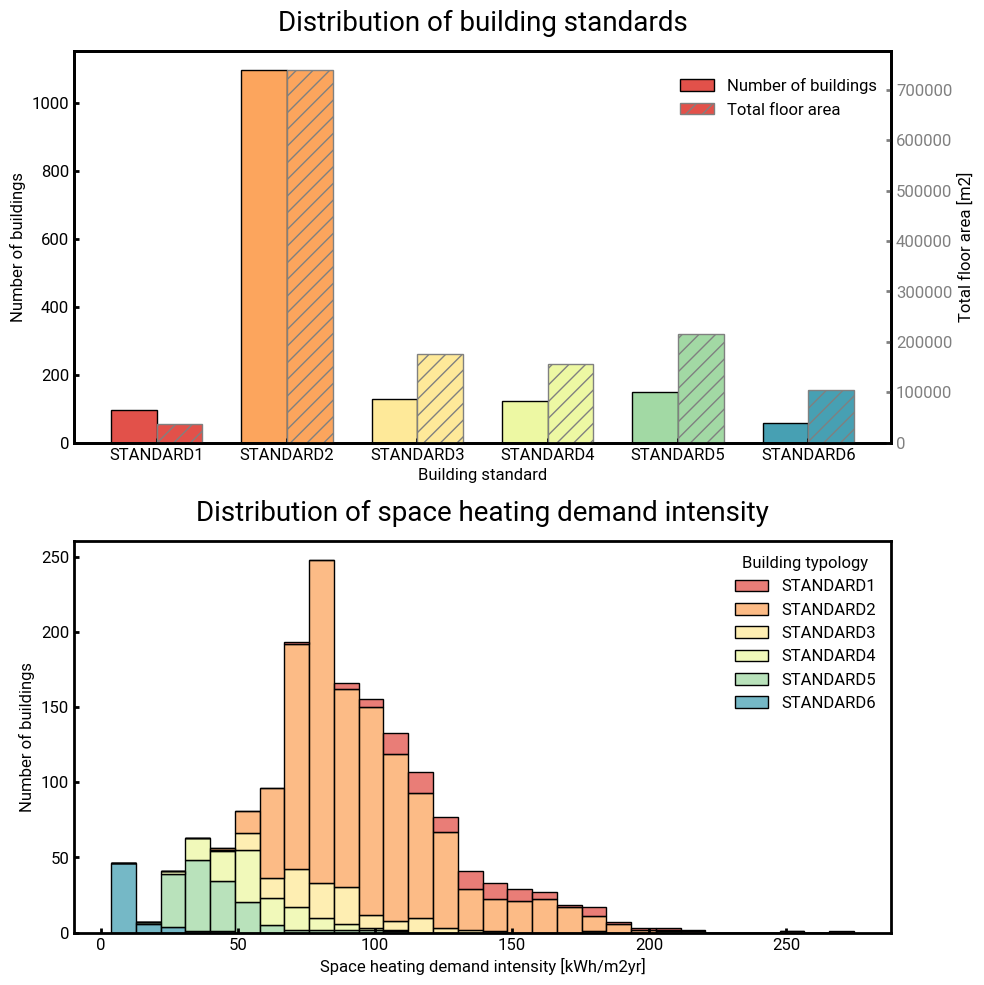

In [3]:
# histogram of building standard
from cea.plots import categories

df = zone_df.copy()
# change STANDARD to categorical
df["STANDARD"] = df["STANDARD"].astype("category")

counts = df["STANDARD"].value_counts().sort_index()
areas = df.groupby("STANDARD")["area"].sum()

categories = counts.index
x = np.arange(len(categories))

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10))
bar_width = 0.35
# get colors from sns spectral palette
colors = sns.color_palette("Spectral", len(categories))
ax1.bar(
    x - bar_width / 2,
    counts,
    bar_width,
    label="Number of buildings",
    color=colors,
    edgecolor="black",
)
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.set_xlabel("Building standard")
ax1.set_ylabel("Number of buildings")
ax1.set_title("Distribution of building standards", fontsize=20)
# ax1.legend()
ax2 = ax1.twinx()
ax2.bar(
    x + bar_width / 2,
    areas,
    bar_width,
    label="Total floor area",
    color=colors,
    edgecolor="grey",
    hatch="//",
)
ax2.set_ylabel("Total floor area [m2]")
ax2.tick_params(axis="y", colors="grey")

fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.93))

sns.histplot(
    data=df,
    x="demand_space_heating_intensity",
    hue="STANDARD",
    # discrete=True,
    multiple="stack",
    palette="Spectral",
    ax=ax3,
    bins=30,
)
ax3.set_xlabel("Space heating demand intensity [kWh/m2yr]")
ax3.set_ylabel("Number of buildings")
ax3.set_title("Distribution of space heating demand intensity", fontsize=20)
sns.move_legend(ax3, "best", title="Building typology")
plt.tight_layout()
# fig.show()

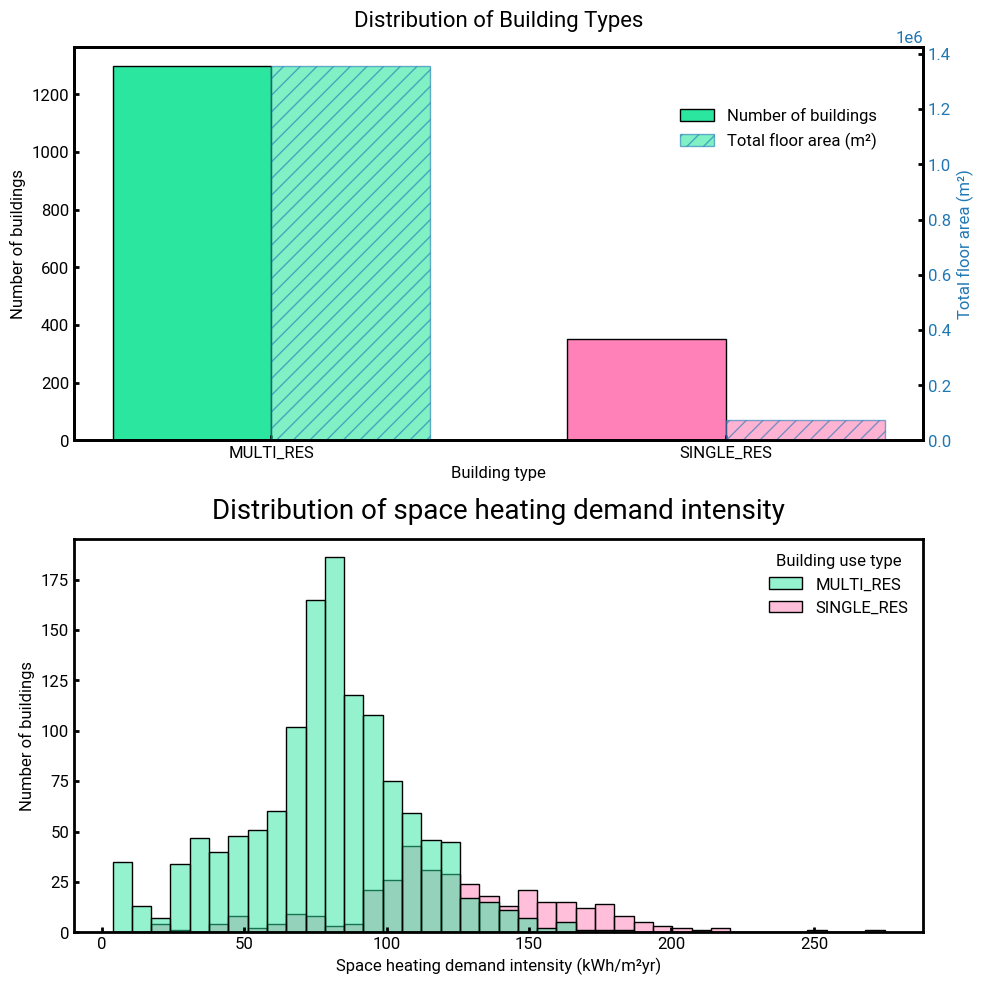

In [4]:
# plot the type of building in "1ST_USE" as histogram.
#  Then use the same graph, add another y axis to show the histogram of total floor area of each type of building
df["1ST_USE"] = df["1ST_USE"].astype("category")
counts = df["1ST_USE"].value_counts()
areas = df.groupby("1ST_USE")["area"].sum()

categories = counts.index
x = np.arange(len(categories))  # x positions for bars

# Plot
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10))

bar_width = 0.35

# First bar: Number of buildings
color_dict = {"SINGLE_RES": "#ff81b7", "MULTI_RES": "#2be69f"}
colors = [color_dict[cat] for cat in categories]
ax1.bar(
    x - bar_width / 2,
    counts,
    width=bar_width,
    color=colors,
    edgecolor="black",
    label="Number of buildings",
)
ax1.set_xlabel("Building type")
ax1.set_ylabel("Number of buildings", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.set_title("Distribution of Building Types")

# Second bar: Total area
ax2 = ax1.twinx()
ax2.bar(
    x + bar_width / 2,
    areas,
    width=bar_width,
    color=colors,
    alpha=0.6,
    label="Total floor area (m²)",
    edgecolor="tab:blue",
    hatch="//",
)
ax2.set_ylabel("Total floor area (m²)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))


# plot the histogram of demand intensity
categories = df["1ST_USE"].unique()
color_dict = {"SINGLE_RES": "#ff81b7", "MULTI_RES": "#2be69f"}
palette = [color_dict[cat] for cat in categories]
colors = [color_dict[cat] for cat in categories]
df["STANDARD"] = df["STANDARD"].astype("category")
# fig, ax = plt.subplots()
sns.histplot(
    data=df,
    x="demand_space_heating_intensity",
    hue="1ST_USE",
    palette=palette,
    ax=ax3,
)
ax3.set_xlabel("Space heating demand intensity (kWh/m²yr)")
ax3.set_ylabel("Number of buildings")
ax3.set_title("Distribution of space heating demand intensity", fontsize=20)
sns.move_legend(ax3, "best", title="Building use type")
plt.tight_layout()
# plt.show()

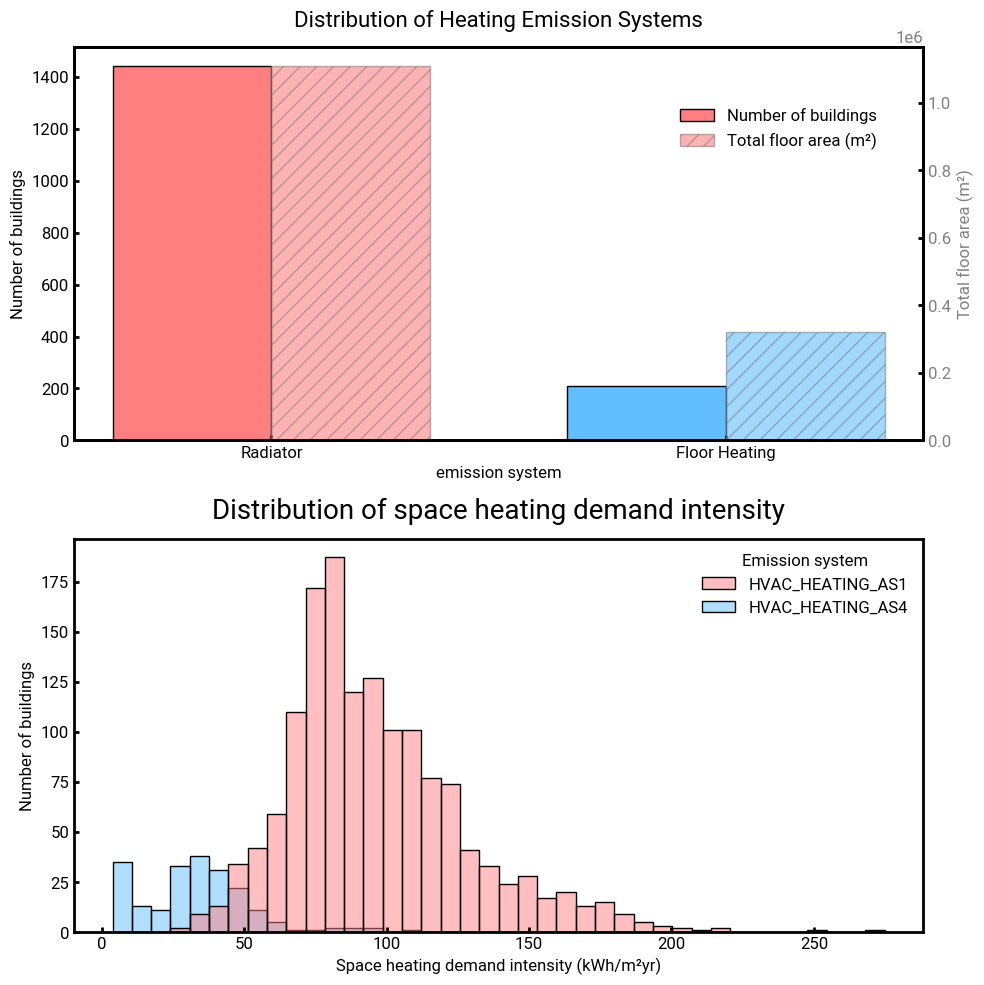

In [5]:
# plot the type of building in "1ST_USE" as histogram.
#  Then use the same graph, add another y axis to show the histogram of total floor area of each type of building
df["type_hs"] = df["type_hs"].astype("category")
counts = df["type_hs"].value_counts()
areas = df.groupby("type_hs")["area"].sum()

categories = counts.index
x = np.arange(len(categories))  # x positions for bars

# Plot
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10))

bar_width = 0.35

# First bar: Number of buildings
color_dict = {"HVAC_HEATING_AS1": "#ff7f81", "HVAC_HEATING_AS4": "#62beff"}
colors = [color_dict[cat] for cat in categories]
ax1.bar(
    x - bar_width / 2,
    counts,
    width=bar_width,
    color=colors,
    edgecolor="black",
    label="Number of buildings",
)
ax1.set_xlabel("emission system")
ax1.set_ylabel("Number of buildings", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(["Radiator", "Floor Heating"])
ax1.set_title("Distribution of Heating Emission Systems")

# Second bar: Total area
ax2 = ax1.twinx()
ax2.bar(
    x + bar_width / 2,
    areas,
    width=bar_width,
    color=colors,
    alpha=0.6,
    label="Total floor area (m²)",
    edgecolor="grey",
    hatch="//",
)
ax2.set_ylabel("Total floor area (m²)", color="grey")
ax2.tick_params(axis="y", labelcolor="grey")

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

sns.histplot(
    data=df,
    x="demand_space_heating_intensity",
    hue="type_hs",
    palette=colors,
    ax=ax3,
)
ax3.set_xlabel("Space heating demand intensity (kWh/m²yr)")
ax3.set_ylabel("Number of buildings")
ax3.set_title("Distribution of space heating demand intensity", fontsize=20)
sns.move_legend(ax3, "best", title="Emission system")

plt.tight_layout()
plt.show()

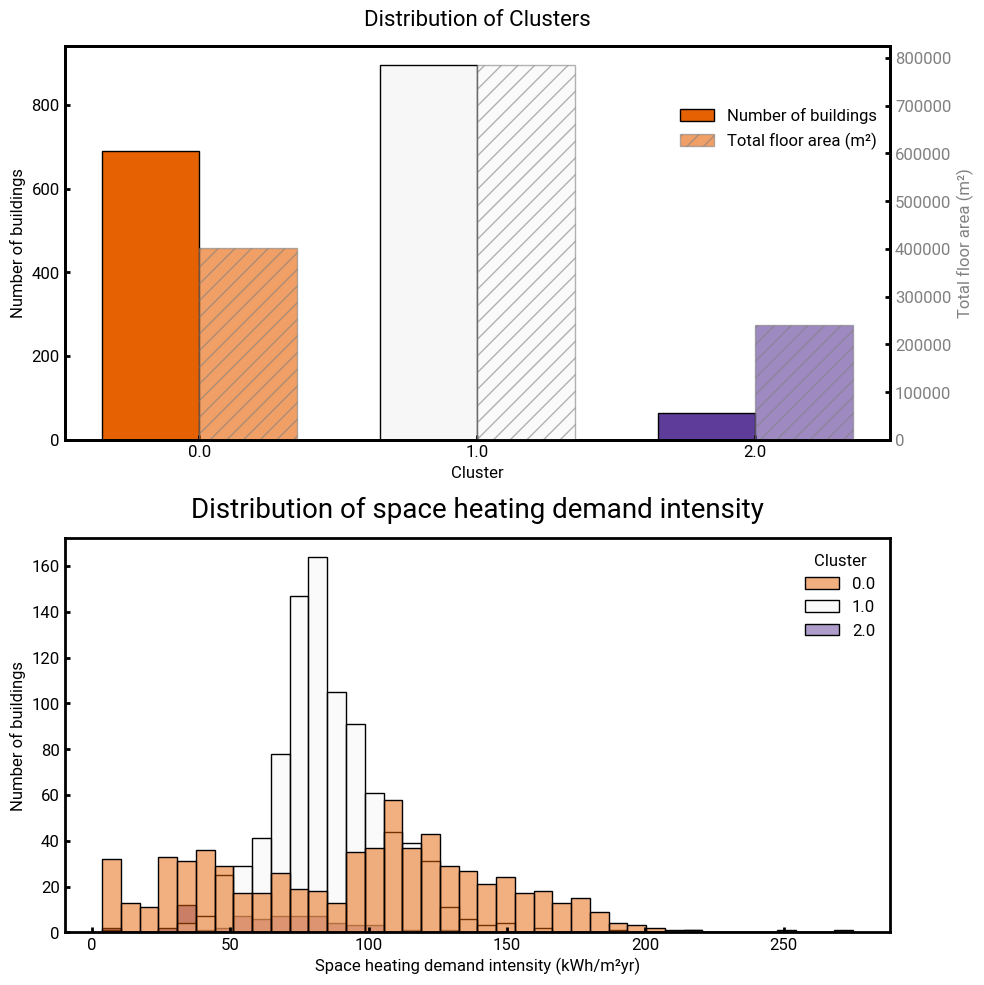

In [6]:
df = zone_df.copy()
# df["cluster"] = df["cluster"].astype("category")
# # change cluster names into cluster 0, cluster 1, outlier
# df["cluster"] = df["cluster"].map({0: "Cluster 0", 1: "Cluster 1", 2: "Outlier"})

counts = df["cluster"].value_counts()
areas = df.groupby("cluster")["area"].sum()

# sort by index
counts = counts.sort_index()
areas = areas.sort_index()

categories = counts.index
x = np.arange(len(categories))  # x

# Plot
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10))
bar_width = 0.35

colors = ["#e66101", "#f7f7f7", "#5e3c99"]

# First bar: Number of buildings
ax1.bar(
    x - bar_width / 2,
    counts,
    width=bar_width,
    color=colors,
    edgecolor="black",
    label="Number of buildings",
)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of buildings", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.set_title("Distribution of Clusters")

# Second bar: Total area
ax2 = ax1.twinx()
ax2.bar(
    x + bar_width / 2,
    areas,
    width=bar_width,
    color=colors,
    alpha=0.6,
    label="Total floor area (m²)",
    edgecolor="grey",
    hatch="//",
)
ax2.set_ylabel("Total floor area (m²)", color="grey")
ax2.tick_params(axis="y", labelcolor="grey")

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

sns.histplot(
    data=df,
    x="demand_space_heating_intensity",
    hue="cluster",
    palette=colors,
    ax=ax3,
)
ax3.set_xlabel("Space heating demand intensity (kWh/m²yr)")
ax3.set_ylabel("Number of buildings")
ax3.set_title("Distribution of space heating demand intensity", fontsize=20)
sns.move_legend(ax3, "best", title="Cluster")
plt.tight_layout()
plt.show()

#### knapsack plots

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


27560472.520160872 5388545.114810772


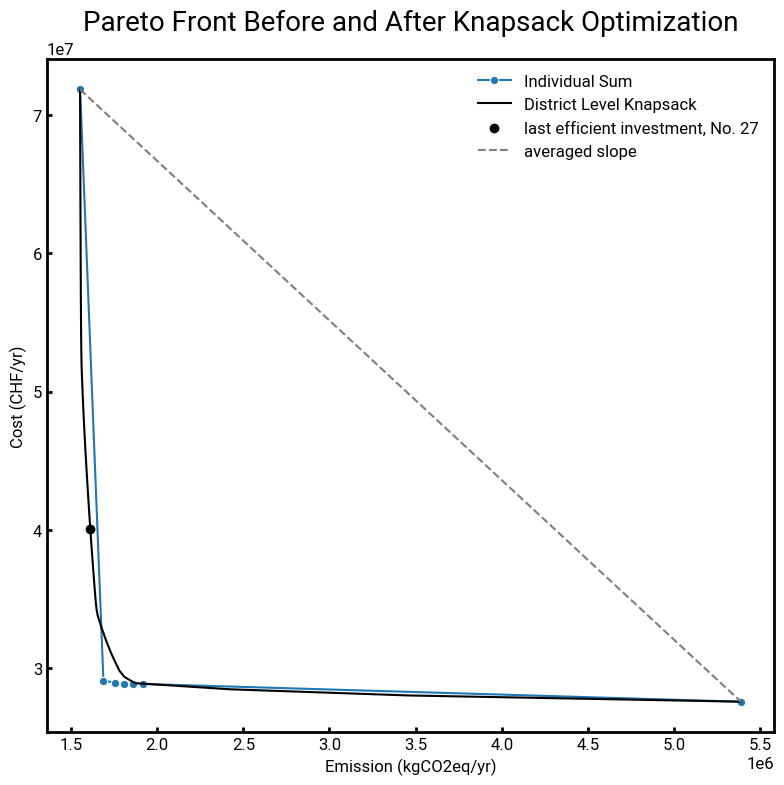

In [3]:
# plot the sum of cost and emission for all buildings for every pareto index (7 points in total)
fig, ax = plt.subplots(figsize=(8, 8))
# sum the cost and emission for all buildings for every pareto index and plot
df_copy = df_pareto_all.copy()
df_copy = df_copy.groupby("pareto_index").sum()
sns.lineplot(
    data=df_copy, x="emission", y="cost", ax=ax, label="Individual Sum", marker="o"
)

ks_results = pd.read_csv(
    r"C:\Users\wangy\Documents\GitHub\energy_hub_optimizer_calliope\trustParetoFronts\district_knapsack_results\knapsack_result_after_presentation.csv"
)
min_emission = df_copy["emission"].min()
max_emission = df_copy["emission"].max()
min_cost = df_copy["cost"].min()
max_cost = df_copy["cost"].max()
print(min_cost, max_emission)

ks_results["emission"] = max_emission - ks_results["emission_reduction"]
sns.lineplot(
    data=ks_results,
    x="emission",
    y="cost",
    ax=ax,
    color="black",
    # marker=".",
    # linestyle="--",
    label="District Level Knapsack",
)

ax.scatter(
    x=ks_results.loc[28, "emission"],
    y=ks_results.loc[28, "cost"],
    color="black",
    marker="o",
    label="last efficient investment, No. 27",
)
sns.lineplot(
    x=[min_emission, max_emission],
    y=[max_cost, min_cost],
    color="tab:gray",
    linestyle="--",
    label="averaged slope",
    ax=ax,
)
ax.set_xlabel("Emission (kgCO2eq/yr)")
ax.set_ylabel("Cost (CHF/yr)")
ax.set_title("Pareto Front Before and After Knapsack Optimization", fontsize=20)
# sns.move_legend(ax, "best")
ax.legend(loc="upper right")
plt.tight_layout()

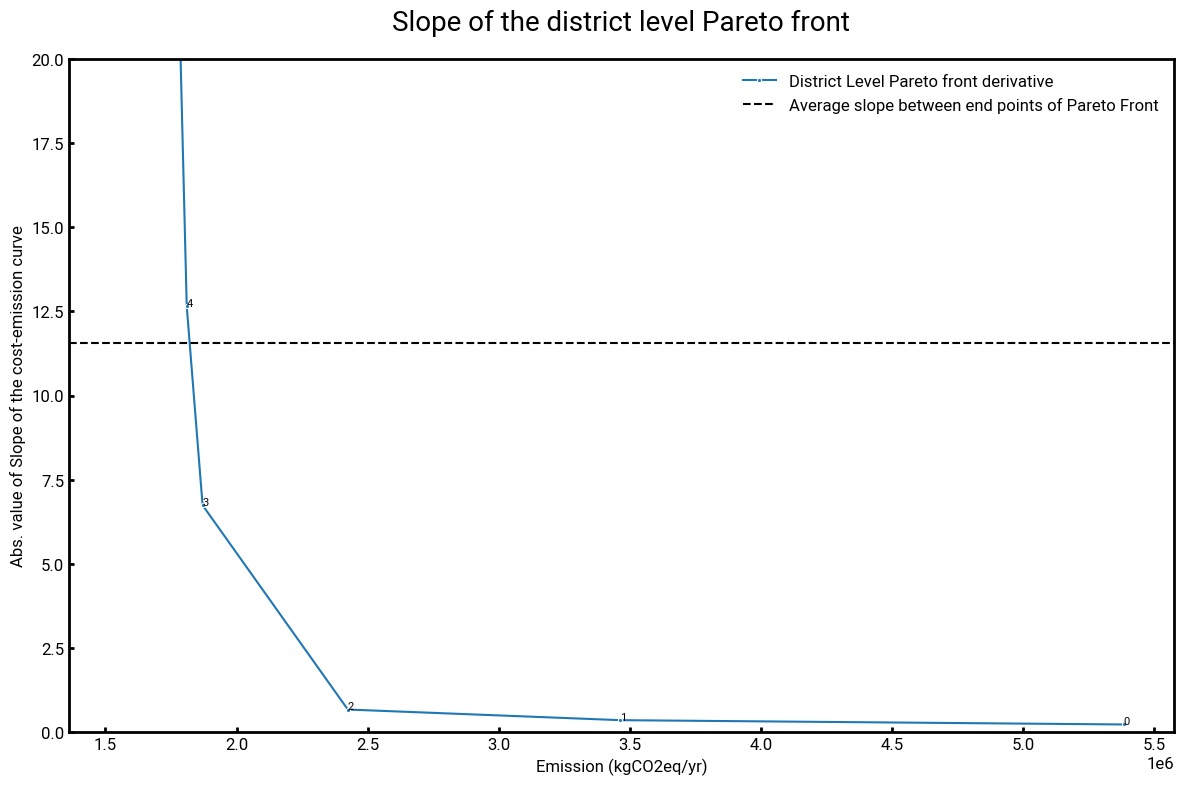

In [8]:
fig, ax = plt.subplots()
derivative = abs(np.gradient(ks_results["cost"], ks_results["emission"]))
# when plotting the derivative, make sure to label each point with the corresponding index
sns.lineplot(
    data=ks_results,
    x="emission",
    y=derivative,
    ax=ax,
    marker=".",
    label="District Level Pareto front derivative",
)
for i, txt in enumerate(ks_results.index):
    ax.annotate(txt, (ks_results["emission"][i], derivative[i]), fontsize=8)
# add the line of the slope of the building level Pareto front
slope_average = (max_cost - min_cost) / (max_emission - min_emission)
# add a horizontal line to show the average slope with comments: "average slope"
ax.axhline(
    y=slope_average,
    color="black",
    linestyle="--",
    label="Average slope between end points of Pareto Front",
)
ax.set_xlabel("Emission (kgCO2eq/yr)")
ax.set_ylabel("Abs. value of Slope of the cost-emission curve")
ax.set_title("Slope of the district level Pareto front", fontsize=20)
# sns.move_legend(ax, "best")
ax.legend(loc="best")
ax.set_ylim(0, 20)
plt.tight_layout()
plt.show()

Now we look into the decision for each knapsack result, and see which buildings are getting more investment before the last efficient investment (index=28) is made.

The decision is stored in a csv like this:

```csv
building,   0, 1, 2
B1001,      6, 6, 5
B1002,      6, 6, 5
B1003,      6, 3, 1
B1004,      6, 6, 6
B1005,      3, 3, 2
```

The first column is the building name, and the rest of the columns are the decision for each knapsack result.
In each entry, the number represents the pareto_index of that building's pareto_df. 6 is the cheapest, and 0 is the most expensive solution.

I want to select the buildings that have pareto_index less than 6 appeared before column 28.

In [5]:
# import the decision of the district level knapsack
decision_df = pd.read_csv(
    r"C:\Users\wangy\Documents\GitHub\energy_hub_optimizer_calliope\trustParetoFronts\district_knapsack_results\knapsack_decision_after_presentation.csv"
)
decision_df = decision_df.set_index("building")
efficient_decision = decision_df.iloc[:, :28]
# print(efficient_decision)
# see which buidings (row) have selected pareto index less than 6
selected = efficient_decision[efficient_decision.le(5).any(axis=1)]
print(selected)
selected_additional_investment = selected.copy()
for building in selected.index:
    df_pareto = df_pareto_all.loc[[building]]
    cost_array = df_pareto["cost"].values / zone_df.loc[building, "area"]
    min_cost = cost_array.min()
    selected_additional_investment.loc[building] = selected_additional_investment.loc[
        building
    ].apply(lambda x: cost_array[int(x)] - min_cost)

# divide with the area of the building to get the cost per m2
print(selected_additional_investment)
# count how many 6s are in each row. Don't count entries that are not 6. Return a series of number of 6s in each row
selected_count = 28 - selected.apply(lambda x: x[x == 6].count(), axis=1)
# selected_count records how many times in the first 28 decision, the building has been selected
# to grant an additional investment to schieve for the emission reduction
# sort the series from the largest to the smallest
selected_count = selected_count.sort_values(ascending=False)
selected_additional_investment_average = selected_additional_investment.mean(
    axis=1
).sort_values(ascending=False)
print(selected_additional_investment_average)
print(selected_count)

# add this information to zone_df, with the rest being 0
zone_df["selected_invest_count"] = 0
zone_df.loc[selected_count.index, "selected_invest_count"] = selected_count
zone_df["selected_invest_cost"] = 0
zone_df.loc[selected_additional_investment_average.index, "selected_invest_cost"] = (
    selected_additional_investment_average
)

# if count > 0, then zone_df["cluster_selected"] = 1, else 0
zone_df["cluster_selected"] = 0
zone_df.loc[zone_df["selected_invest_count"] > 0, "cluster_selected"] = 1

          0  1  2  3  4  5  6  7  8  9  ...  18  19  20  21  22  23  24  25  \
building                                ...                                   
B160887   6  6  6  6  6  6  6  6  6  6  ...   6   6   6   6   6   6   6   6   
B161101   6  6  6  6  6  6  6  6  6  6  ...   6   6   6   6   5   5   5   5   
B161138   6  6  6  6  6  6  6  6  6  6  ...   6   6   6   6   6   6   5   6   
B161280   6  6  6  6  6  6  6  6  6  6  ...   6   6   6   6   6   6   5   5   
B161291   6  6  6  6  6  6  6  6  6  5  ...   5   5   5   5   5   5   5   5   
...      .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
B9001329  5  5  5  5  5  5  5  5  5  5  ...   5   5   5   5   5   5   5   5   
B9001388  6  6  6  6  6  6  6  4  4  4  ...   1   1   1   1   1   1   1   1   
B9001709  6  6  6  6  6  6  6  6  6  6  ...   2   2   2   2   2   2   2   2   
B9001718  6  6  6  6  6  6  6  6  6  6  ...   2   2   2   2   2   2   2   2   
B9011517  6  5  5  5  5  5  5  5  5  5  ...   5   5 

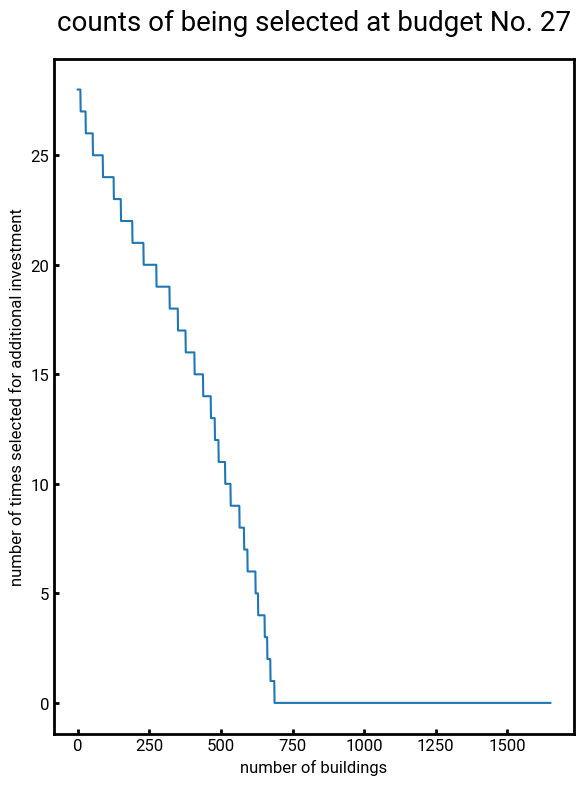

In [6]:
selected_count_sorted = zone_df["selected_invest_count"].sort_values(ascending=False)

# plot the number of times each building has been selected for additional investment
fig, ax = plt.subplots(figsize=(6, 8))
sns.lineplot(
    x=np.arange(len(selected_count_sorted)),
    y=selected_count_sorted,
    ax=ax,
    # marker="o",
)
ax.set_xlabel("number of buildings")
ax.set_ylabel("number of times selected for additional investment")
ax.set_title("counts of being selected at budget No. 27", fontsize=20)
plt.tight_layout()

### fig1: Pareto Space plot

In [16]:
cluster_markers = {
    0: ".",
    1: "x",
    2: "+",
}
year_min = df_pareto_all["YEAR"].min()
year_max = df_pareto_all["YEAR"].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap("viridis")  # type: ignore
# shadow_price_min = df_pareto_all["shadow_price"].min()
# shadow_price_max = df_pareto_all["shadow_price"].max()
# shadow_price_min = 1.0
# shadow_price_max = 1.5
# shadow_price_norm = mcolors.Normalize(vmin=shadow_price_min, vmax=shadow_price_max)

(-2.5672641410362647, 66.51156039200718)


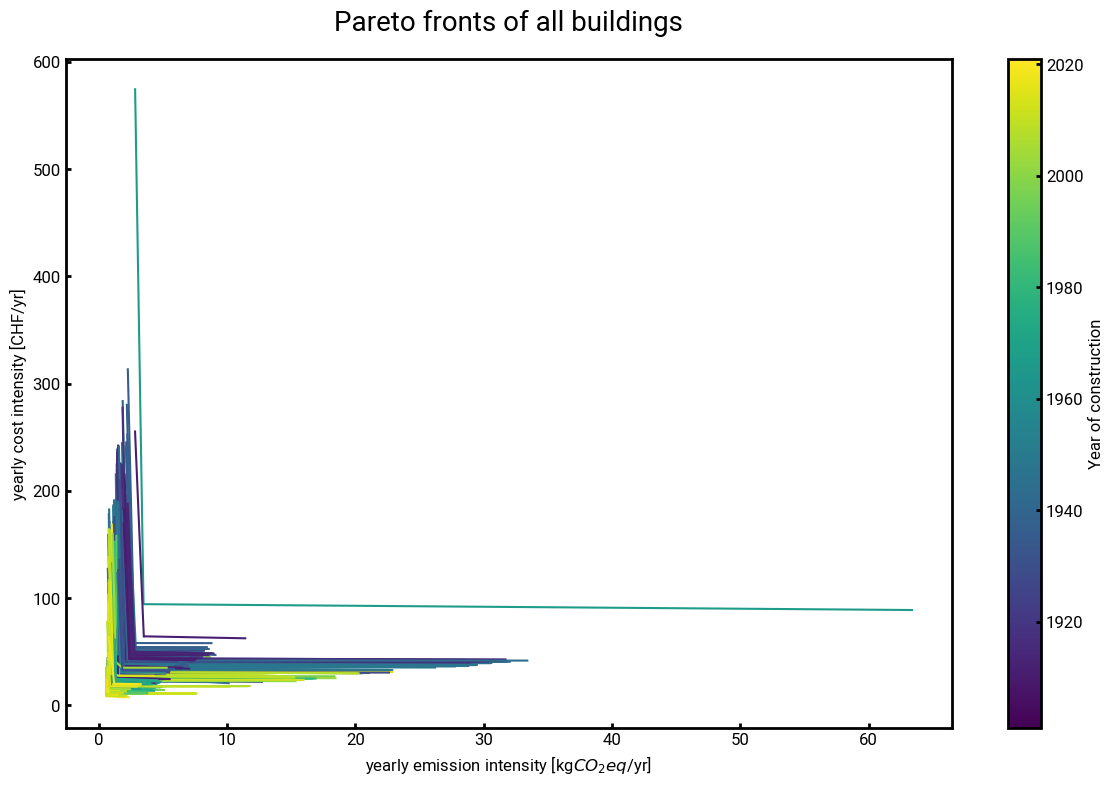

In [18]:
fig1, ax1 = plt.subplots()
for building_name in df_pareto_all.index.get_level_values(0).unique():
    # if zone_df.loc[building_name, "shadow_price"] < 1.0:
    #     continue
    df_pareto = df_pareto_all.loc[building_name]
    # pareto front has two levels of index, the first one is the building name and second one is the pareto front number starting from 0
    emissions = df_pareto["emission"].values
    costs = df_pareto["cost"].values
    area = df_pareto[
        "area"
    ].mean()  # area is the same for all pareto fronts of the same building
    cluster = df_pareto["cluster"].iloc[0]
    ax1.plot(
        emissions / area,
        costs / area,
        label=building_name,
        # marker=cluster_markers[cluster],
        color=colormap(year_norm(zone_df["YEAR"].loc[building_name])),
        # color=colormap(shadow_price_norm(df_pareto["shadow_price"].iloc[0])),
        markersize=5,
    )
    # label the building name next to the last point of the pareto front
    # ax1.text(
    #     emissions[-1] / area,
    #     costs[-1] / area,
    #     building_name,
    #     fontsize=8,
    #     verticalalignment="center",
    # )
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax1, orientation="vertical")  # type: ignore
cbar1.set_label("Year of construction")
ax1.set_xlabel("yearly emission intensity [kg$CO_2eq$/yr]")
ax1.set_ylabel("yearly cost intensity [CHF/yr]")
print(ax1.get_xlim())
if with_oil:
    ax1.set_title("Pareto fronts of all buildings for scenario with oil")
else:
    ax1.set_title("Pareto fronts of all buildings", fontsize=20)
fig1.tight_layout()

(-2.5672641410362647, 66.51156039200718)


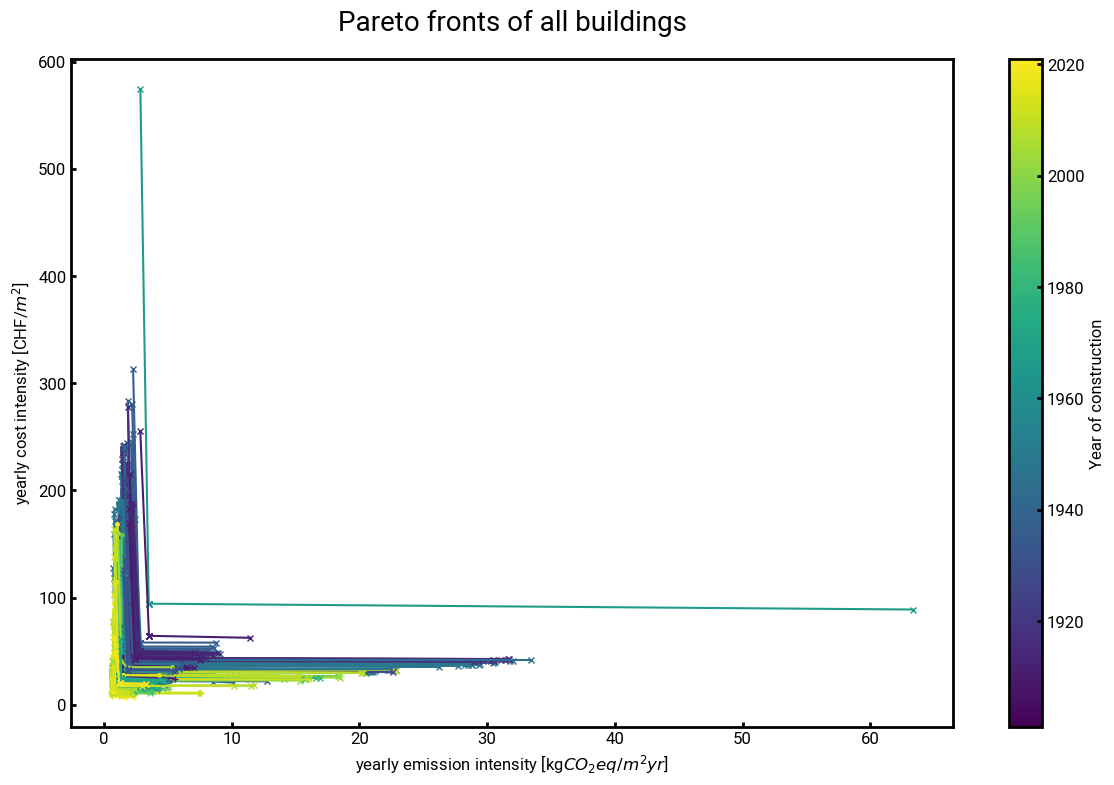

In [19]:
fig1, ax1 = plt.subplots()
for building_name in df_pareto_all.index.get_level_values(0).unique():
    # if zone_df.loc[building_name, "shadow_price"] < 1.0:
    #     continue
    df_pareto = df_pareto_all.loc[building_name]
    # pareto front has two levels of index, the first one is the building name and second one is the pareto front number starting from 0
    emissions = df_pareto["emission"].values
    costs = df_pareto["cost"].values
    area = df_pareto[
        "area"
    ].mean()  # area is the same for all pareto fronts of the same building
    cluster = df_pareto["cluster"].iloc[0]
    ax1.plot(
        emissions / area,
        costs / area,
        label=building_name,
        marker=cluster_markers[cluster],
        color=colormap(year_norm(zone_df["YEAR"].loc[building_name])),
        # color=colormap(shadow_price_norm(df_pareto["shadow_price"].iloc[0])),
        markersize=5,
    )
    # label the building name next to the last point of the pareto front
    # ax1.text(
    #     emissions[-1] / area,
    #     costs[-1] / area,
    #     building_name,
    #     fontsize=8,
    #     verticalalignment="center",
    # )
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax1, orientation="vertical")  # type: ignore
cbar1.set_label("Year of construction")
ax1.set_xlabel("yearly emission intensity [kg$CO_2eq/m^2yr$]")
ax1.set_ylabel("yearly cost intensity [CHF/$m^2$]")
print(ax1.get_xlim())
if with_oil:
    ax1.set_title("Pareto fronts of all buildings for scenario with oil")
else:
    ax1.set_title("Pareto fronts of all buildings", fontsize=20)
fig1.tight_layout()

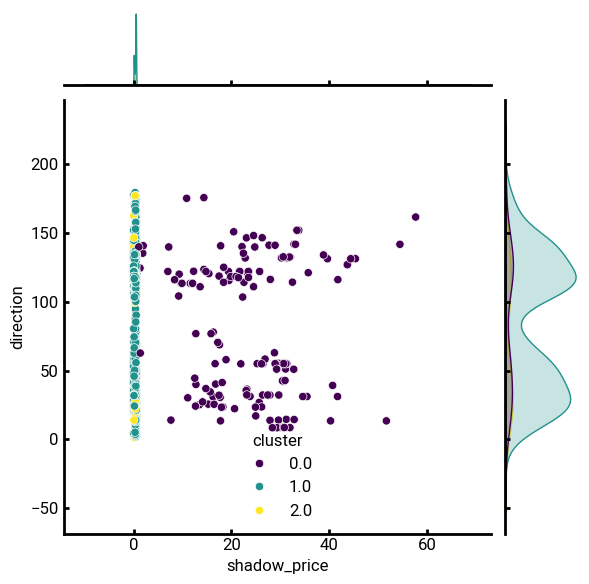

In [20]:
sns.jointplot(
    data=zone_df,
    x="shadow_price",
    y="direction",
    hue="cluster",
    palette="viridis",
    kind="scatter",
)

### fig2: emission reduction potential against shadow price

#### colored by building age

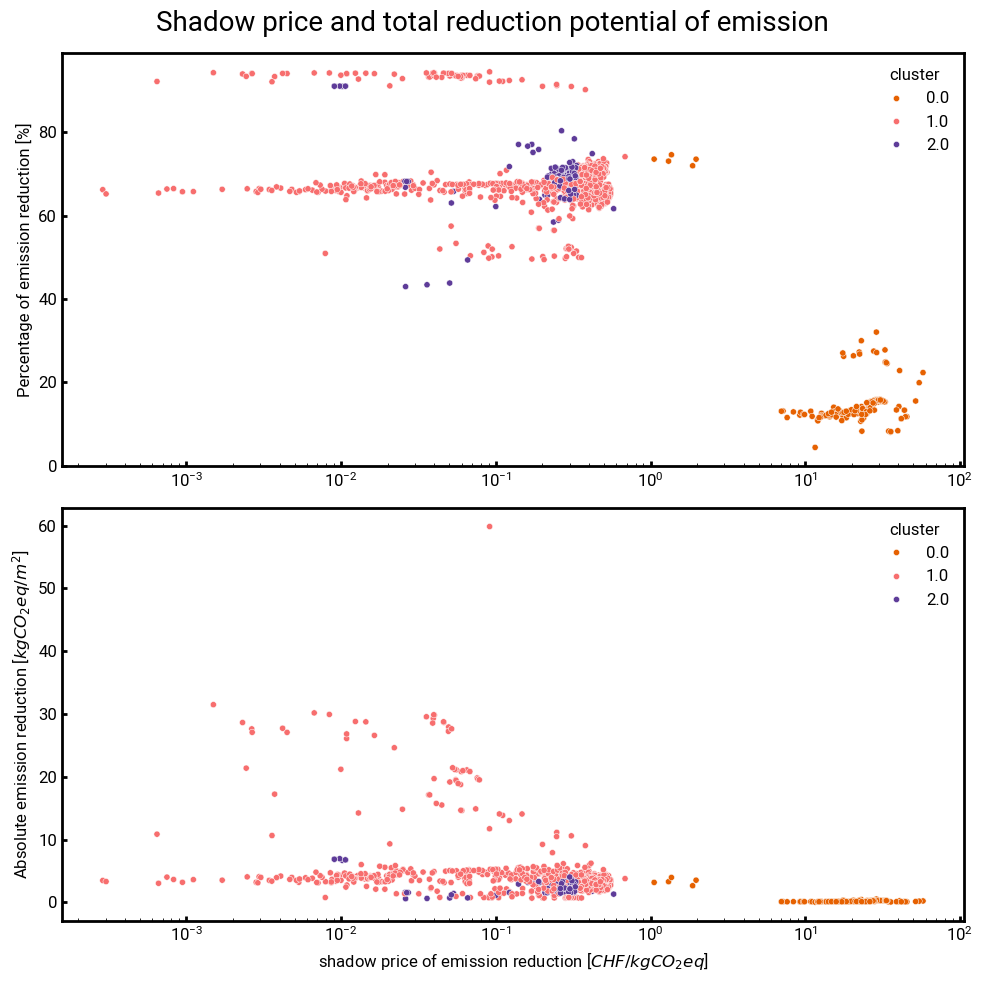

In [21]:
data = zone_df.copy()
data["emission_range_rel"] = data["emission_range_rel"] * 100

fig2, axes = plt.subplots(2, 1, figsize=(10, 10))
for idx, ax in enumerate(axes):
    if idx == 0:
        y = "emission_range_rel"
        ax.set_ylabel("Percentage of emission reduction [%]")
    else:
        y = "emission_range_abs"
        ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")
    sns.scatterplot(
        data=data,
        x="shadow_price",
        y=y,
        hue="cluster",
        palette=["#e66101", "#f76e6e", "#5e3c99"],
        ax=ax,
        s=20,
    )
    ax.legend(loc="upper right", title="cluster")
axes[0].sharex(axes[1])
axes[0].set_xlabel("")
axes[1].set_xlabel("shadow price of emission reduction [$CHF/kgCO_2eq$]")
if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle("Shadow price and total reduction potential of emission", fontsize=20)

# set x axis to log scale
axes[0].set_xscale("log")
# axes[0].set_xlim(0, 100)
fig2.tight_layout()

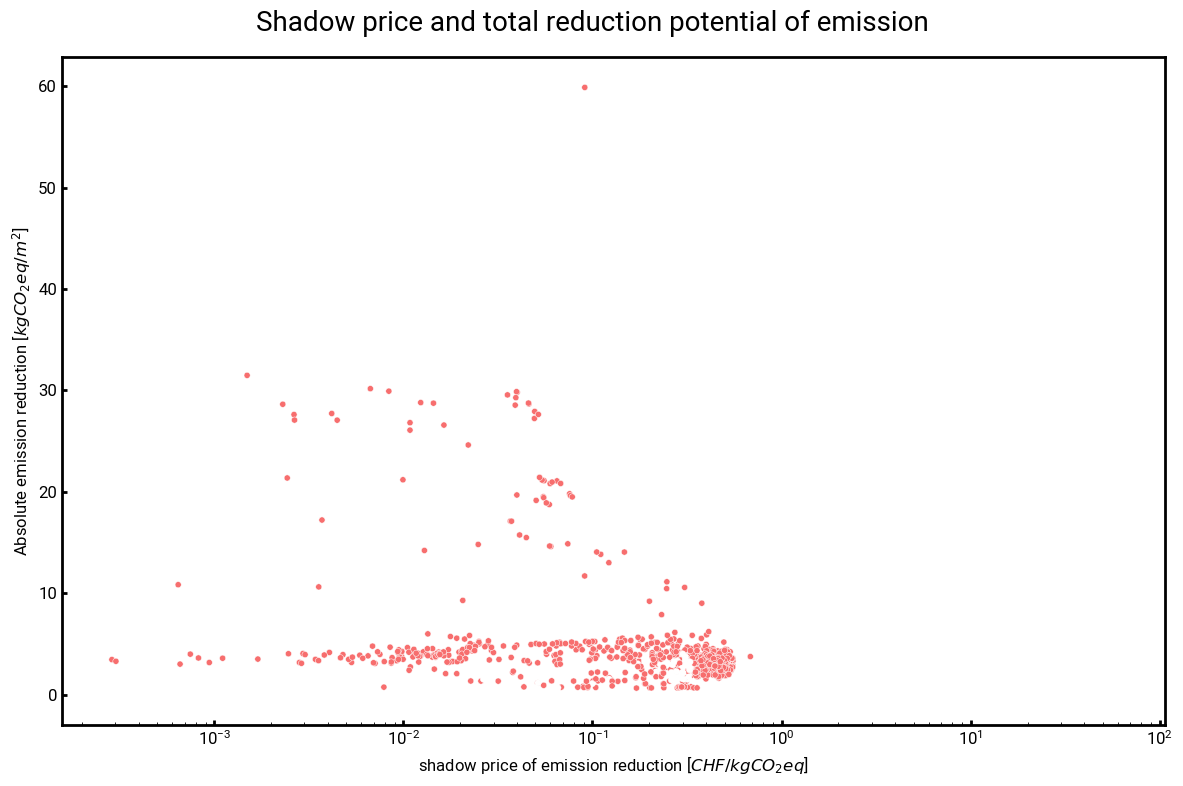

In [22]:
data = zone_df.copy()
# data["emission_range_rel"] = data["emission_range_rel"] * 100

fig2, ax = plt.subplots(figsize=(12, 8))
y = "emission_range_abs"
ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")
sns.scatterplot(
    data=data,
    x="shadow_price",
    y=y,
    hue="cluster",
    palette=["#FFFFFF", "#f76e6e", "#FFFFFF"],
    ax=ax,
    s=20,
)
# ax.legend(show=False)
# don't show the legend
ax.get_legend().remove()
# axes[0].sharex(axes[1])
# axes[0].set_xlabel("")
ax.set_xlabel("shadow price of emission reduction [$CHF/kgCO_2eq$]")
if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle("Shadow price and total reduction potential of emission", fontsize=20)

# set x axis to log scale
ax.set_xscale("log")
# axes[0].set_xlim(0, 100)
fig2.tight_layout()

#### colored by additional investment count

ValueError: Could not interpret value `selected_invest_count` for `hue`. An entry with this name does not appear in `data`.

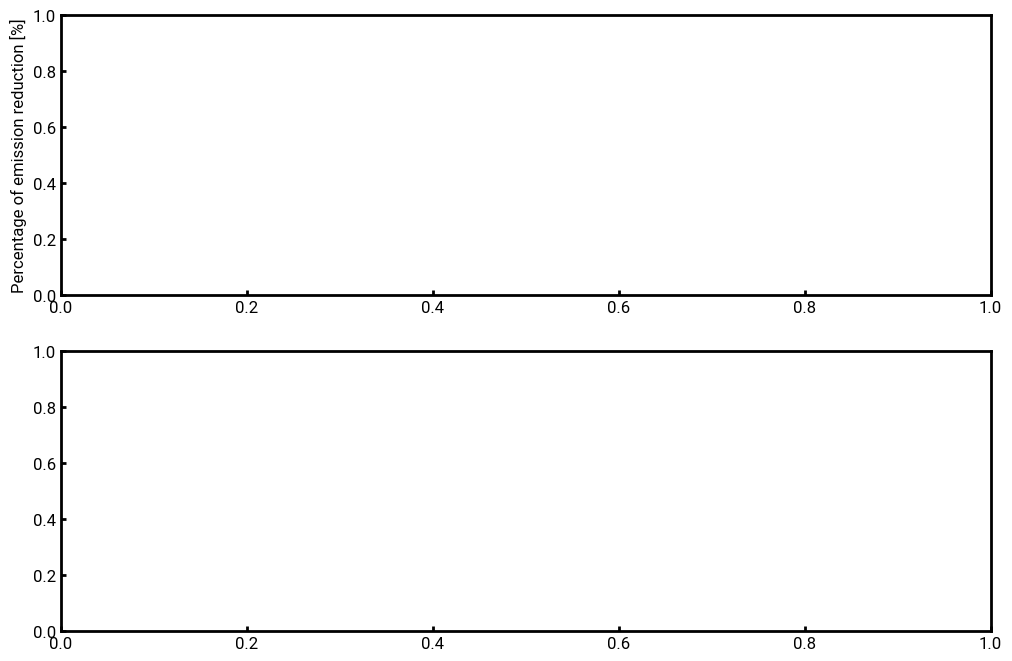

In [23]:
data = zone_df.copy()
data["emission_range_rel"] = data["emission_range_rel"] * 100

fig2, axes = plt.subplots(2, 1)
for idx, ax in enumerate(axes):
    if idx == 0:
        y = "emission_range_rel"
        ax.set_ylabel("Percentage of emission reduction [%]")
    else:
        y = "emission_range_abs"
        ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")
    sns.scatterplot(
        data=data,
        x="shadow_price",
        y=y,
        hue="selected_invest_count",
        palette="rainbow",
        ax=ax,
        s=15,
    )
    ax.legend(loc="best")
axes[0].sharex(axes[1])
axes[0].set_xlabel("")
axes[1].set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")

if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario without oil"
    )
axes[0].set_xscale("log")
fig2.tight_layout()

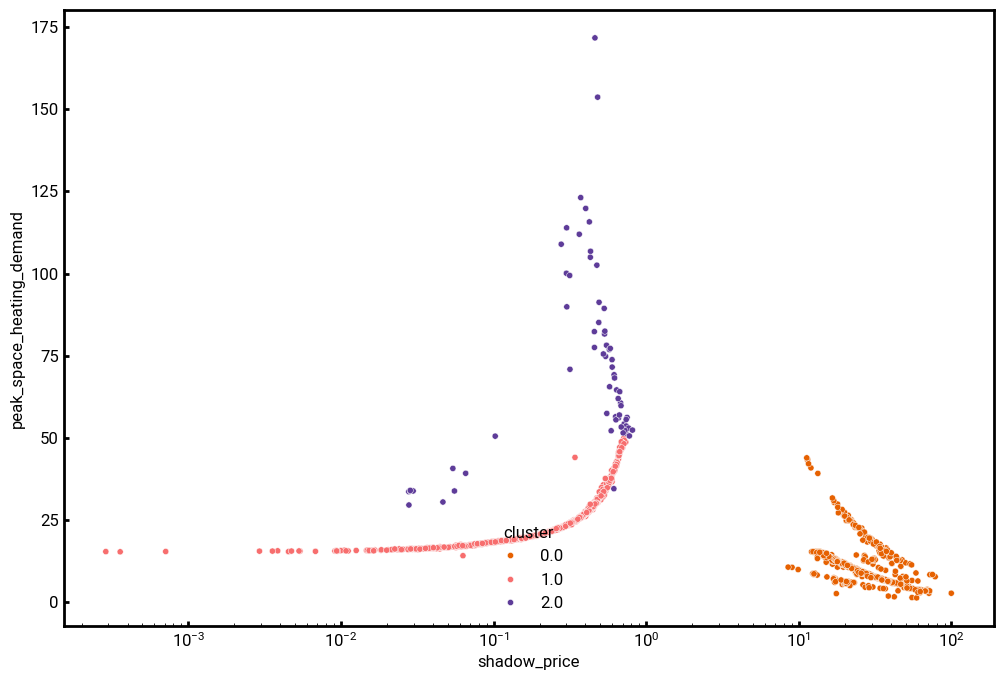

In [15]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=zone_df,
    x="shadow_price",
    y="peak_space_heating_demand",
    hue="cluster",
    palette=["#e66101", "#f76e6e", "#5e3c99"],
    ax=ax,
    s=20,
)
ax.set_xscale("log")
# ax.set_xlim(0, 1)
# ax.set_ylim(1, 25)

#### colored by shape factor

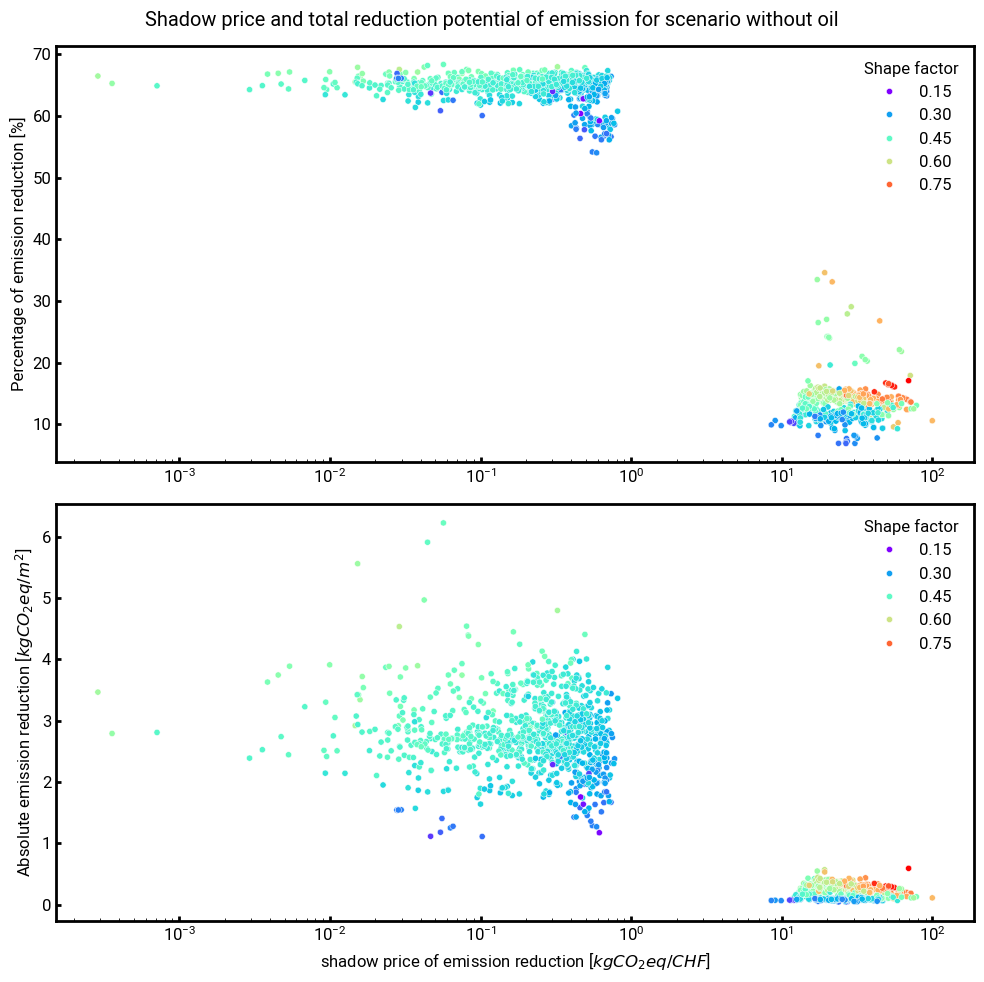

In [16]:
data = zone_df.copy()
data["emission_range_rel"] = data["emission_range_rel"] * 100

fig2, axes = plt.subplots(2, 1, figsize=(10, 10))
for idx, ax in enumerate(axes):
    if idx == 0:
        y = "emission_range_rel"
        ax.set_ylabel("Percentage of emission reduction [%]")
    else:
        y = "emission_range_abs"
        ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")
    sns.scatterplot(
        data=data,
        x="shadow_price",
        y=y,
        hue="shape_factor",
        palette="rainbow",
        # hue_norm=(0.3, 0.6),
        ax=ax,
        s=20,
    )
    ax.legend(loc="best", title="Shape factor")
axes[0].sharex(axes[1])
axes[0].set_xlabel("")
axes[1].set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")

if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario without oil"
    )
axes[0].set_xscale("log")
fig2.tight_layout()

In [17]:
# data = zone_df.copy()
# # all non-numeric columns should be converted as category
# for col in data.columns:
#     if data[col].dtype == "object":
#         data[col] = data[col].astype("category")
# data["emission_range_rel"] = data["emission_range_rel"] * 100

# # use all columns in data as hue apart from shadow price, emission_range_rel, emission_range_abs and cluster
# hue_columns = data.columns.difference(
#     ["shadow_price", "emission_range_rel", "emission_range_abs", "cluster"]
# )

# for hue in hue_columns:
#     fig2, axes = plt.subplots(2, 1)
#     for idx, ax in enumerate(axes):
#         if idx == 0:
#             y = "emission_range_rel"
#             ax.set_ylabel("Percentage of emission reduction [%]")
#         else:
#             y = "emission_range_abs"
#             ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")
#         sns.scatterplot(
#             data=data,
#             x="shadow_price",
#             y=y,
#             hue=hue,
#             palette="viridis",
#             ax=ax,
#             s=20,
#         )
#         ax.legend(loc="best", title=hue)
#     axes[0].sharex(axes[1])
#     axes[0].set_xlabel("")
#     axes[1].set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")

#     if with_oil:
#         fig2.suptitle(
#             "Shadow price and total reduction potential of emission for scenario with oil"
#         )
#     else:
#         fig2.suptitle(
#             "Shadow price and total reduction potential of emission for scenario without oil"
#         )

#     fig2.tight_layout()
#     fig2.savefig(f"fig2_{hue}.png")

### fig3: tech size box plot

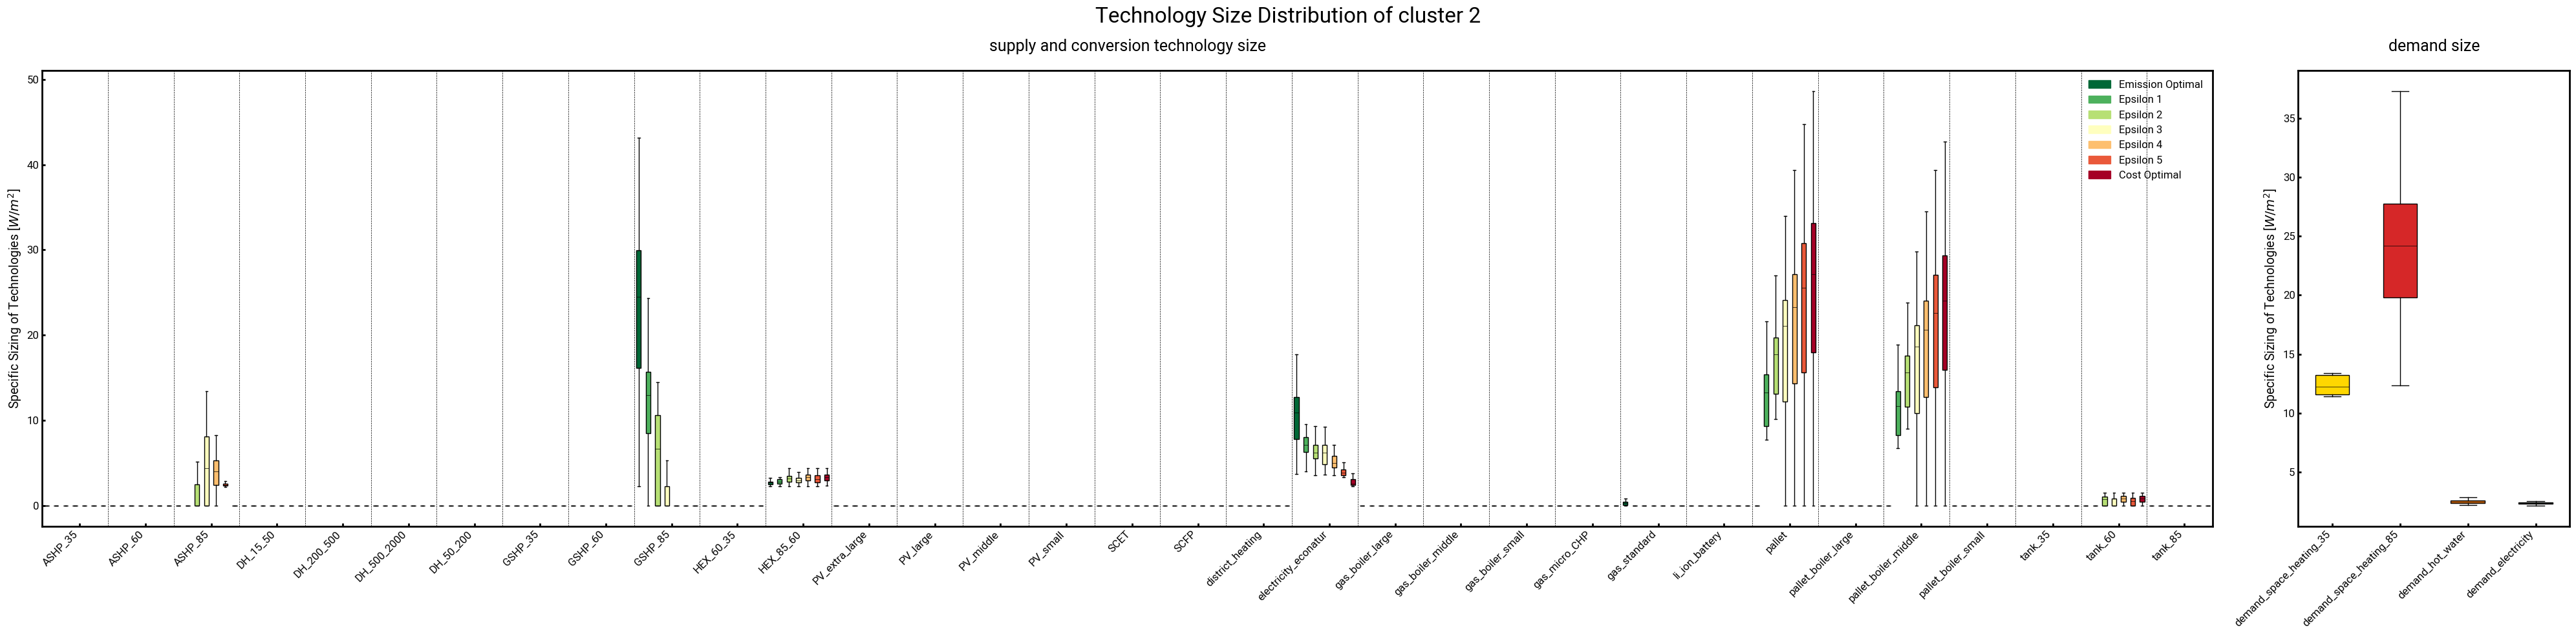

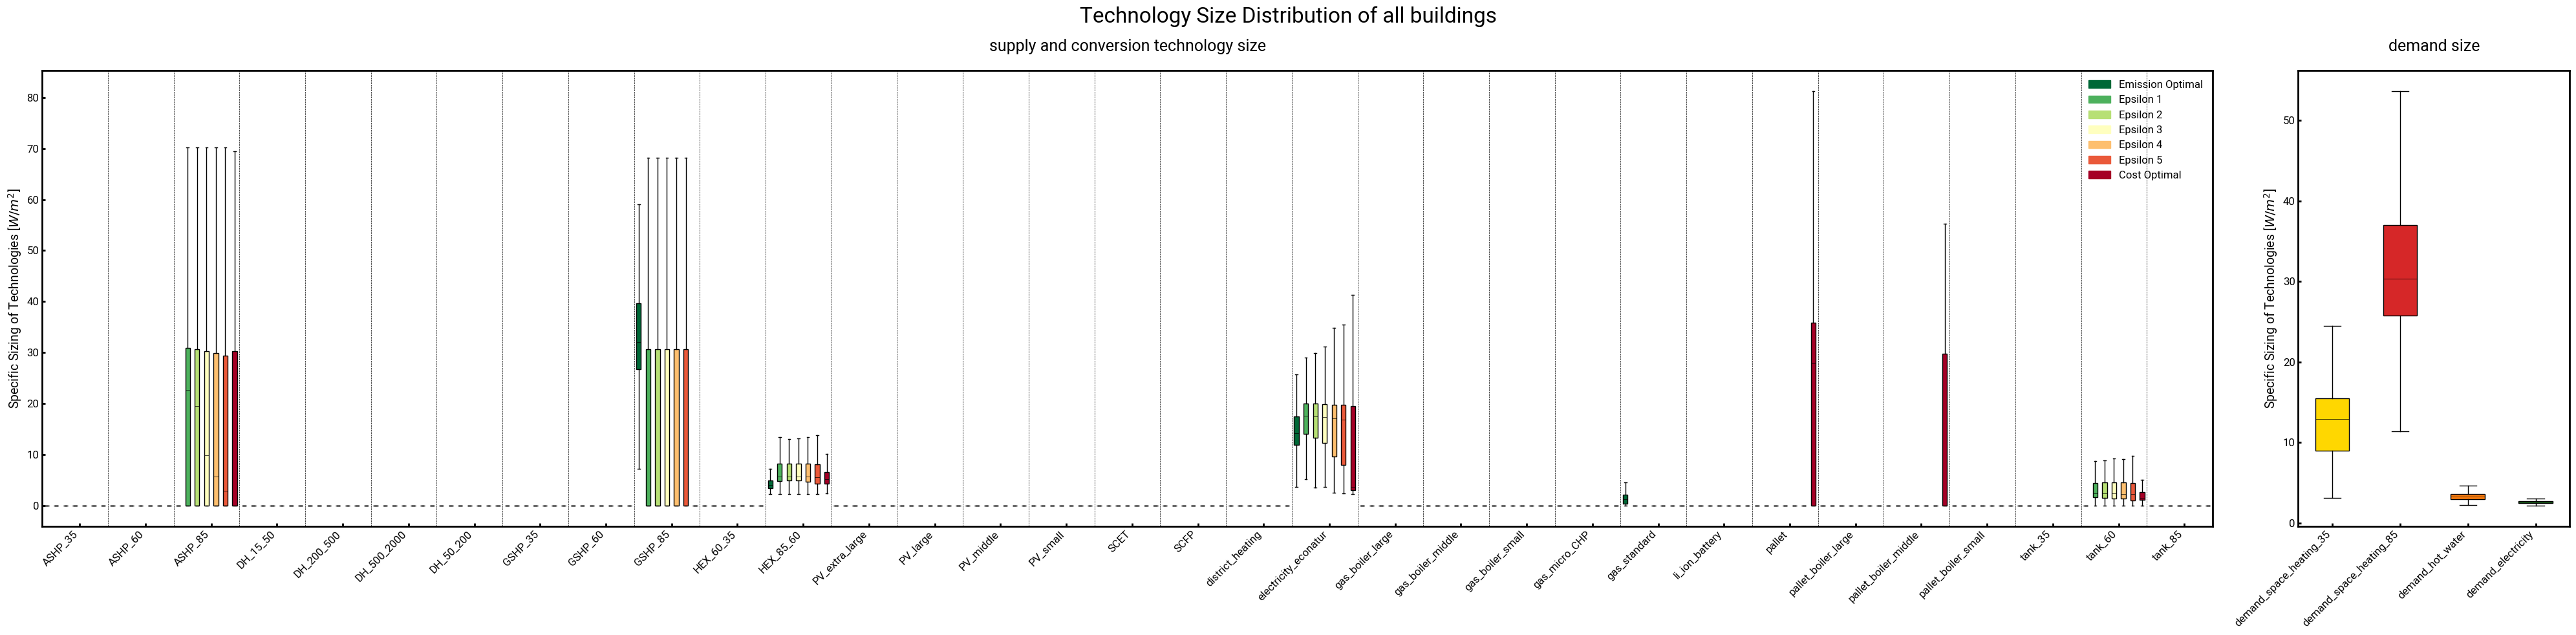

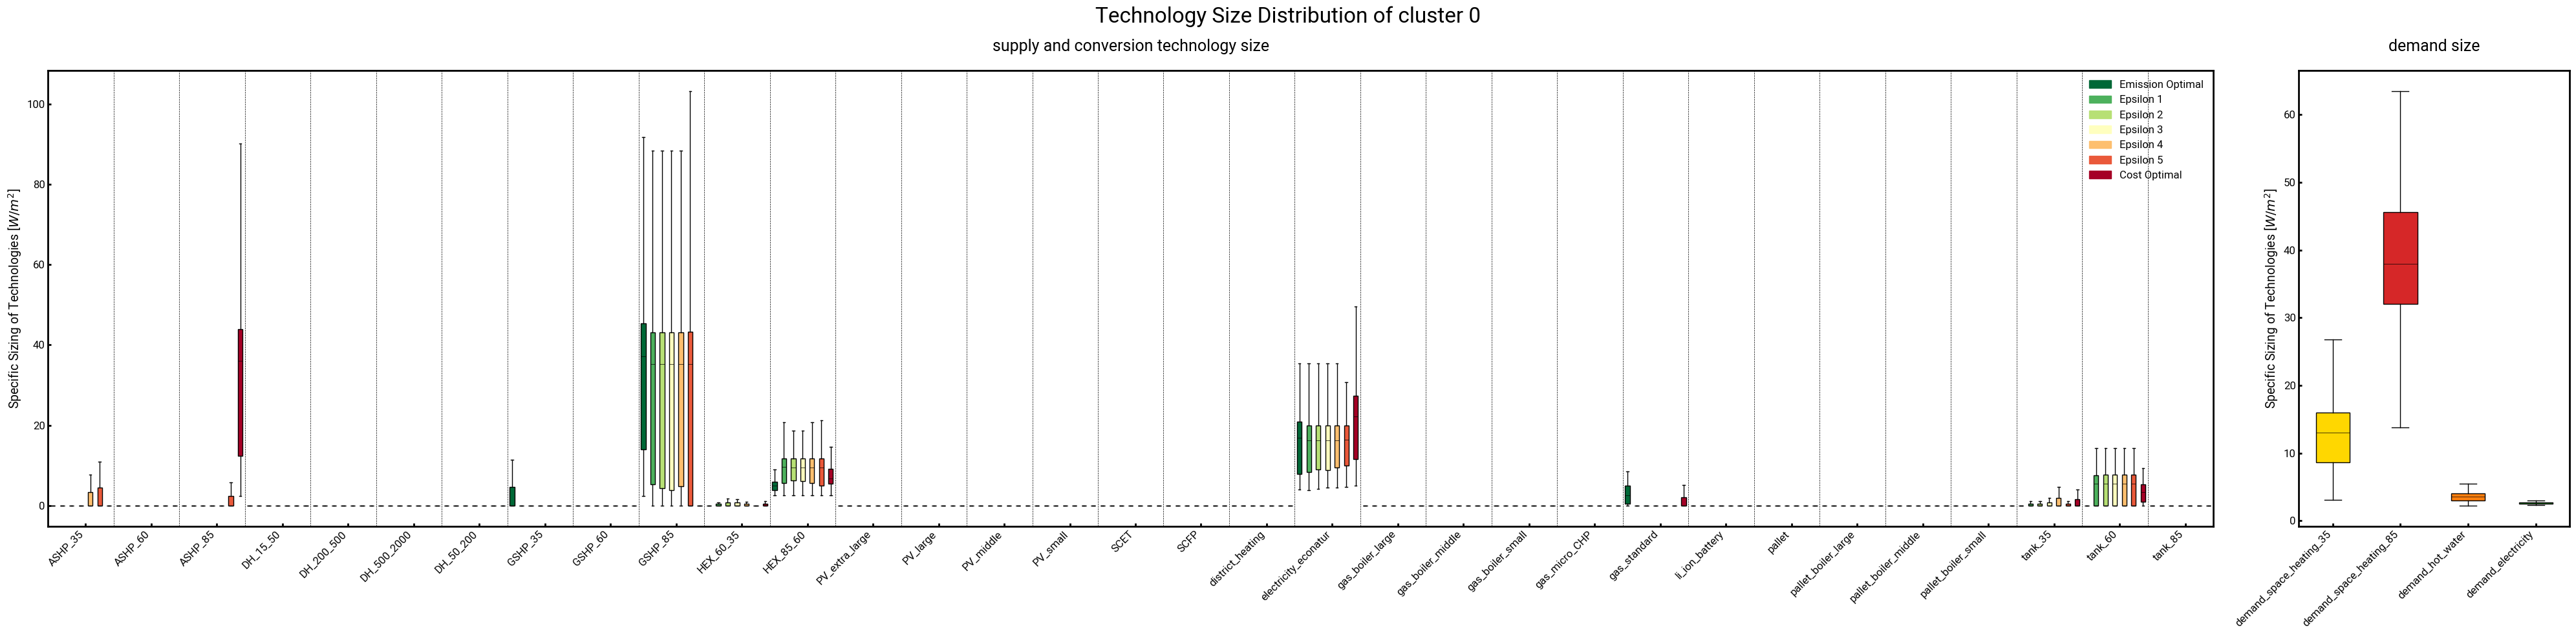

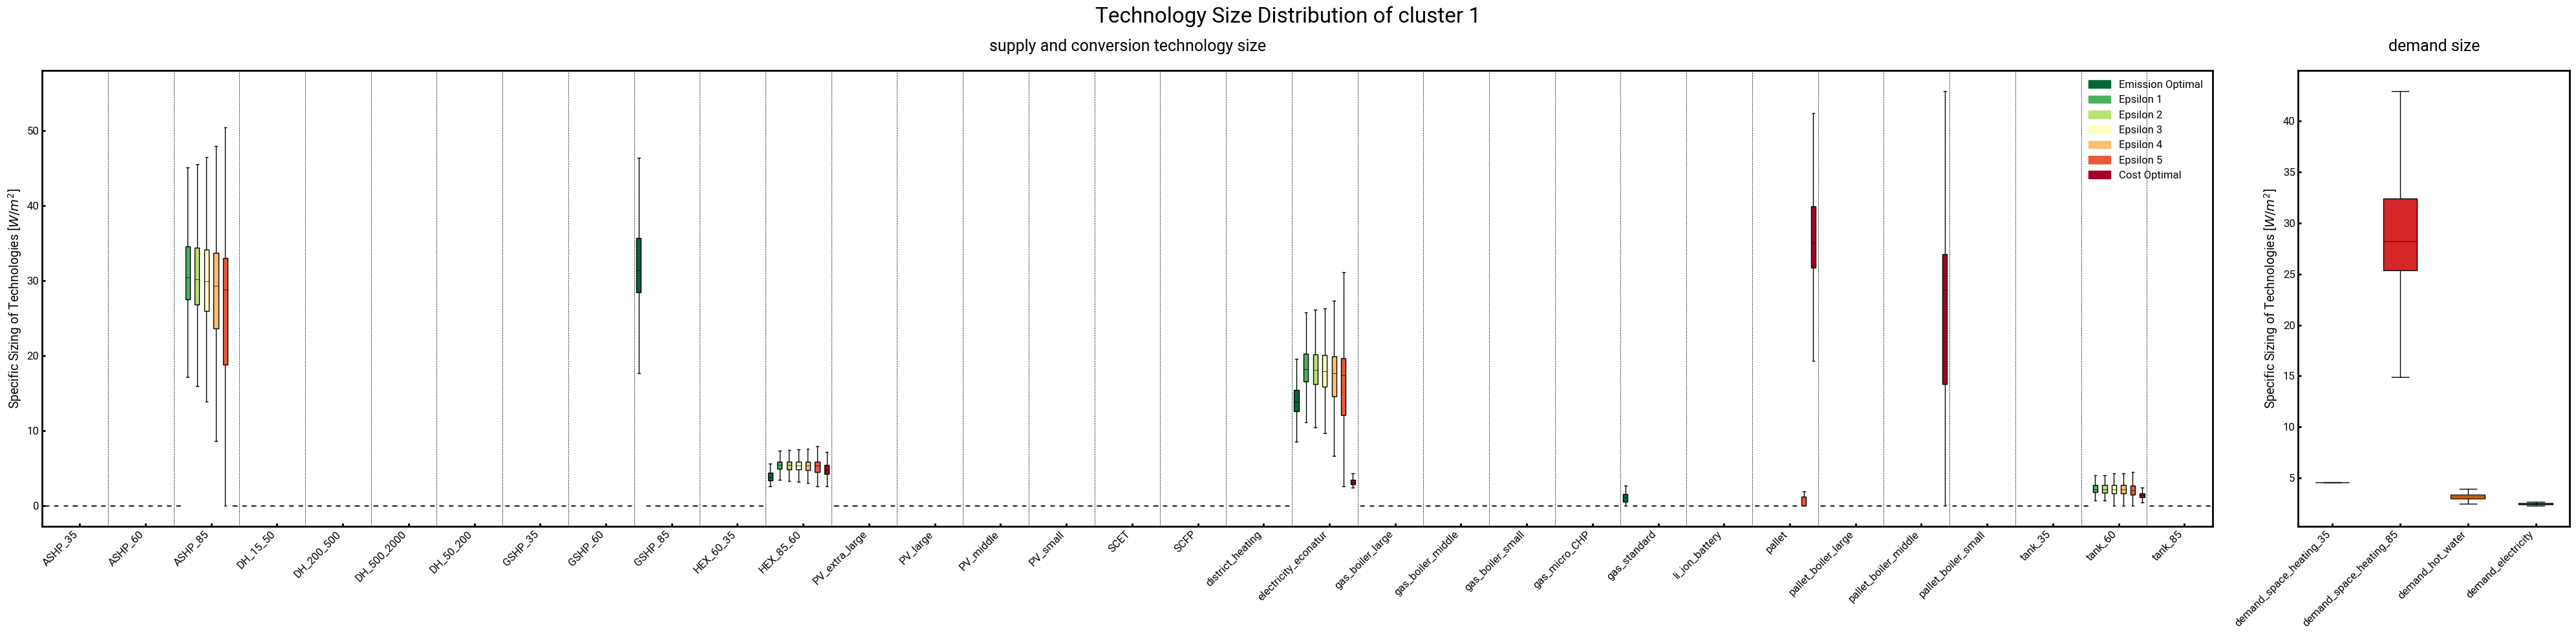

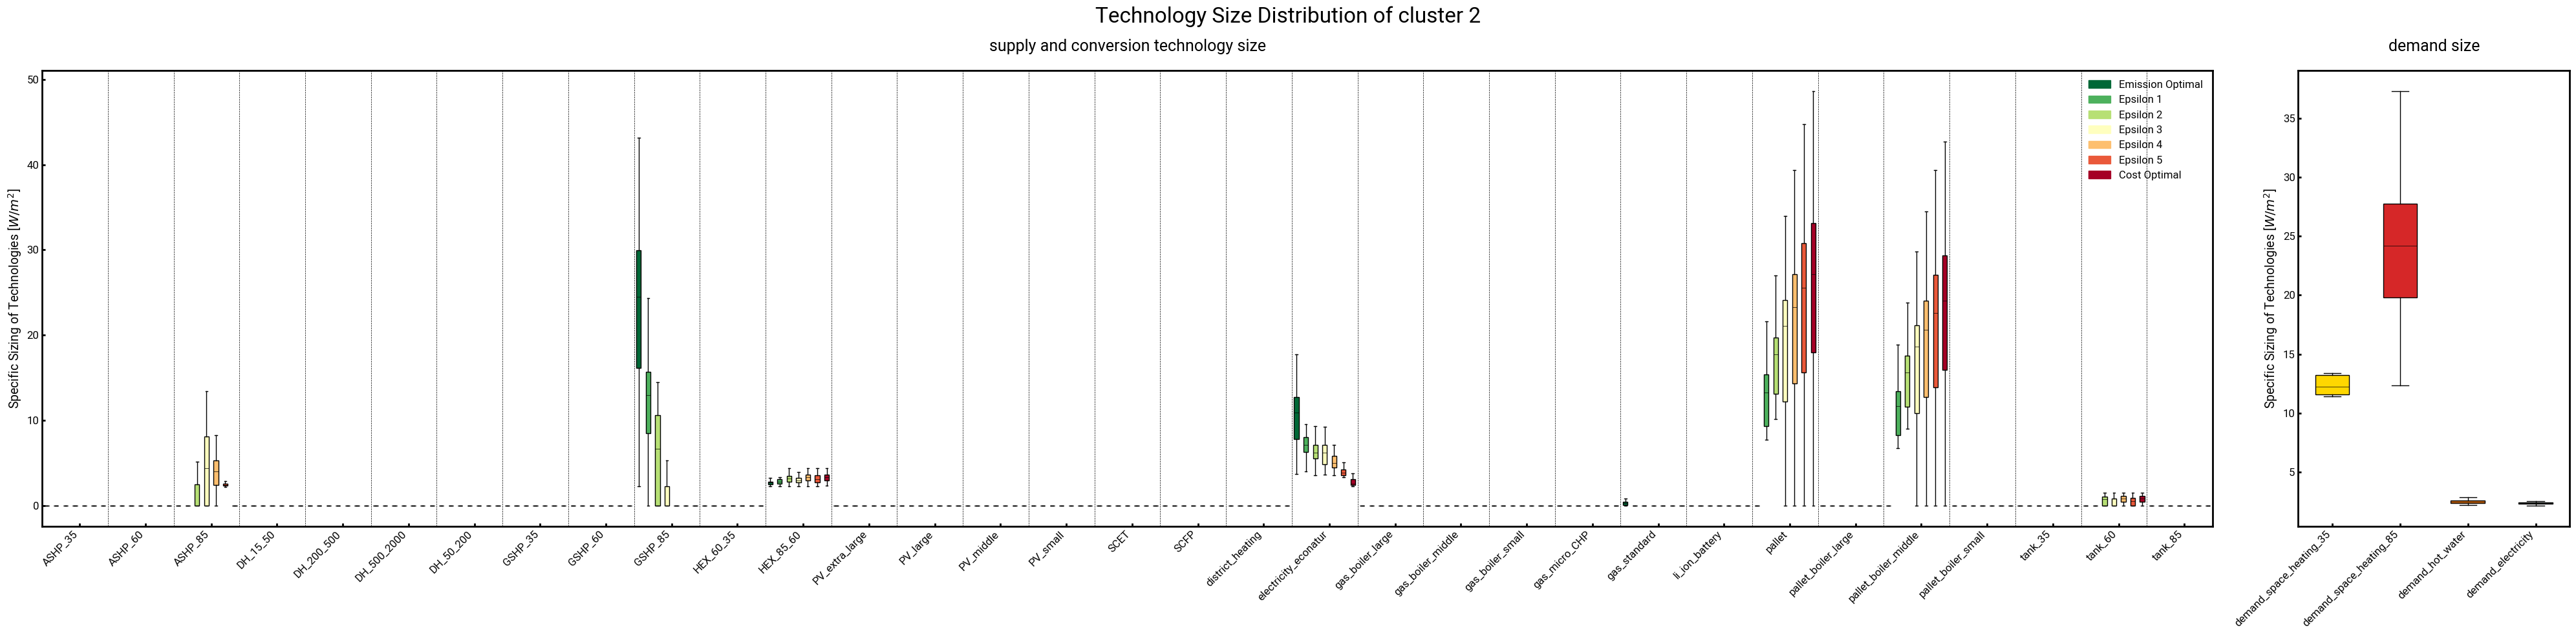

In [18]:
if with_oil:
    title_3 = "Pareto fronts of all buildings for scenario with oil"
else:
    title_3 = "Technology Size Distribution of all buildings"
tech_size_boxplot(
    df_pareto_all,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig=title_3,
    figsize=(40, 10),
    width_ratios=(8, 1),
)

df_pareto_0 = df_pareto_all[df_pareto_all["cluster"] == 0]
df_pareto_1 = df_pareto_all[df_pareto_all["cluster"] == 1]
df_pareto_2 = df_pareto_all[df_pareto_all["cluster"] == 2]

tech_size_boxplot(
    df_pareto_0,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Technology Size Distribution of cluster 0",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_1,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Technology Size Distribution of cluster 1",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_2,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Technology Size Distribution of cluster 2",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

### fig4: cost distribution stacked bar plot

In [19]:
tech_colors = {
    "ASHP_35": "#89CFF0",  # Light Blue
    "ASHP_60": "#5B92E5",  # Medium Blue
    "ASHP_85": "#2A57B7",  # Dark Blue
    "DH_15_50": "#FFB347",  # Soft Orange
    "DH_200_500": "#FF8C42",  # Vibrant Orange
    "DH_500_2000": "#FF5F1F",  # Dark Orange
    "DH_50_200": "#FFA07A",  # Salmon Orange
    "GSHP_35": "#98FB98",  # Pale Green
    "GSHP_60": "#32CD32",  # Lime Green
    "GSHP_85": "#228B22",  # Forest Green
    "HEX_60_35": "#DDA0DD",  # Light Purple
    "HEX_85_60": "#9932CC",  # Dark Purple
    "PV_extra_large": "#FFD700",  # Gold
    "PV_large": "#FFC300",  # Deep Yellow
    "PV_middle": "#FFA500",  # Orange-Yellow
    "PV_small": "#FFD580",  # Light Yellow
    "SCET": "#FFA07A",  # Salmon
    "SCFP": "#FF4500",  # Orange-Red
    "district_heating": "#FF6347",  # Tomato Red
    "electricity_econatur": "#00CED1",  # Dark Turquoise
    "gas_boiler_large": "#A52A2A",  # Brown
    "gas_boiler_middle": "#8B4513",  # Saddle Brown
    "gas_boiler_small": "#D2691E",  # Chocolate
    "gas_micro_CHP": "#CD853F",  # Peru
    "gas_standard": "#8B0000",  # Dark Red
    "li_ion_battery": "#708090",  # Slate Grey
    "oil": "#2F4F4F",  # Dark Slate Grey
    "oil_boiler_large": "#696969",  # Dim Grey
    "oil_boiler_middle": "#A9A9A9",  # Dark Grey
    "oil_boiler_small": "#D3D3D3",  # Light Grey
    "pallet": "#DEB887",  # Burlywood
    "pallet_boiler_large": "#BC8F8F",  # Rosy Brown
    "pallet_boiler_middle": "#F4A460",  # Sandy Brown
    "pallet_boiler_small": "#DAA520",  # Goldenrod
    "tank_35": "#4682B4",  # Steel Blue
    "tank_60": "#5F9EA0",  # Cadet Blue
    "tank_85": "#2E8B57",  # Sea Green
}

In [20]:
# empty_cost_per_tech = df_cost_per_tech_all.copy()

# for i in decision_df.columns:
#     # now this is one column with the building names as index and pareto indices as value
#     # we want to transfer this to a multiindex series to query for the df_cost_per_tech_all
#     empty_cost_per_tech[:] = 0
#     decision = decision_df[i]
#     cost_types = list(df_cost_per_tech_all.index.get_level_values(2).unique())
#     query = pd.MultiIndex.from_tuples(
#         [
#             (building, decision[building], cost_type)
#             for building in decision.index
#             for cost_type in cost_types
#         ],
#         names=["building", "pareto_index", "cost_type"],
#     )
#     idx = pd.IndexSlice
#     buildings = decision_df.index
#     pareto_indices = decision_df[i].values.astype(int).flatten()
#     areas = zone_df.loc[buildings, "area"].values
#     repeated_areas = np.repeat(areas, len(cost_types))
#     cost_per_tech_decision = df_cost_per_tech_all.loc[query, :].multiply(
#         repeated_areas, axis=0
#     )
#     empty_cost_per_tech += cost_per_tech_decision

#     fig = tech_cost_stackedbar(
#         empty_cost_per_tech,
#         tech_colors,
#         title=f"Technology cost at decision {i}",
#         figsize=(12, 10),
#         relative=False,
#         monetary_lim=(0, 3.2e7),
#         co2_lim=(0, 4.5e6),
#     )
#     fig = plt.gcf()
#     fig.savefig(f"{i}.png")

In [21]:
per_tech_cost_0_dict = {}
per_tech_cost_1_dict = {}
per_tech_cost_2_dict = {}
for building_name, row in zone_df.iterrows():
    df_cost_per_tech = cost_per_tech_dict.get(building_name)
    if df_cost_per_tech is None:
        continue
    cluster = zone_df.loc[building_name, "cluster"]
    df_cost_per_tech.drop(
        columns=[
            "demand_space_heating_35",
            "demand_space_heating_60",
            "demand_space_heating_85",
            "demand_space_cooling",
            "demand_hot_water",
            "demand_electricity",
        ],
        inplace=True,
    )
    if cluster == 0:
        per_tech_cost_0_dict[building_name] = df_cost_per_tech
    elif cluster == 1:
        per_tech_cost_1_dict[building_name] = df_cost_per_tech
    else:
        per_tech_cost_2_dict[building_name] = df_cost_per_tech
df_cost_per_tech_0 = pd.concat(per_tech_cost_0_dict.values())
df_cost_per_tech_1 = pd.concat(per_tech_cost_1_dict.values())
df_cost_per_tech_2 = pd.concat(per_tech_cost_2_dict.values())

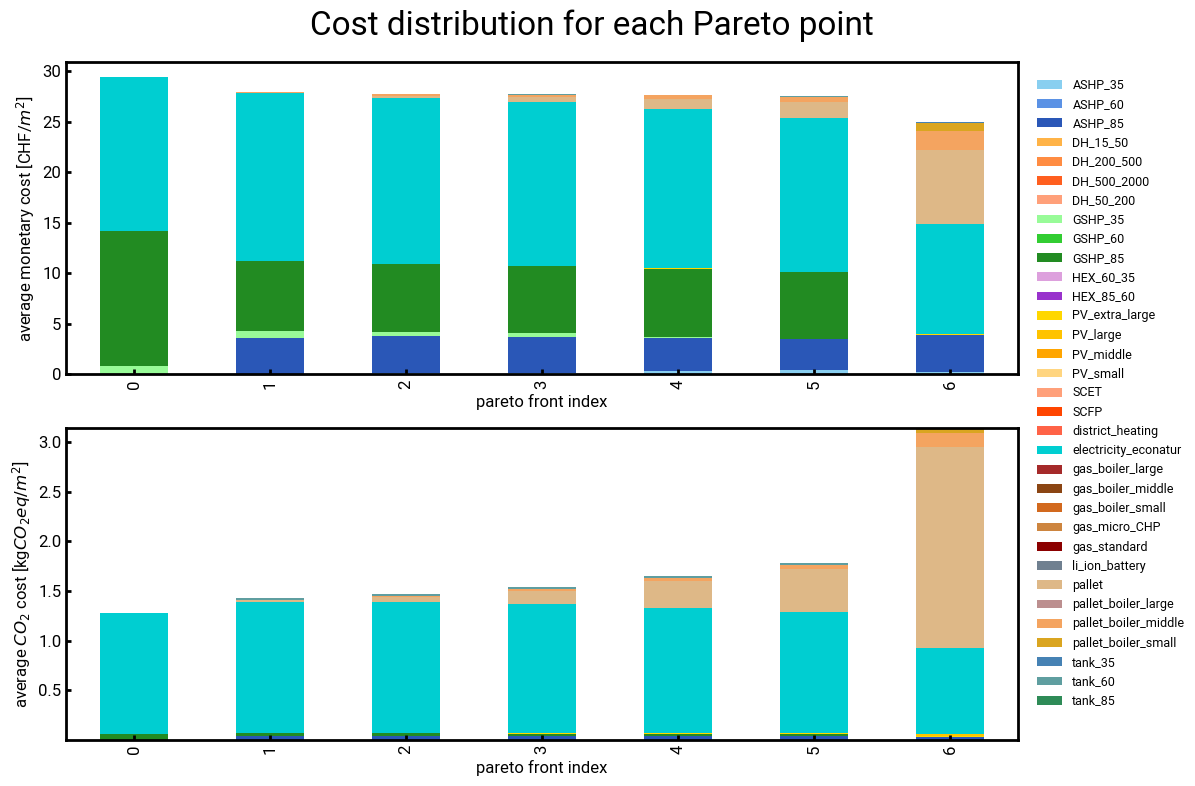

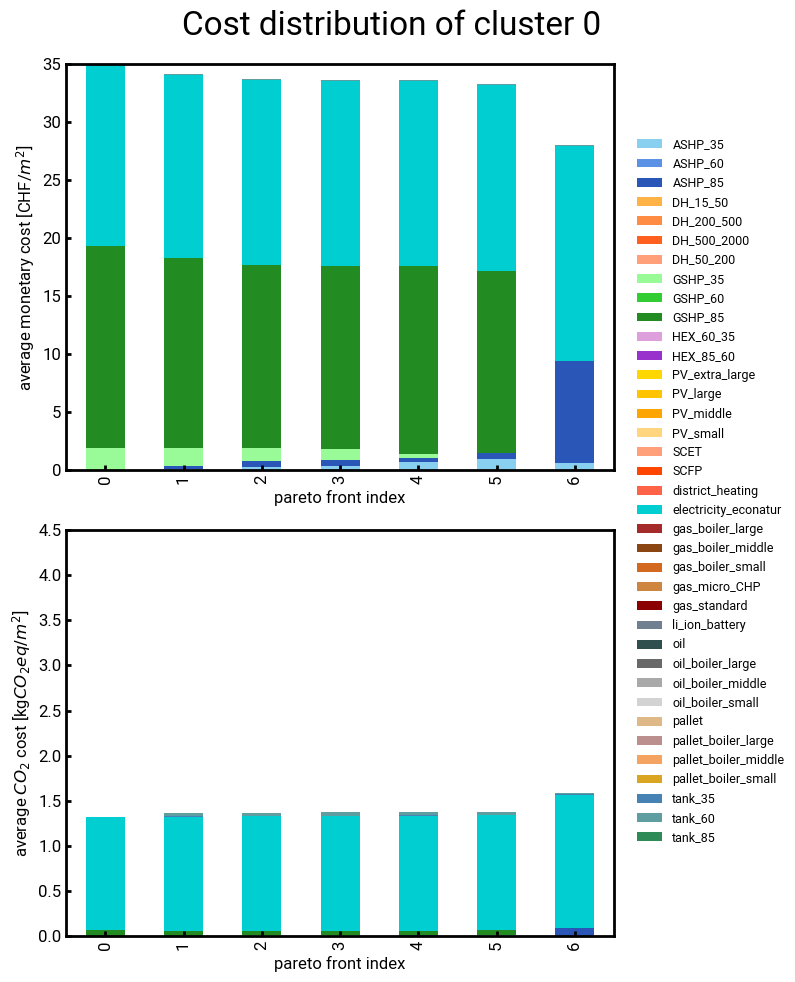

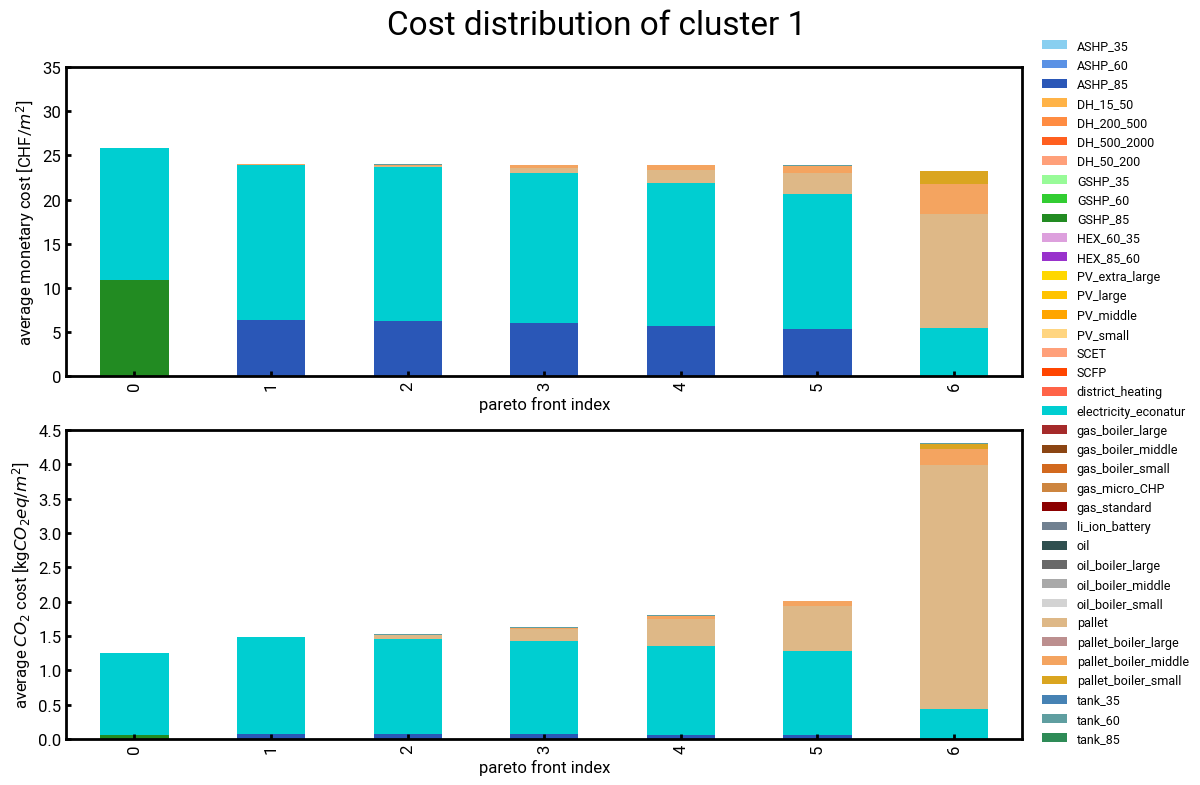

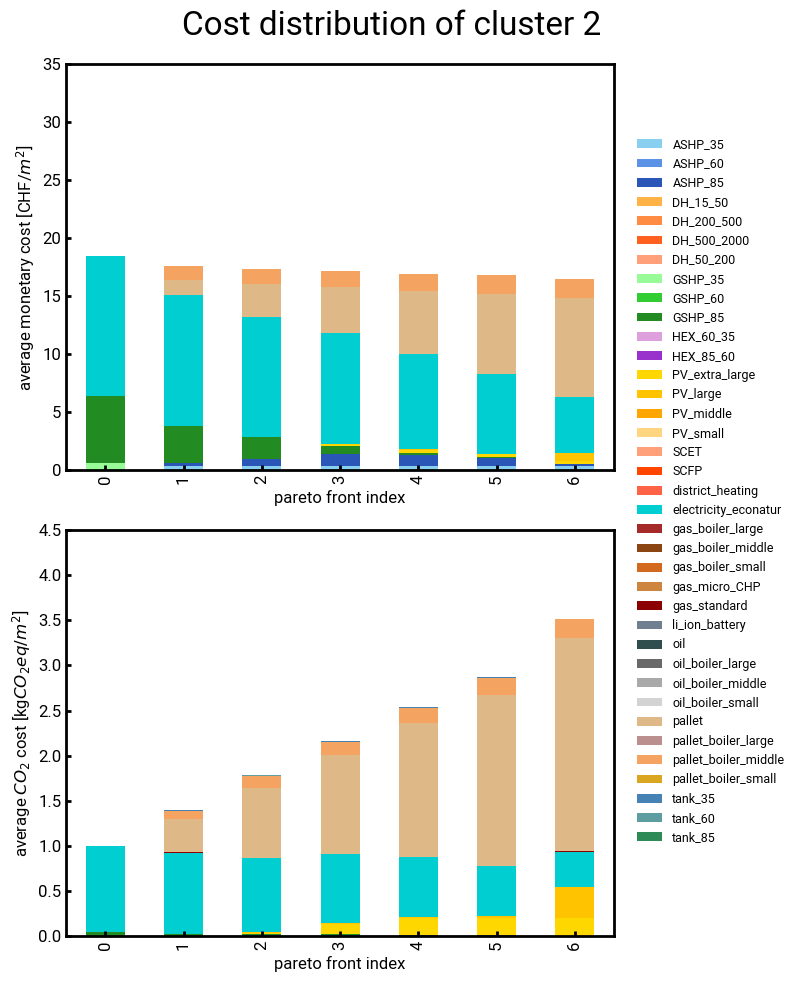

In [55]:
fig = tech_cost_stackedbar(
    df_cost_per_tech_all,
    tech_colors,
    title="Cost distribution for each Pareto point",
    figsize=(12, 8),
)
fig.tight_layout(rect=[0, 0, 0.87, 1])
fig = tech_cost_stackedbar(
    df_cost_per_tech_0,
    tech_colors,
    title="Cost distribution of cluster 0",
    figsize=(8, 10),
)
axes = fig.get_axes()
axes[0].set_ylim(0, 35)
axes[1].set_ylim(0, 4.5)
fig.tight_layout(rect=[0, 0, 0.8, 1])
fig = tech_cost_stackedbar(
    df_cost_per_tech_1,
    tech_colors,
    title="Cost distribution of cluster 1",
    figsize=(12, 8),
)
axes = fig.get_axes()
axes[0].set_ylim(0, 35)
axes[1].set_ylim(0, 4.5)
fig.tight_layout(rect=[0, 0, 0.87, 1])
fig = tech_cost_stackedbar(
    df_cost_per_tech_2,
    tech_colors,
    title="Cost distribution of cluster 2",
    figsize=(8, 10),
)
axes = fig.get_axes()
axes[0].set_ylim(0, 35)
axes[1].set_ylim(0, 4.5)
fig.tight_layout(rect=[0, 0, 0.8, 1])

### fig5: tech size and cost distribution, but for collided pareto points

In [23]:
# identify collided points
df_pareto_collided_only = df_pareto_all[
    df_pareto_all.duplicated(subset=["emission", "cost"], keep=False)
]
df_pareto_collided = df_pareto_all.copy()
df_pareto_collided.loc[:, :] = 0
df_pareto_collided.loc[df_pareto_collided_only.index, :] = df_pareto_collided_only

df_cost_index_two_level = df_cost_per_tech_all.index.droplevel(2)
mask = df_cost_index_two_level.isin(df_pareto_collided_only.index)
df_cost_per_tech_collided_only = df_cost_per_tech_all[mask]

df_cost_per_tech_collided = df_cost_per_tech_all.copy()
df_cost_per_tech_collided.loc[:, :] = 0
df_cost_per_tech_collided.loc[df_cost_per_tech_collided_only.index, :] = (
    df_cost_per_tech_collided_only
)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


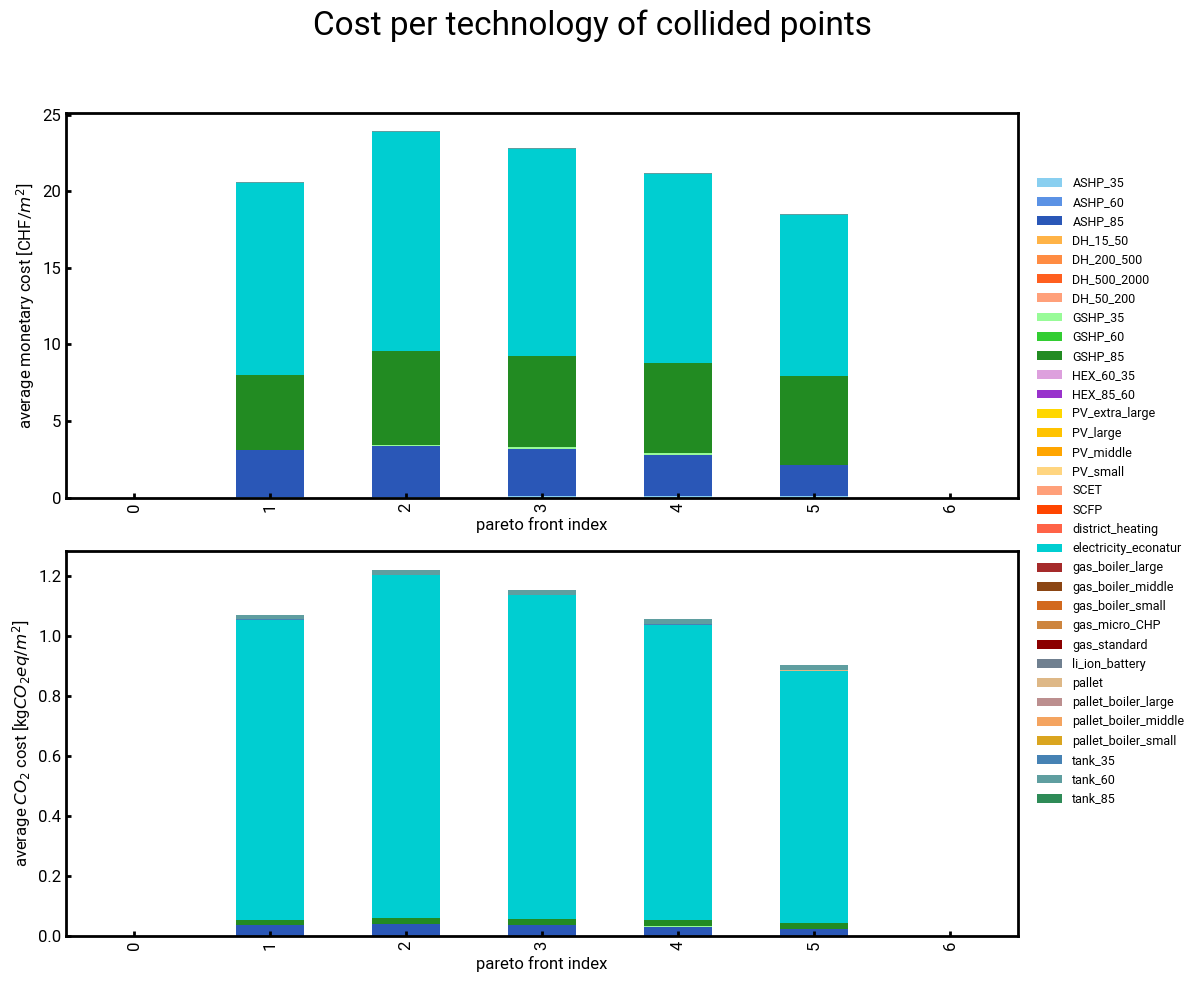

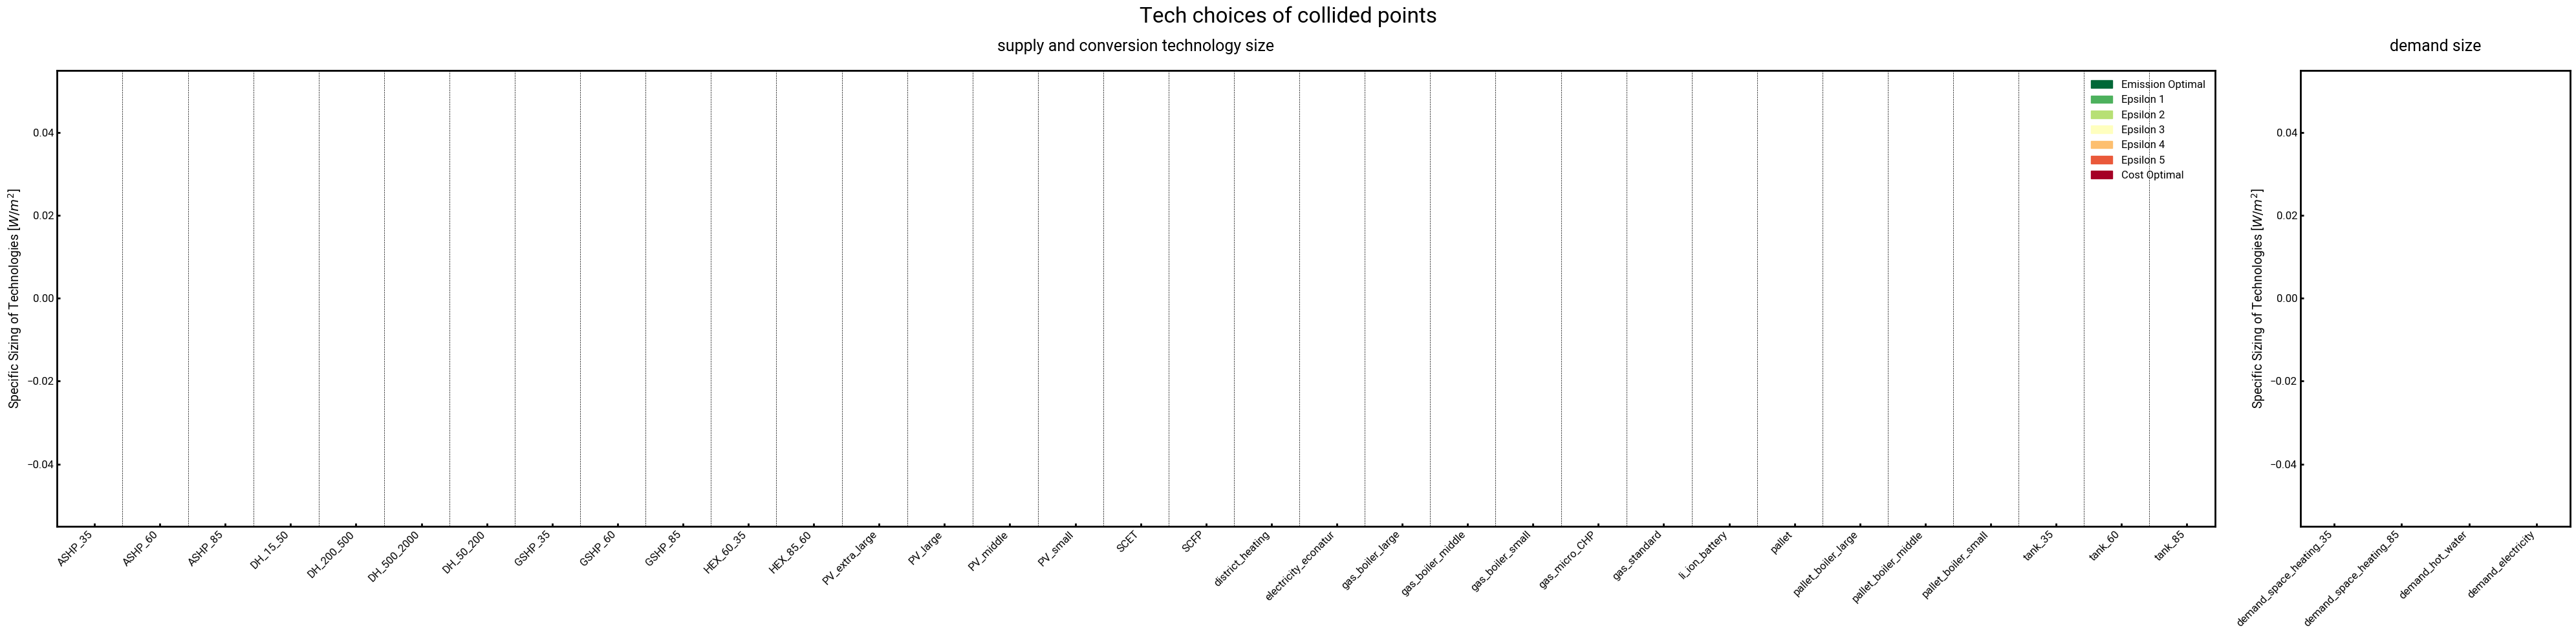

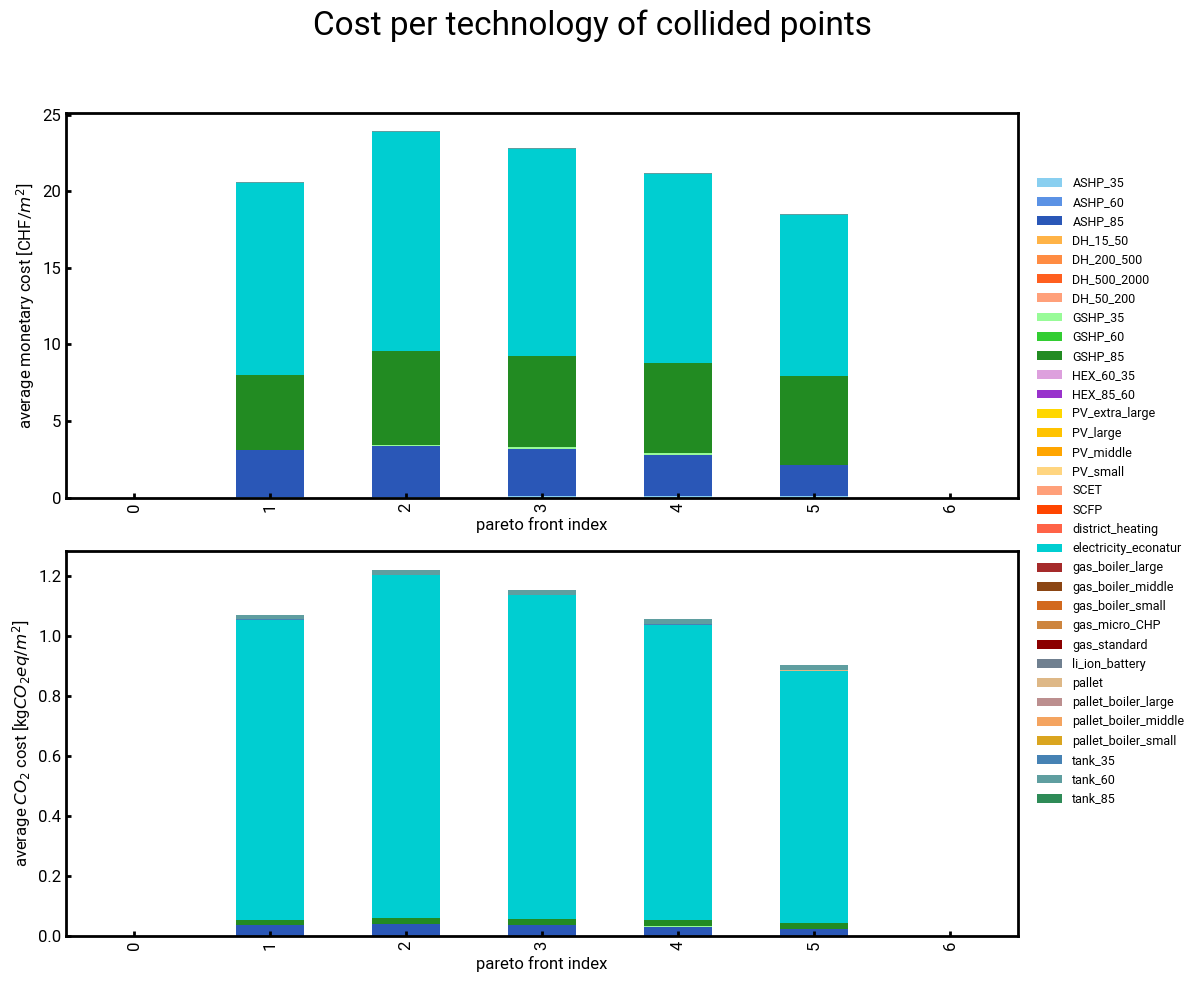

In [24]:
tech_size_boxplot(
    df_pareto_collided,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Tech choices of collided points",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_cost_stackedbar(
    df_cost_per_tech_collided,
    tech_colors,
    title="Cost per technology of collided points",
    figsize=(12, 10),
)

# Data Analysis

## explain clustering in fig2

In [25]:
data = zone_df.copy()
columns_drop = [
    "shadow_price",
    "pf_curvature",
    "emission_range_abs",
    "cost_range",
    "emission_range_rel",
    "selected_invest_count",
    "selected_invest_cost",
    "inv_shadow_price",
    "log_shadow_price",
    # "peak_space_heating_demand",
    # "demand_space_heating_intensity",
    # "demand_hot_water_intensity",
    # "demand_electricity_intensity",
    # "area",
    # "type_ctrl",
    # "YEAR",
    # "compactness",
    # "floors_ag",
    # "elongation",
    # "concavity",
    # "direction",
    # "type_vent",
    # "is_dh",
    # "type_hs",
    # "shape_factor",
]


label_encoders = {}
for col in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data.drop(
    columns=columns_drop,
    inplace=True,
)

In [26]:
x = data.drop(columns=["cluster"])
y = data["cluster"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)
clf_shadow_price = RandomForestClassifier(random_state=42)
clf_shadow_price.fit(x_train, y_train)

r2_train = clf_shadow_price.score(x_train, y_train)
mse_train = mean_squared_error(y_train, clf_shadow_price.predict(x_train))
r2_test = clf_shadow_price.score(x_test, y_test)
mse_test = mean_squared_error(y_test, clf_shadow_price.predict(x_test))
print(
    f"R2 score on training set: {r2_train}, MSE: {mse_train}; on test set: {r2_test}, MSE: {mse_test}"
)
y_pred = clf_shadow_price.predict(x_test)
print(classification_report(y_test, y_pred))

R2 score on training set: 1.0, MSE: 0.0; on test set: 0.9919354838709677, MSE: 0.008064516129032258
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       201
         1.0       0.99      0.99      0.99       273
         2.0       1.00      0.95      0.98        22

    accuracy                           0.99       496
   macro avg       0.99      0.98      0.99       496
weighted avg       0.99      0.99      0.99       496



### using SHAP to explain the clustering

In [27]:
# use SHAP to explain the model
# clf = RandomForestClassifier(random_state=42)
# clf.fit(x, y)
explainer = shap.TreeExplainer(clf_shadow_price)
shap_values = explainer.shap_values(x)

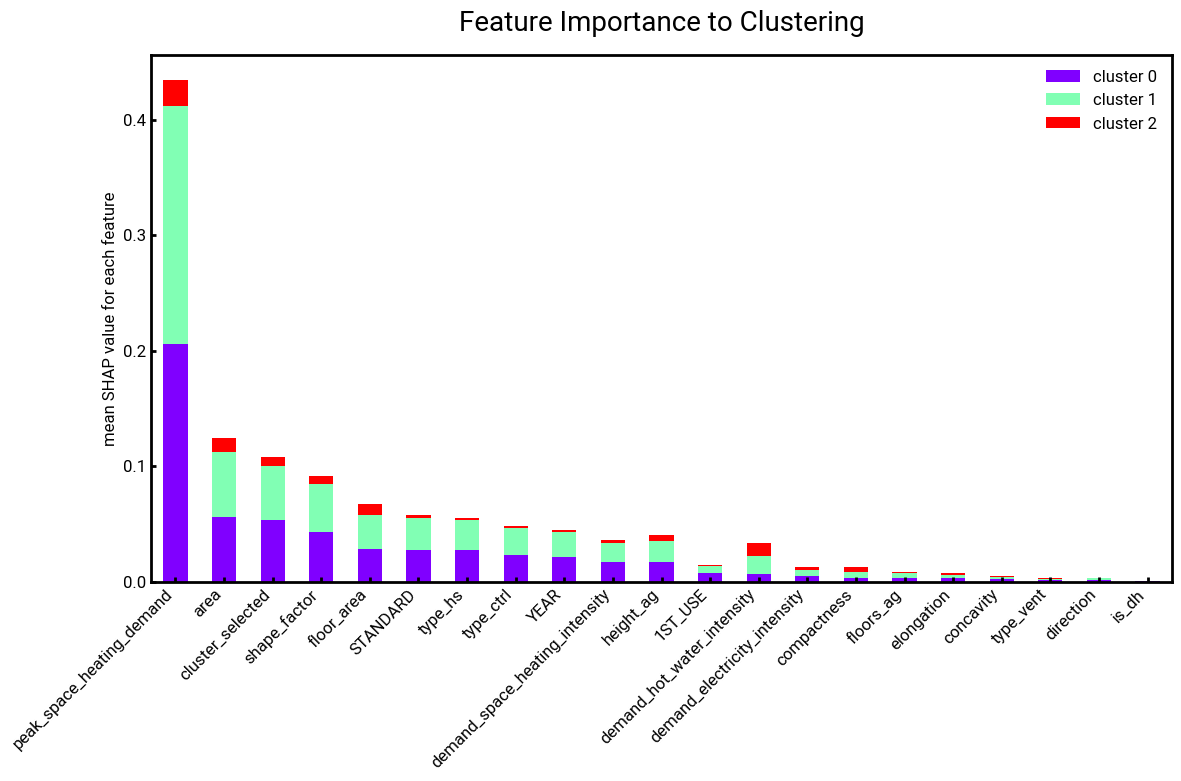

In [28]:
# shap value is a three-dimentional array, the first is the number of clusters, second being the builidngs and third being the features.
# we need to generate a df with rows being the features and columns being the clusters, each entry should be the average of absolute shap value of the feature in the cluster
shap_values_abs = np.abs(shap_values)
shap_values_abs_avg = shap_values_abs.mean(axis=1)
shap_values_abs_avg = pd.DataFrame(shap_values_abs_avg, columns=x.columns)
shap_values_abs_avg = shap_values_abs_avg.T
shap_values_abs_avg.columns = ["cluster 0", "cluster 1", "cluster 2"]
shap_values_abs_avg.sort_values(by="cluster 0", ascending=False, inplace=True)

# plot a stacked bar plot to show the shap values of each feature in each cluster. Each column represent a feature, and values in clusters stacke on top of each other.
# legend should draw different colors for each cluster
fig, ax = plt.subplots(figsize=(12, 8))
shap_values_abs_avg.plot(kind="bar", stacked=True, ax=ax, colormap="rainbow")
ax.set_ylabel("mean SHAP value for each feature")
# ax.set_xlabel("Feature")
# set x axis label to be 45 degree
plt.xticks(rotation=45, ha="right")
ax.set_title("Feature Importance to Clustering", fontsize=20)
plt.tight_layout()

In [ ]:
for col in x.columns:
    shap.dependence_plot(col, shap_values[1], x, display_features=zone_df)

The palette list has more values (1651) than needed (2), which may not be intended.


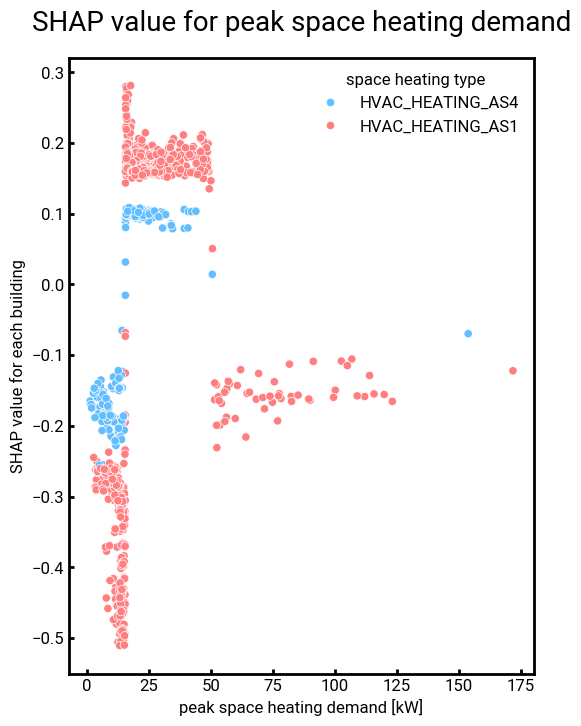

In [30]:
# shap.summary_plot(shap_values, x_test)
# shap.plots.beeswarm(shap_values)

# shap.dependence_plot(
#     "peak_space_heating_demand",
#     shap_values[1],
#     x,
#     # interaction_index="1ST_USE",
#     display_features=zone_df,
#     show=False,
# )
# # shap.dependence_plot(
# #     "1ST_USE",
# #     shap_values[1],
# #     x,
# #     interaction_index="shape_factor",
# #     display_features=zone_df,
# # )
# # limit x range from 0 to 3000
# # plt.xlim(0, 1000)
# # plt.show()
# # for tech in data.columns:
# #     shap.dependence_plot(tech, shap_values[1], x, show=False, display_features=x_display)
# #     # set title for each plot
# #     plt.title(tech)
# # set x axis to be log scale
# # plt.xscale("symlog")
# plt.xlim(1, 30)
# plt.show()
color_dict = {"HVAC_HEATING_AS1": "#ff7f81", "HVAC_HEATING_AS4": "#62beff"}
data = zone_df.copy()
shap_values_1 = pd.DataFrame(shap_values[1], columns=x.columns)
data["peak_space_heating_demand_value_1"] = shap_values_1[
    "peak_space_heating_demand"
].values
fig, ax = plt.subplots(figsize=(6, 8))
sns.scatterplot(
    data=data,
    x="peak_space_heating_demand",
    y="peak_space_heating_demand_value_1",
    hue="type_hs",
    ax=ax,
    palette=[color_dict[cat] for cat in data["type_hs"]],
)
ax.set_xlabel("peak space heating demand [kW]")
ax.set_ylabel("SHAP value for each building")
ax.set_title("SHAP value for peak space heating demand", fontsize=20)
ax.legend(loc="best", title="space heating type")
plt.show()

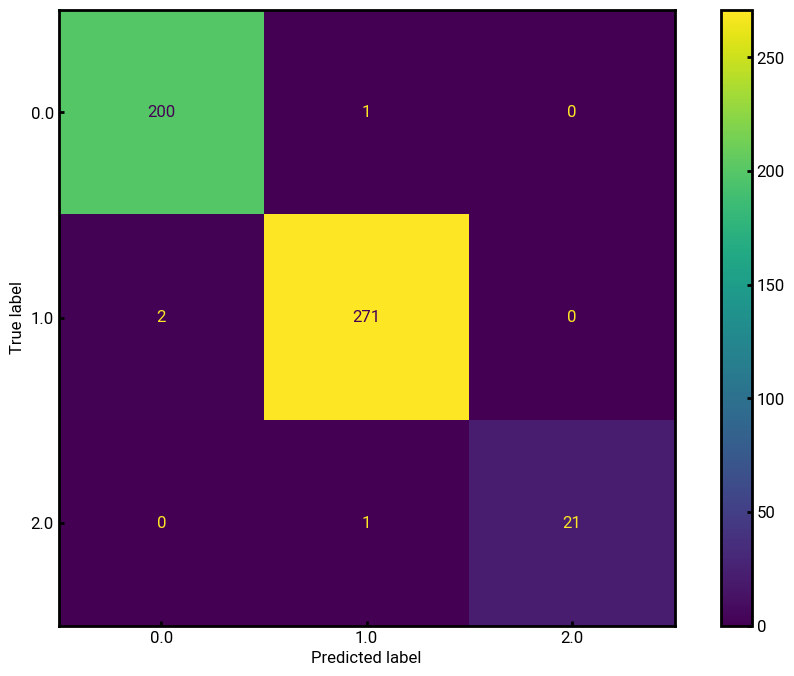

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=clf_shadow_price.classes_
)
disp.plot()
plt.show()

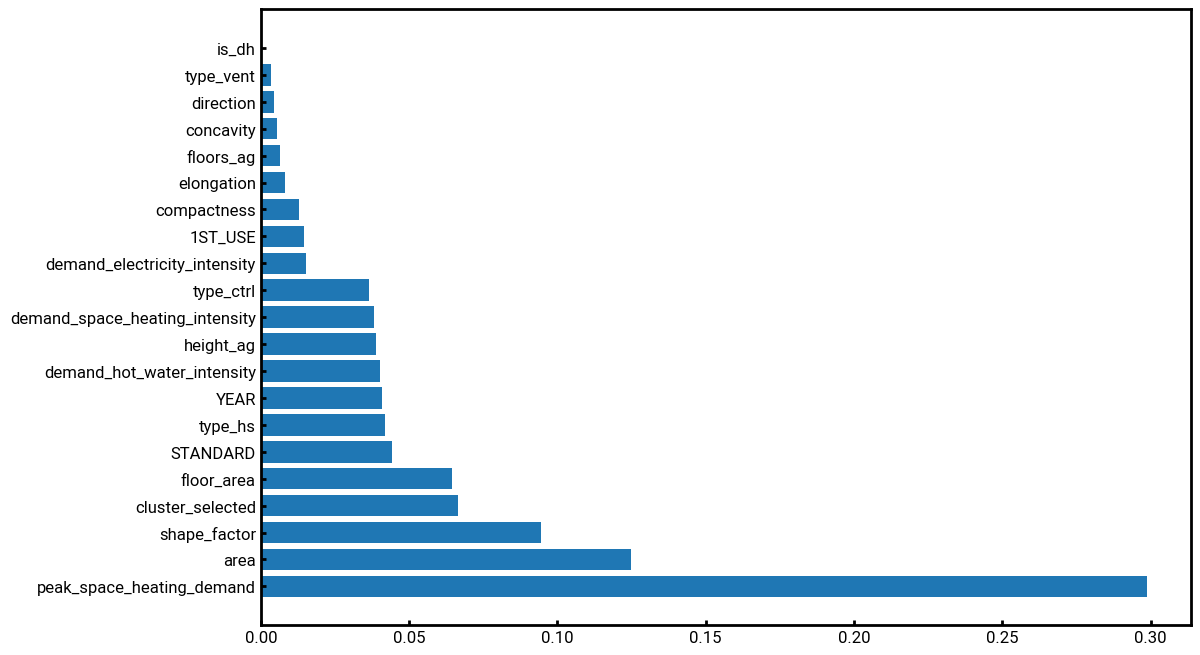

In [32]:
feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": clf_shadow_price.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

In [33]:
cv_scores = cross_val_score(clf_shadow_price, x, y, cv=5, scoring="accuracy")
print(f"Cv scores mean: {cv_scores.mean():.2f}, std: {cv_scores.std():.2f}")

Cv scores mean: 0.99, std: 0.00


In [ ]:
shap_interaction_values_clustering = shap.TreeExplainer(
    clf_shadow_price
).shap_interaction_values(x)

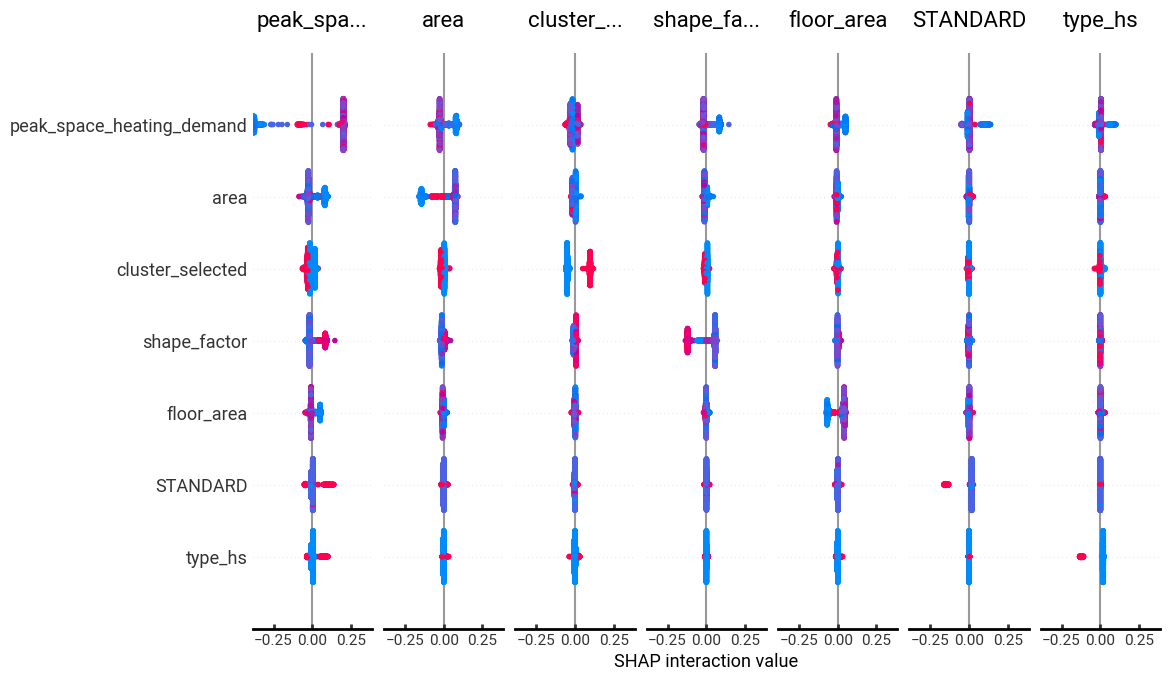

In [35]:
shap.summary_plot(shap_interaction_values_clustering[1], x)

In [ ]:
shap_interaction_values_clustering_arr_1 = np.array(
    shap_interaction_values_clustering[1]
)
print(shap_interaction_values_clustering_arr_1[:, 19, 11].shape)

data["peak_demand_1st_use"] = shap_interaction_values_clustering_arr_1[:, 19, 11]

fig, ax = plt.subplots(figsize=(6, 8))
color_dict = {"SINGLE_RES": "#ff81b7", "MULTI_RES": "#2be69f"}
data["1ST_USE"] = data["1ST_USE"].astype("category")
colors = [color_dict[cat] for cat in data["1ST_USE"]]
sns.scatterplot(
    data=data,
    x="peak_space_heating_demand",
    y="peak_demand_1st_use",
    hue="1ST_USE",
    ax=ax,
    palette=["#ff81b7", "#2be69f"],
)
ax.set_xlabel("peak space heating demand [kW]")
ax.set_ylabel("SHAP interaction value with use type for each building")
ax.set_title("SHAP interaction value with use type", fontsize=20)
ax.legend(loc="best", title="Building use type")

In [ ]:
for col in x.columns:
    shap.dependence_plot(
        ("peak_space_heating_demand", col),
        shap_interaction_values_clustering[1],
        x,
        display_features=zone_df,
    )

## explain distribution of second cluster in fig2

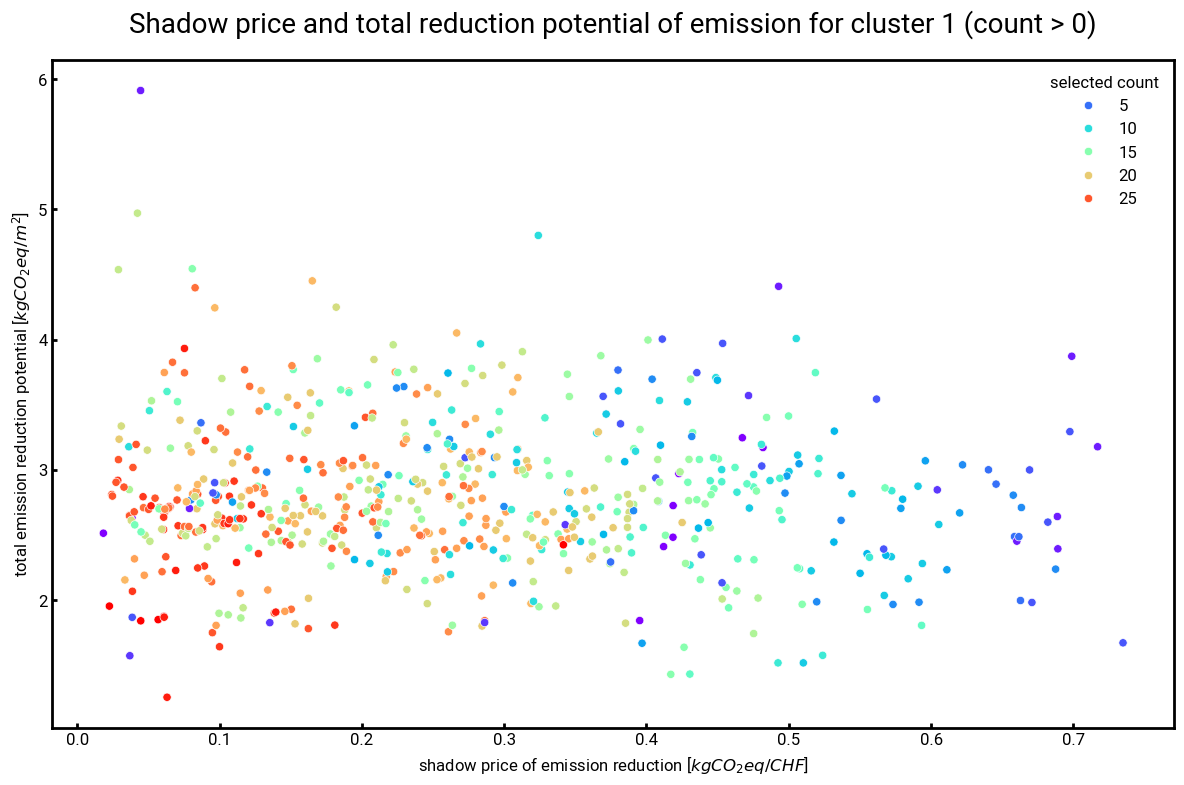

In [7]:
cluster_1 = zone_df[zone_df["cluster"] == 1]
# plot the relative emission reduction potential vs shadow price
fig, ax = plt.subplots(figsize=(12, 8))

# selecte buildings that has been selected for additional investment, or cost > 0
cluster_1_special = cluster_1[cluster_1["selected_invest_cost"] > 0]
cluster_1_special_2 = cluster_1.copy()
cluster_1_special_2["shadow_price"] = 1 / cluster_1_special_2["shadow_price"]

sns.scatterplot(
    data=cluster_1_special,
    x="shadow_price",
    y="emission_range_abs",
    hue="selected_invest_count",
    palette="rainbow",
    # color="#f76e6e",
    ax=ax,
    # hue_norm=(0, 2500),
)
ax.set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
ax.set_ylabel("total emission reduction potential [$kgCO_2eq/m^2$]")
ax.set_title(
    "Shadow price and total reduction potential of emission for cluster 1 (count > 0)",
    fontsize=20,
)
ax.legend(loc="best", title="selected count")
# ax.set_xlim(1, 100)
# ax.set_ylim(0.5, 0.7)
# set x axis to be log scale
# plt.xscale("log")
# ax.set_xlim(0, 50)
fig.tight_layout()
plt.show()

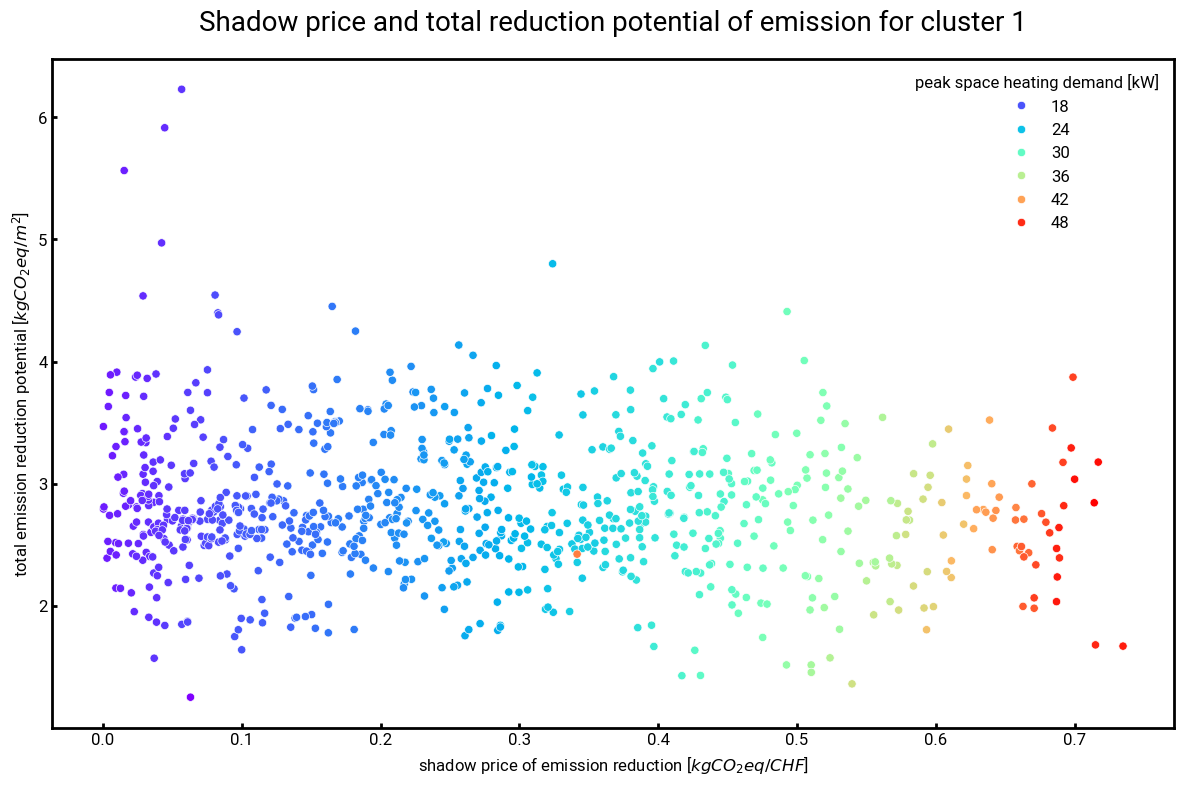

In [8]:
cluster_1 = zone_df[zone_df["cluster"] == 1]
# plot the relative emission reduction potential vs shadow price
fig, ax = plt.subplots(figsize=(12, 8))

# selecte buildings that has been selected for additional investment, or cost > 0
cluster_1_special = cluster_1[cluster_1["selected_invest_cost"] > 0]
cluster_1_special_2 = cluster_1.copy()
cluster_1_special_2["shadow_price"] = 1 / cluster_1_special_2["shadow_price"]

sns.scatterplot(
    data=cluster_1,
    x="shadow_price",
    y="emission_range_abs",
    hue="peak_space_heating_demand",
    palette="rainbow",
    # color="#f76e6e",
    ax=ax,
    # hue_norm=(0, 2500),
)
ax.set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
ax.set_ylabel("total emission reduction potential [$kgCO_2eq/m^2$]")
ax.set_title(
    "Shadow price and total reduction potential of emission for cluster 1", fontsize=20
)
ax.legend(loc="best", title="peak space heating demand [kW]")
# ax.set_xlim(1, 100)
# ax.set_ylim(0.5, 0.7)
# set x axis to be log scale
# plt.xscale("log")
# ax.set_xlim(0, 50)
fig.tight_layout()
plt.show()

### random forest for shadow price

0.9988168305581595
0.9986471245982572
4.574900568081385e-05 0.9986471245982572


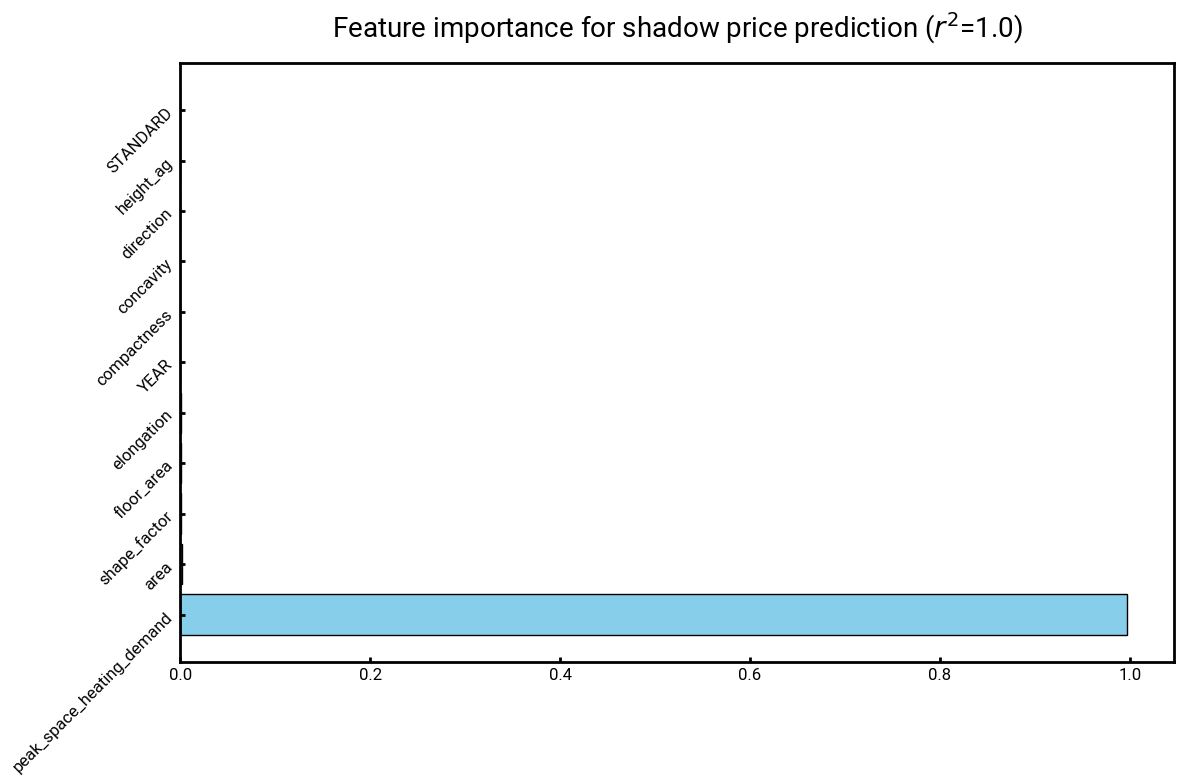

In [9]:
cluster_1_tree = cluster_1.copy()
for col in cluster_1_tree.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    cluster_1_tree[col] = le.fit_transform(cluster_1_tree[col])

x = cluster_1_tree.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "selected_invest_count",
        "selected_invest_cost",
        "cluster",
        # "peak_space_heating_demand",
        "demand_space_heating_intensity",
        "demand_hot_water_intensity",
        "demand_electricity_intensity",
        "inv_shadow_price",
        "log_shadow_price",
        "cluster_selected",
        # "area",
        # "floor_area",
        "type_ctrl",
        # # "YEAR",
        # "STANDARD",
        # "compactness",
        # "height_ag",
        "1ST_USE",
        "floors_ag",
        # "elongation",
        # "concavity",
        # "direction",
        "type_vent",
        "is_dh",
        "type_hs",
        # "shape_factor",
    ]
)
y = cluster_1_tree["shadow_price"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)
clf_shadow_price = RandomForestRegressor(random_state=42)
clf_shadow_price.fit(x_train, y_train)
print(clf_shadow_price.score(x_train, y_train))
print(clf_shadow_price.score(x_test, y_test))
y_pred = clf_shadow_price.predict(x_test)
print(mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))

feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": clf_shadow_price.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    feature_importance["feature"],
    feature_importance["importance"],
    color="skyblue",
    edgecolor="black",
)
plt.yticks(rotation=45, ha="right")
plt.title(
    f"Feature importance for shadow price prediction ($r^2$={round(r2_score(y_test, y_pred), 2)})",
    fontsize=20,
)
plt.tight_layout()
plt.show()

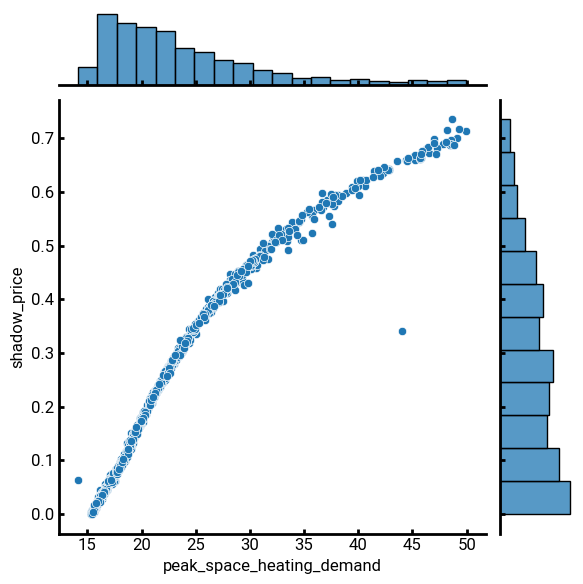

In [ ]:
# exclude building area that is larger than 2800 m2
# cluster_1_area_plotting = cluster_1_tree[cluster_1_tree["area"] < 2800]
sns.jointplot(
    data=cluster_1_tree, x="peak_space_heating_demand", y="shadow_price", kind="scatter"
)

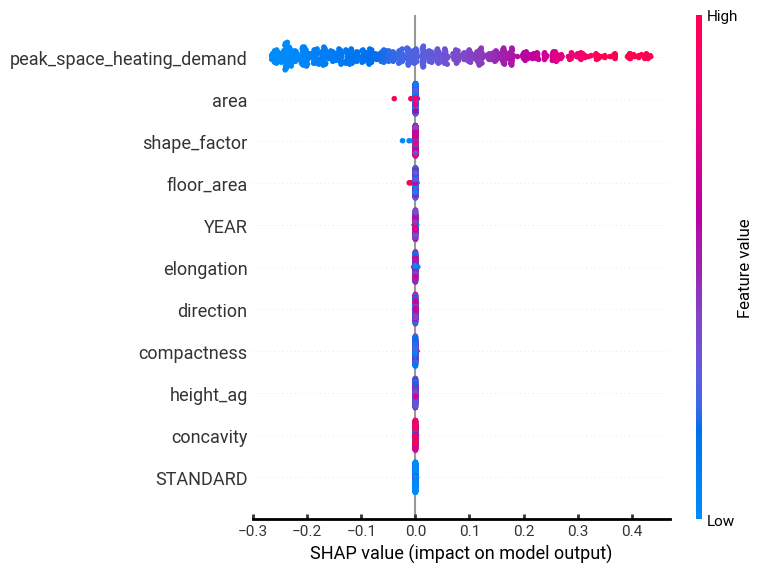

In [41]:
# use shap to explain the shadow price model
explainer = shap.TreeExplainer(clf_shadow_price)
shap_values = explainer.shap_values(x)

shap.summary_plot(shap_values, x)

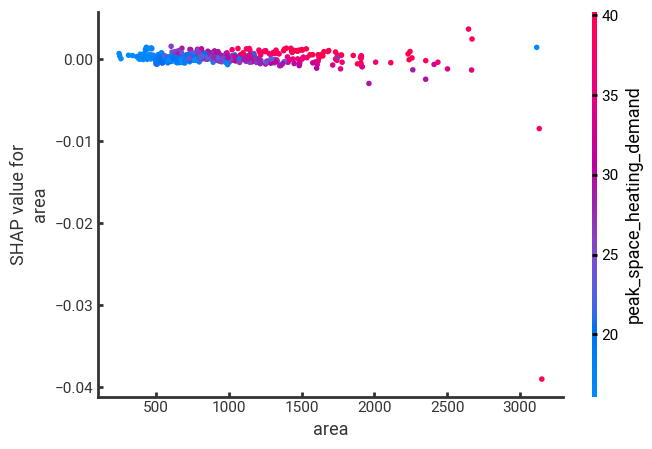

In [ ]:
import dis


shap.dependence_plot(
    "area",
    shap_values,
    x,
    display_features=cluster_1_tree,  # , interaction_index="shape_factor"
)

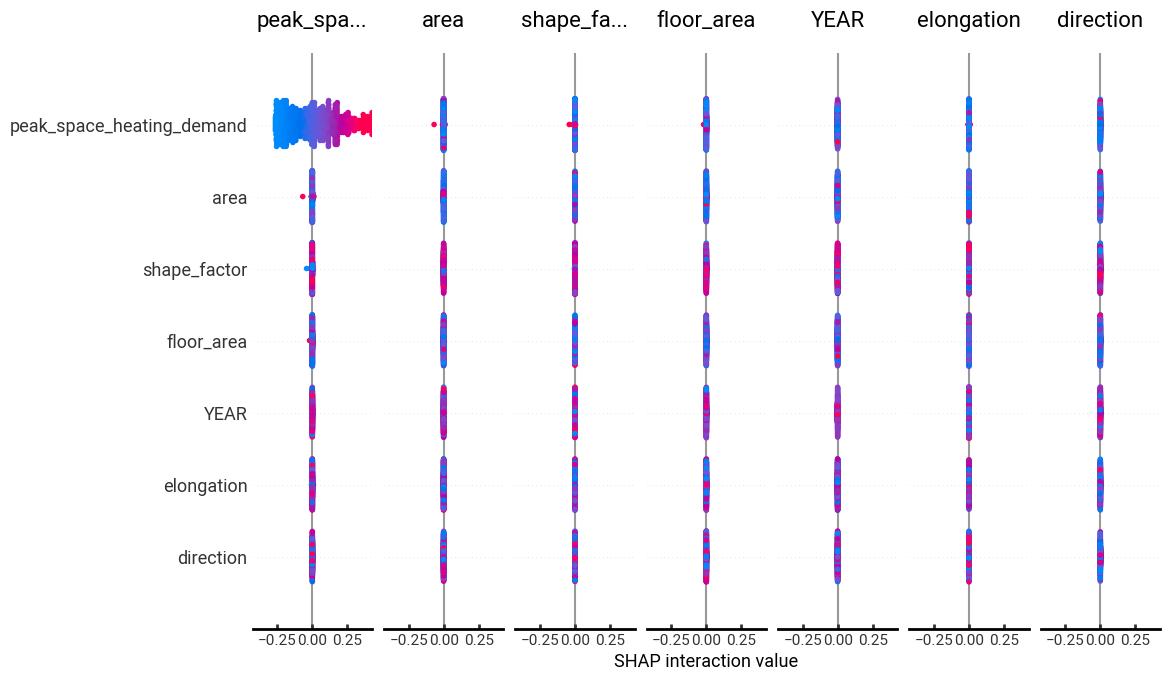

In [ ]:
# explain the interaction between shape factor and area
shap_interaction_values = shap.TreeExplainer(clf_shadow_price).shap_interaction_values(
    x
)
# plot the summary plot
shap.summary_plot(shap_interaction_values, x)

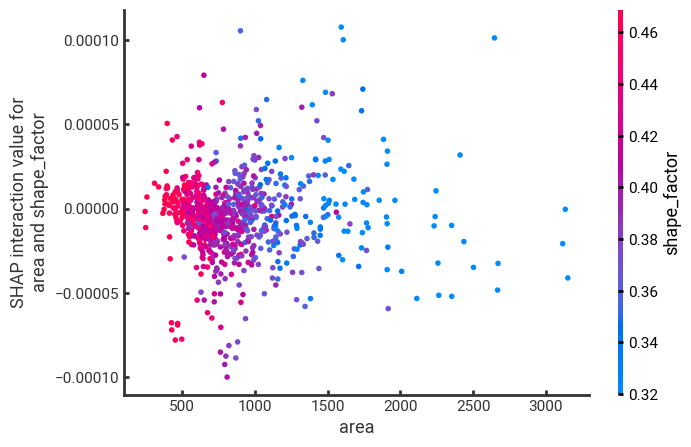

In [ ]:
shap.dependence_plot(
    ("area", "shape_factor"),
    shap_interaction_values,
    x,
    display_features=cluster_1_tree,
    show=False,
)

### Random forest for peak_spece_heating_demand

0.9762417566887395
0.8451326461216704
8.418361128705442 0.8451326461216704


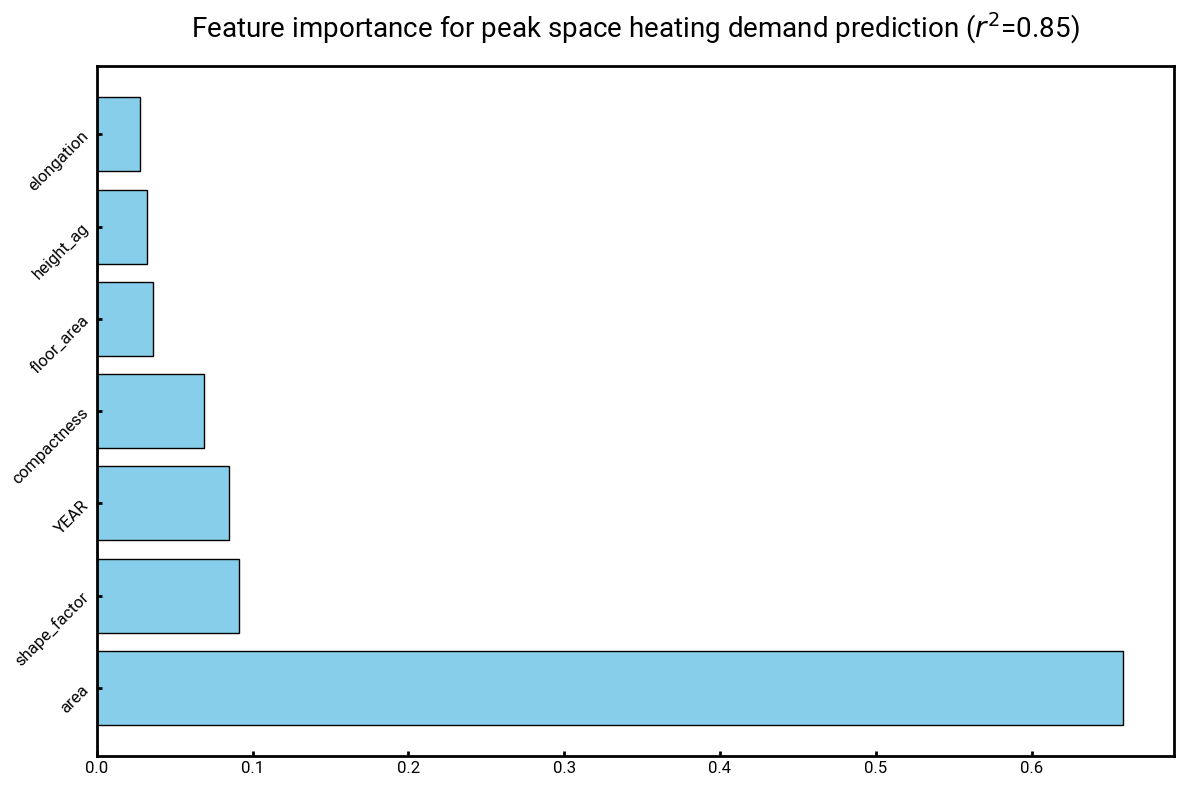

In [10]:
x_peak_demand = cluster_1_tree.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "selected_invest_count",
        "selected_invest_cost",
        "cluster",
        "peak_space_heating_demand",
        "demand_space_heating_intensity",
        "demand_hot_water_intensity",
        "demand_electricity_intensity",
        "inv_shadow_price",
        "log_shadow_price",
        "cluster_selected",
        # "area",
        # "floor_area",
        "type_ctrl",
        # # "YEAR",
        "STANDARD",
        # "compactness",
        # "height_ag",
        "1ST_USE",
        "floors_ag",
        # "elongation",
        "concavity",
        "direction",
        "type_vent",
        "is_dh",
        "type_hs",
        # "shape_factor",
    ]
)
y_peak_demand = cluster_1_tree["peak_space_heating_demand"]

x_train, x_test, y_train, y_test = train_test_split(
    x_peak_demand, y_peak_demand, test_size=0.3, random_state=42
)
clf_peak_demand = RandomForestRegressor(random_state=42)
clf_peak_demand.fit(x_train, y_train)
print(clf_peak_demand.score(x_train, y_train))
print(clf_peak_demand.score(x_test, y_test))
y_pred = clf_peak_demand.predict(x_test)
print(mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))

feature_importance = pd.DataFrame(
    {
        "feature": x_peak_demand.columns,
        "importance": clf_peak_demand.feature_importances_,
    }
).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    feature_importance["feature"],
    feature_importance["importance"],
    color="skyblue",
    edgecolor="black",
)
plt.yticks(rotation=45, ha="right")
plt.title(
    f"Feature importance for peak space heating demand prediction ($r^2$={round(r2_score(y_test, y_pred), 2)})",
    fontsize=20,
)
plt.tight_layout()

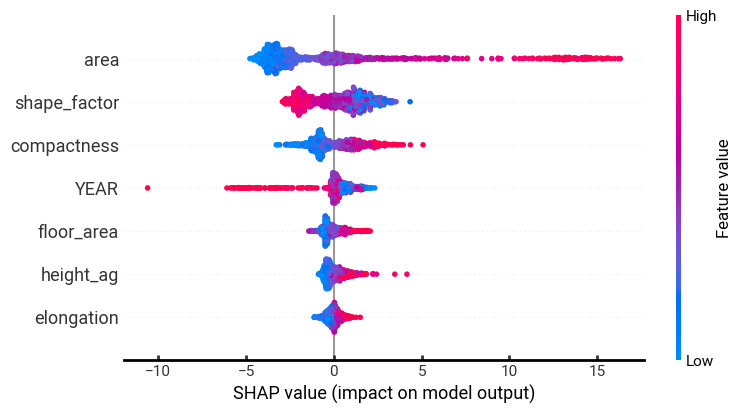

In [11]:
explainer_peak_demand = shap.TreeExplainer(clf_peak_demand)
shap_values_peak_demand = explainer_peak_demand.shap_values(x_peak_demand)
shap.summary_plot(shap_values_peak_demand, x_peak_demand)

Text(0.5, 1.03, "total area's influence on peak space heating demand")

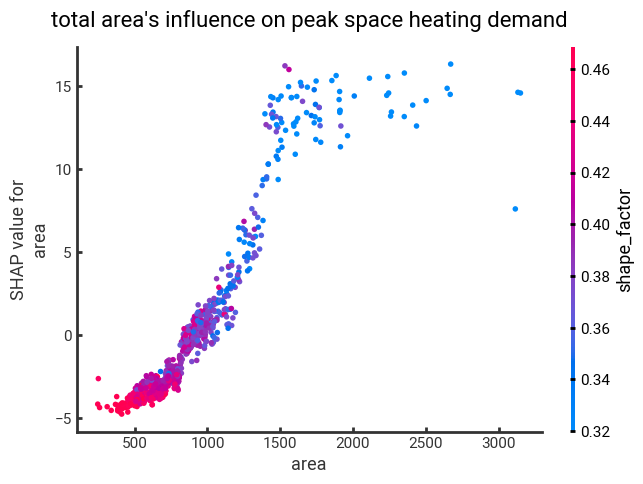

In [ ]:
shap.dependence_plot(
    "area",
    shap_values_peak_demand,
    x_peak_demand,
    display_features=cluster_1_tree,
    show=False,
)
plt.title("total area's influence on peak space heating demand")

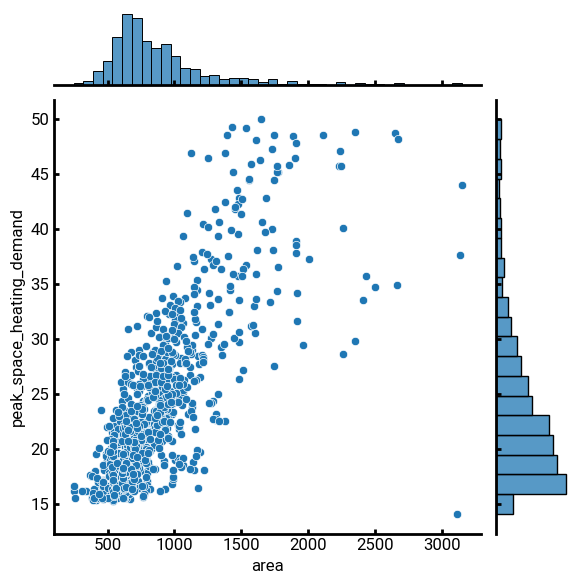

In [ ]:
sns.jointplot(
    data=cluster_1_tree, x="area", y="peak_space_heating_demand", kind="scatter"
)

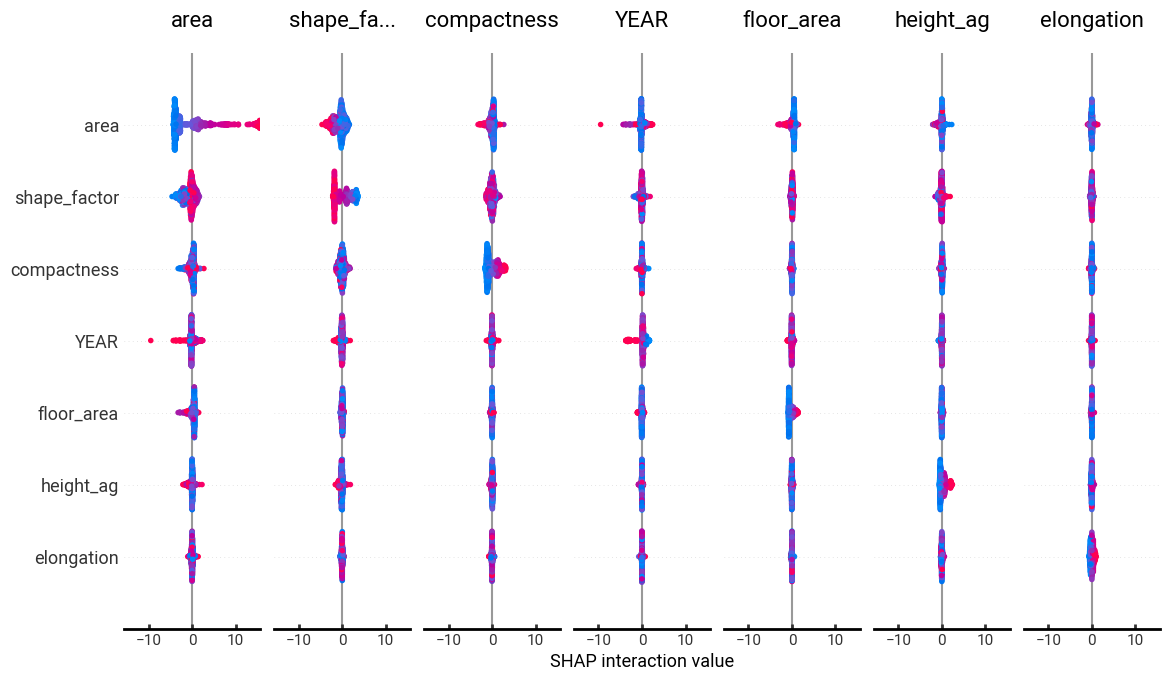

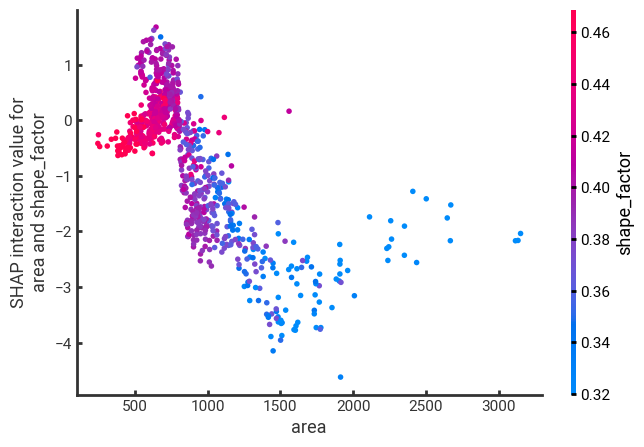

In [ ]:
shap_interaction_values_peak_demand = shap.TreeExplainer(
    clf_peak_demand
).shap_interaction_values(x_peak_demand)

shap.summary_plot(shap_interaction_values_peak_demand, x_peak_demand)

shap.dependence_plot(
    ("area", "shape_factor"),
    shap_interaction_values_peak_demand,
    x_peak_demand,
    display_features=cluster_1_tree,
    show=False,
)

### Random forest for additional_investment_count

0.9384133830581293
0.5383164124537838
19.59952565445026 0.5383164124537838


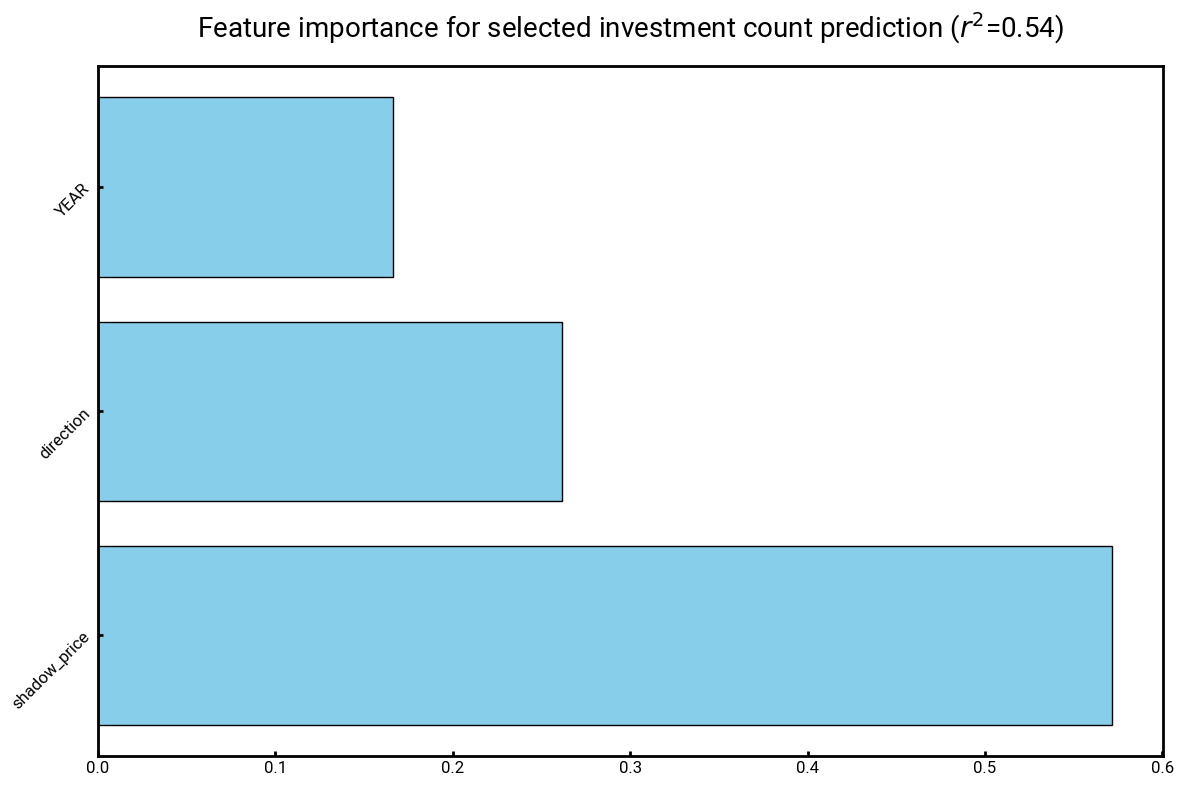

In [ ]:
import itertools


cluster_1_tree_count = cluster_1_tree[cluster_1_tree["selected_invest_count"] > 0]
x_count = cluster_1_tree_count.drop(
    columns=[
        # "shadow_price",
        "inv_shadow_price",
        "log_shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "selected_invest_cost",
        "selected_invest_count",
        "cluster",
        "peak_space_heating_demand",
        "demand_space_heating_intensity",
        "demand_hot_water_intensity",
        "demand_electricity_intensity",
        "cluster_selected",
        "area",
        "floor_area",
        "type_ctrl",
        # "YEAR",
        "STANDARD",
        "compactness",
        "height_ag",
        "1ST_USE",
        "floors_ag",
        "elongation",
        "concavity",
        # "direction",
        "type_vent",
        "is_dh",
        "type_hs",
        "shape_factor",
    ]
)
y_count = cluster_1_tree_count["selected_invest_count"]
x_train, x_test, y_train, y_test = train_test_split(
    x_count, y_count, test_size=0.3, random_state=42
)
clf_count = RandomForestRegressor(random_state=42)
clf_count.fit(x_train, y_train)
print(clf_count.score(x_train, y_train))
print(clf_count.score(x_test, y_test))
y_pred = clf_count.predict(x_test)
print(mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))
feature_importance = pd.DataFrame(
    {"feature": x_count.columns, "importance": clf_count.feature_importances_}
).sort_values("importance", ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    feature_importance["feature"],
    feature_importance["importance"],
    color="skyblue",
    edgecolor="black",
)
plt.yticks(rotation=45, ha="right")
plt.title(
    f"Feature importance for selected investment count prediction ($r^2$={round(r2_score(y_test, y_pred), 2)})",
    fontsize=20,
)
plt.tight_layout()

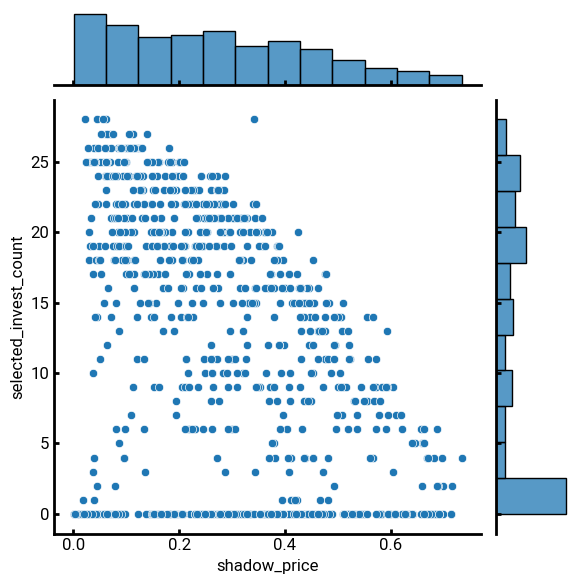

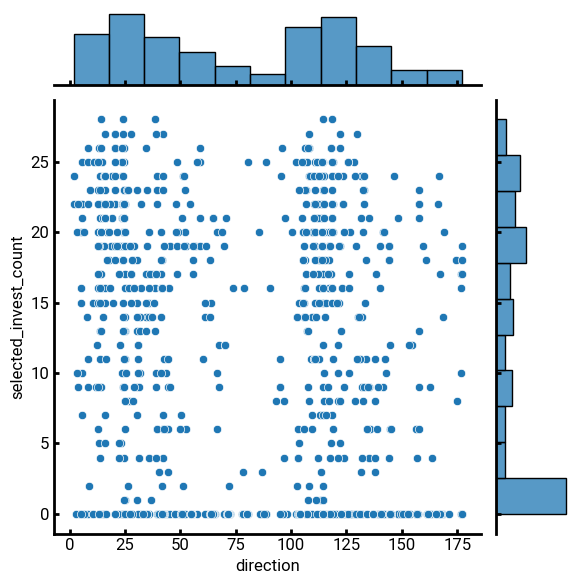

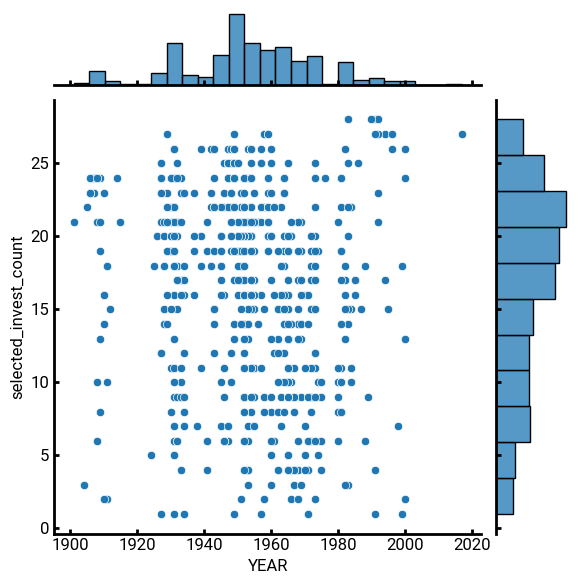

In [ ]:
sns.jointplot(
    data=cluster_1_tree, x="shadow_price", y="selected_invest_count", kind="scatter"
)

sns.jointplot(
    data=cluster_1_tree, x="direction", y="selected_invest_count", kind="scatter"
)
sns.jointplot(
    data=cluster_1_tree_count, x="YEAR", y="selected_invest_count", kind="scatter"
)

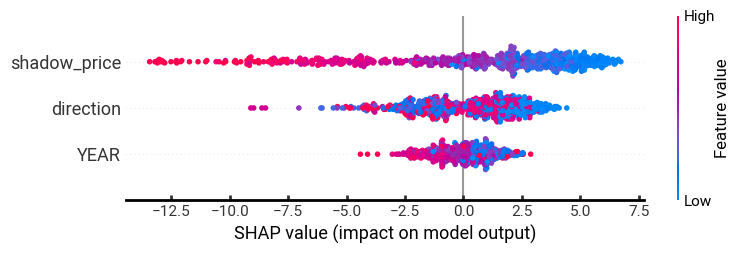

In [ ]:
explainer_count = shap.TreeExplainer(clf_count)
shap_values_count = explainer_count.shap_values(x_count)
shap.summary_plot(shap_values_count, x_count)

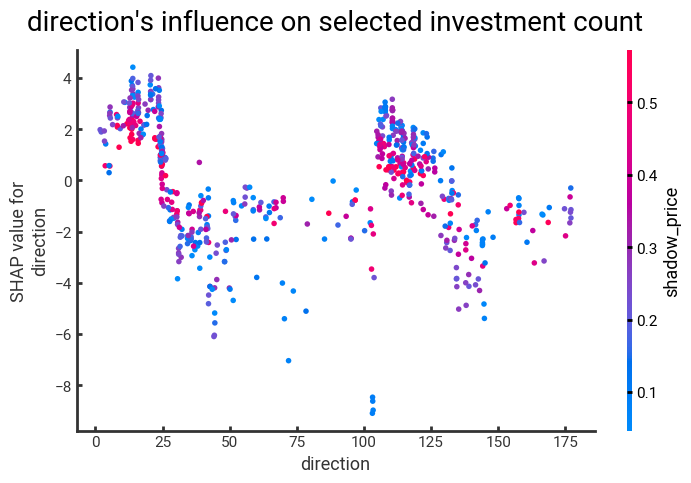

In [63]:
shap.dependence_plot(
    "direction", shap_values_count, x_count, display_features=cluster_1_tree, show=False
)
plt.title("direction's influence on selected investment count", fontsize=20)
plt.tight_layout()

### random forest from geometrical features to investment count

0.9168511639502608
0.40792107694056046
25.135106282722514 0.40792107694056046


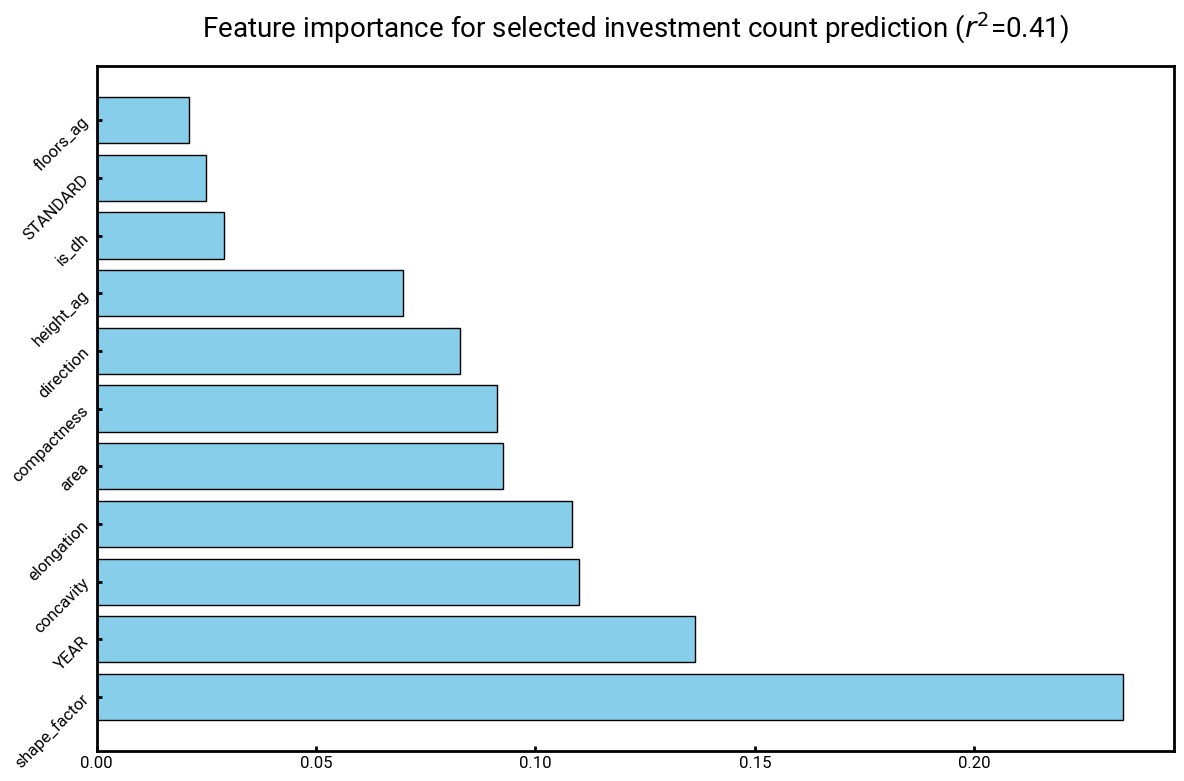

In [ ]:
x_count2 = cluster_1_tree_count.drop(
    columns=[
        "shadow_price",
        "inv_shadow_price",
        "log_shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "selected_invest_cost",
        "selected_invest_count",
        "cluster",
        "peak_space_heating_demand",
        "demand_space_heating_intensity",
        "demand_hot_water_intensity",
        "demand_electricity_intensity",
        "cluster_selected",
        # "area",
        "floor_area",
        "type_ctrl",
        # "YEAR",
        # "STANDARD",
        # "compactness",
        # "height_ag",
        "1ST_USE",
        # "floors_ag",
        # "elongation",
        # "concavity",
        # "direction",
        "type_vent",
        # "is_dh",
        "type_hs",
        # "shape_factor",
    ]
)
y_count2 = cluster_1_tree_count["selected_invest_count"]
x_train, x_test, y_train, y_test = train_test_split(
    x_count2, y_count2, test_size=0.3, random_state=42
)
clf_count2 = RandomForestRegressor(random_state=42)
clf_count2.fit(x_train, y_train)
print(clf_count2.score(x_train, y_train))
print(clf_count2.score(x_test, y_test))
y_pred = clf_count2.predict(x_test)
print(mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))
feature_importance = pd.DataFrame(
    {"feature": x_count2.columns, "importance": clf_count2.feature_importances_}
).sort_values("importance", ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    feature_importance["feature"],
    feature_importance["importance"],
    color="skyblue",
    edgecolor="black",
)
plt.yticks(rotation=45, ha="right")
plt.title(
    f"Feature importance for selected investment count prediction ($r^2$={round(r2_score(y_test, y_pred), 2)})",
    fontsize=20,
)
plt.tight_layout()

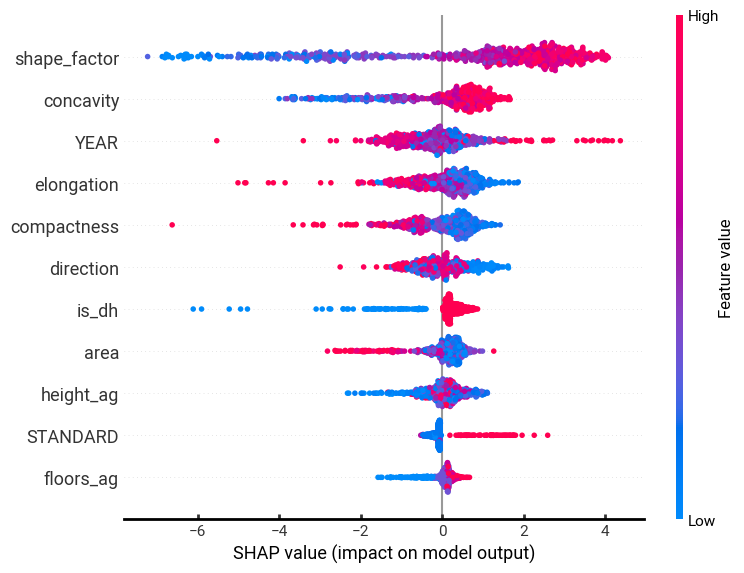

In [102]:
explainer_count2 = shap.TreeExplainer(clf_count2)
shap_values_count2 = explainer_count2.shap_values(x_count2)
shap.summary_plot(shap_values_count2, x_count2)

Text(0.5, 1.03, "shape factor's influence on selected investment count")

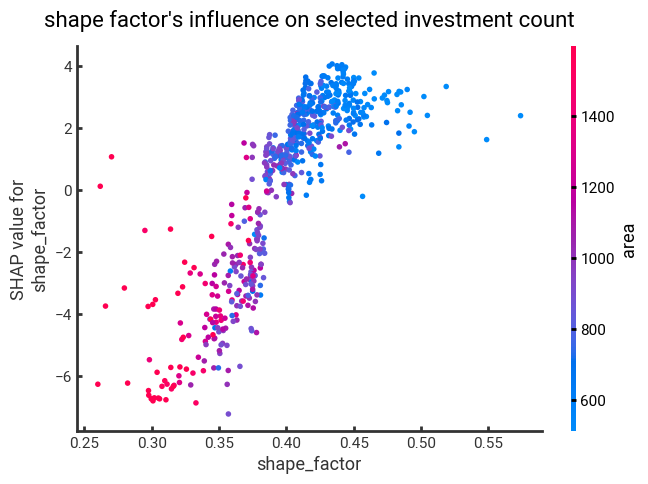

In [ ]:
shap.dependence_plot(
    "shape_factor",
    shap_values_count2,
    x_count2,
    display_features=cluster_1_tree,
    interaction_index="area",
    show=False,
)
plt.title("shape factor's influence on selected investment count")

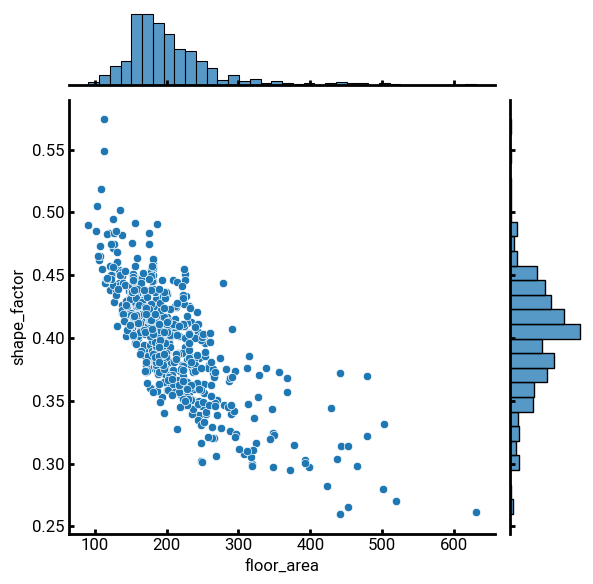

In [ ]:
sns.jointplot(
    data=cluster_1_tree_count, x="floor_area", y="shape_factor", kind="scatter"
)

In [ ]:
", shap_values_count2, x_count2, interaction_index="shape_factor", show=False
)


### random forest for cluster_selected

F1 score: 0.8025234474621248
1.0
0.8029739776951673
              precision    recall  f1-score   support

           0       0.63      0.62      0.62        71
           1       0.86      0.87      0.87       198

    accuracy                           0.80       269
   macro avg       0.75      0.74      0.75       269
weighted avg       0.80      0.80      0.80       269



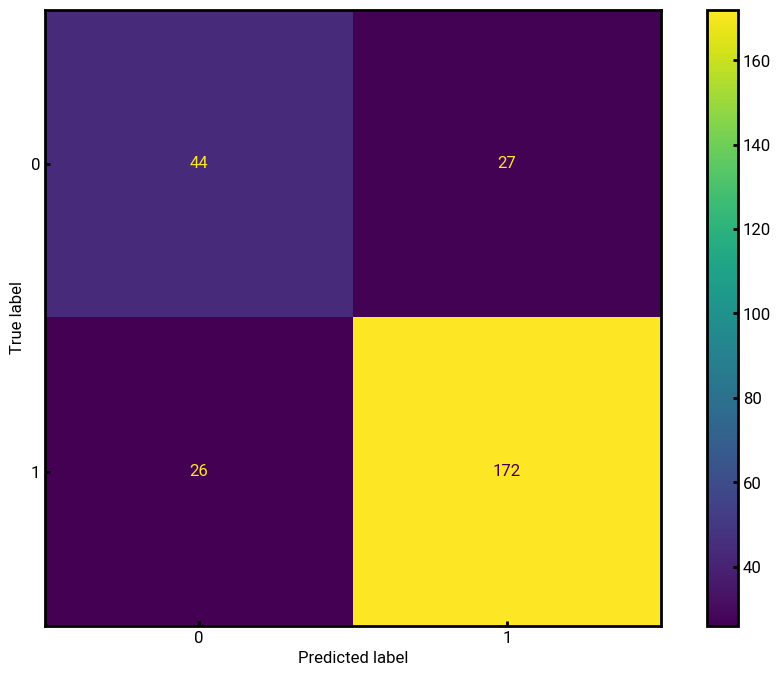

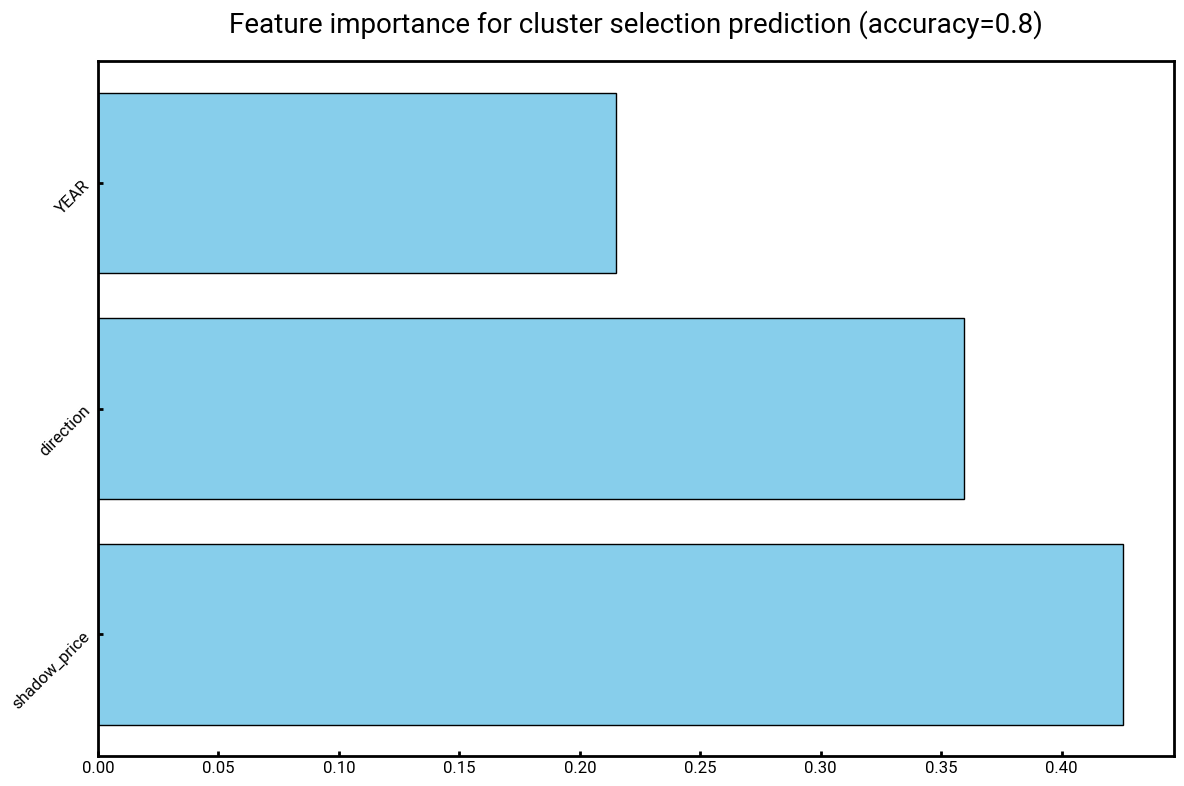

In [ ]:
from sklearn.metrics import f1_score

data_cluster_selected = cluster_1.copy()
columns_drop = [
    # "shadow_price",
    "pf_curvature",
    "emission_range_abs",
    "cost_range",
    "emission_range_rel",
    "selected_invest_cost",
    "selected_invest_count",
    "cluster",
    "peak_space_heating_demand",
    "demand_space_heating_intensity",
    "demand_hot_water_intensity",
    "demand_electricity_intensity",
    "inv_shadow_price",
    "log_shadow_price",
    # "cluster_selected",
    "area",
    "floor_area",
    "type_ctrl",
    # "YEAR",
    "STANDARD",
    "compactness",
    "height_ag",
    "1ST_USE",
    "floors_ag",
    "elongation",
    "concavity",
    # "direction",
    "type_vent",
    "is_dh",
    "type_hs",
    "shape_factor",
]

label_encoders_cluster_selected = {}
for col in data_cluster_selected.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data_cluster_selected[col] = le.fit_transform(data_cluster_selected[col])
    label_encoders_cluster_selected[col] = le

data_cluster_selected.drop(
    columns=columns_drop,
    inplace=True,
)

x_selected = data_cluster_selected.drop(columns=["cluster_selected"])
y_selected = data_cluster_selected["cluster_selected"]
x_train, x_test, y_train, y_test = train_test_split(
    x_selected, y_selected, test_size=0.3, random_state=42
)
clf_selected = RandomForestClassifier(random_state=42)
clf_selected.fit(x_train, y_train)
f1 = f1_score(y_test, clf_selected.predict(x_test), average="weighted")
print(f"F1 score: {f1}")
print(clf_selected.score(x_train, y_train))
print(clf_selected.score(x_test, y_test))
y_pred = clf_selected.predict(x_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=clf_selected.classes_
)
disp.plot()
plt.show()
feature_importance = pd.DataFrame(
    {"feature": x_selected.columns, "importance": clf_selected.feature_importances_}
).sort_values("importance", ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    feature_importance["feature"],
    feature_importance["importance"],
    color="skyblue",
    edgecolor="black",
)
plt.yticks(rotation=45, ha="right")
plt.title(
    f"Feature importance for cluster selection prediction (accuracy={round(clf_selected.score(x_test, y_test), 2)})",
    fontsize=20,
)
plt.tight_layout()

In [ ]:
# use SHAP to explain the model, and see direction's effect on the prediction
explainer = shap.TreeExplainer(clf_selected)
shap_values = explainer.shap_values(x_selected)

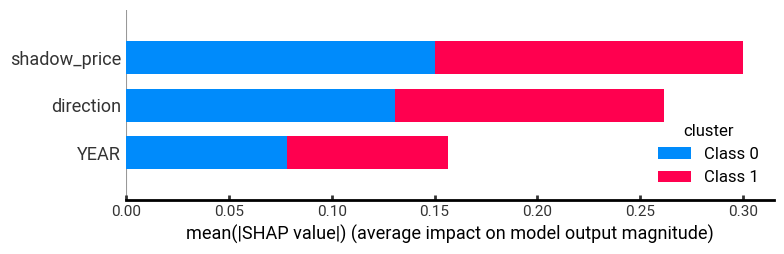

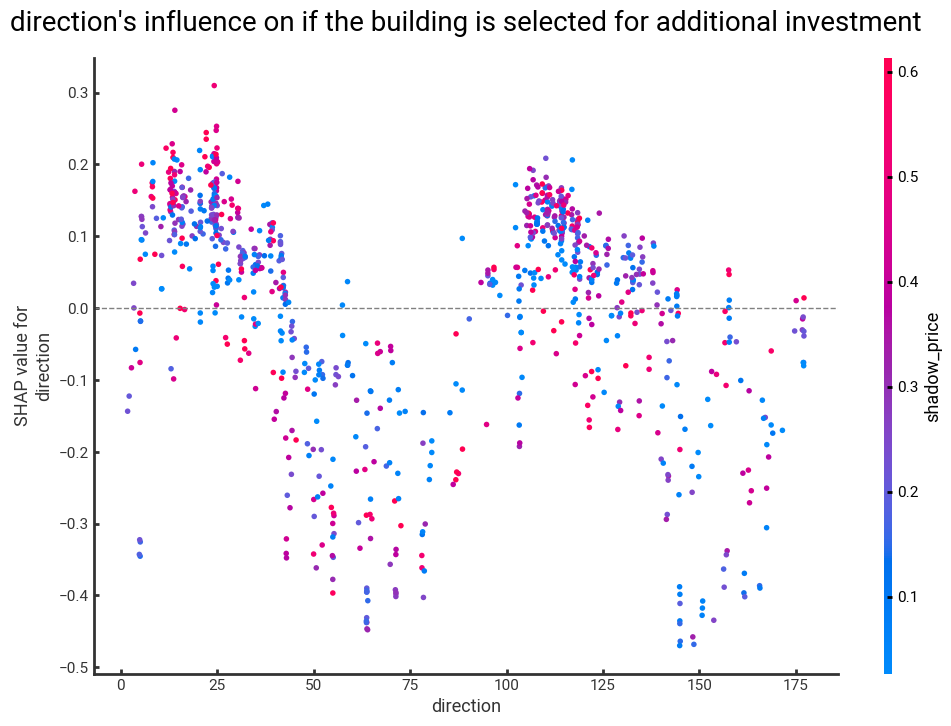

In [ ]:
shap.summary_plot(shap_values, x_selected, show=False)
plt.legend(loc="best", title="cluster")

shap.dependence_plot(
    "direction",
    shap_values[1],
    x_selected,
    display_features=data_cluster_selected,
    show=False,
)
plt.title(
    "direction's influence on if the building is selected for additional investment",
    fontsize=20,
)
# set plot size to be 12x8
plt.gcf().set_size_inches(12, 8)
# add a horizontal line at y=0
plt.axhline(0, color="grey", linestyle="--", linewidth=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


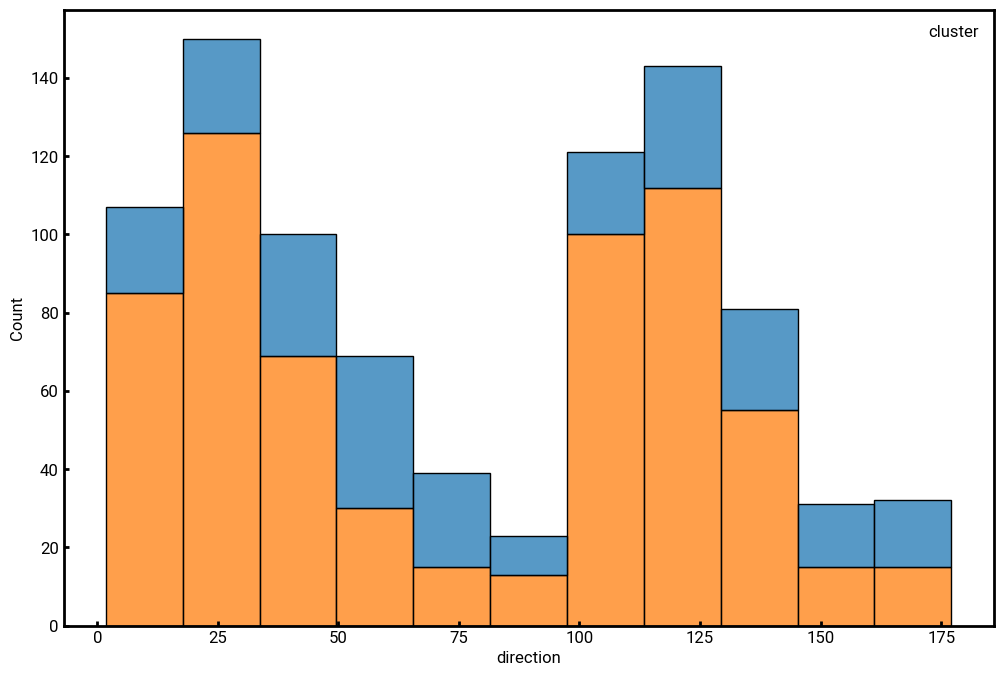

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(
    data=data_cluster_selected,
    x="direction",
    hue="cluster_selected",
    ax=ax,
    multiple="stack",
)
ax.legend(loc="best", title="cluster")

In [ ]:
# show the interaction between direction and other features
shap_interaction_values_selected = shap.TreeExplainer(
    clf_selected
).shap_interaction_values(x_selected)

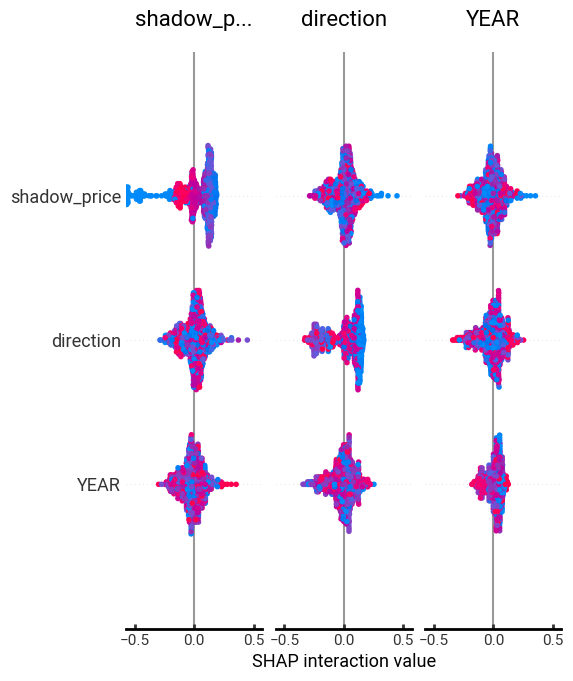

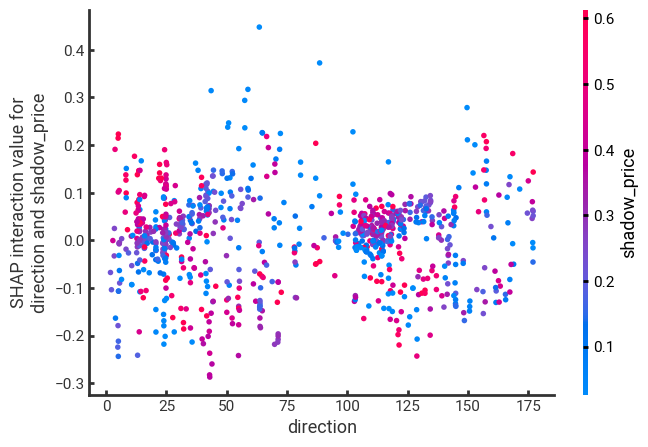

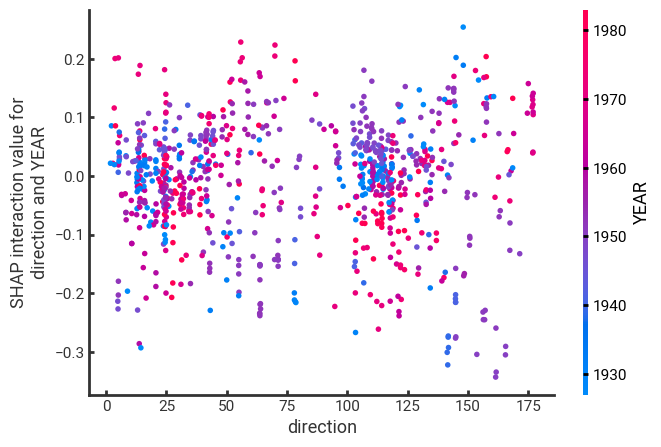

In [296]:
shap.summary_plot(shap_interaction_values_selected[1], x_selected, show=False)

shap.dependence_plot(
    ("direction", "shadow_price"),
    shap_interaction_values_selected[1],
    x_selected,
    display_features=data_cluster_selected,
    show=False,
)

shap.dependence_plot(
    ("direction", "YEAR"),
    shap_interaction_values_selected[1],
    x_selected,
    display_features=data_cluster_selected,
    show=False,
)

### random forest for second cluster in fig2

### parameter correlation in cluster 2

In [ ]:
# calculate and visualize the corelation matrix of cluster_1_encoded
corr = cluster_1_encoded.corr()
fig, ax = plt.subplots()
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

In [ ]:
# plot the scatter plot of each parameter against each other to see the correlation visually using seaborn pairplot
sns.pairplot(cluster_1_encoded)
plt.show()

In [ ]:
x1_train_gbr, x1_test_gbr, y1_train_gbr, y1_test_gbr = train_test_split(
    x, y1, test_size=0.3, random_state=42
)
model = GradientBoostingRegressor(random_state=42)
model.fit(x1_train_gbr, y1_train_gbr)
y1_pred_gbr = model.predict(x1_test_gbr)
print(model.score(x1_test_gbr, y1_test_gbr))

mse_1_gbr = mean_squared_error(y1_test_gbr, y1_pred_gbr)
r2_1_gbr = r2_score(y1_test_gbr, y1_pred_gbr)
print(f"Mean squared error: {mse_1_gbr:.2f}, R2 score: {r2_1_gbr:.2f}")

feature_importance_1_gbr = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance_1_gbr["feature"], feature_importance_1_gbr["importance"])
plt.show()

residuals_1_gbr = y1_test_gbr - y1_pred_gbr
fig, ax = plt.subplots()
ax.scatter(y1_pred_gbr, residuals_1_gbr)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("predicted shadow price from GBR")
ax.set_ylabel("residuals")
plt.show()

In [ ]:
x2_train_gbr, x2_test_gbr, y2_train_gbr, y2_test_gbr = train_test_split(
    x, y2, test_size=0.3, random_state=42
)
model = GradientBoostingRegressor(random_state=42)
model.fit(x2_train_gbr, y2_train_gbr)
y2_pred_gbr = model.predict(x2_test_gbr)
print(model.score(x2_test_gbr, y2_test_gbr))

mse_2_gbr = mean_squared_error(y2_test_gbr, y2_pred_gbr)
r2_2_gbr = r2_score(y2_test_gbr, y2_pred_gbr)
print(f"Mean squared error: {mse_2_gbr:.2f}, R2 score: {r2_2_gbr:.2f}")

feature_importance_2_gbr = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance_2_gbr["feature"], feature_importance_2_gbr["importance"])
plt.show()

residuals_2_gbr = y2_test_gbr - y2_pred_gbr
fig, ax = plt.subplots()
ax.scatter(y2_pred_gbr, residuals_2_gbr)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel(
    "predicted relative emission reduction potential from Gradient Boosting Regressor"
)
ax.set_ylabel("residuals")

In [ ]:
# train random forest model for the selected investments
x3 = cluster_1_tree.drop(
    columns=[
        "selected_invest_count",  # target variable
    ]
)
y3 = cluster_1_tree["selected_invest_count"]

x3_train, x3_test, y3_train, y3_test = train_test_split(
    x3, y3, test_size=0.3, random_state=42
)
model = RandomForestRegressor(random_state=42)

model.fit(x3_train, y3_train)
y3_pred = model.predict(x3_test)
print(model.score(x3_test, y3_test))

mse_3 = mean_squared_error(y3_test, y3_pred)
r2_3 = r2_score(y3_test, y3_pred)
print(f"Mean squared error: {mse_3:.2f}, R2 score: {r2_3:.2f}")

feature_importance_3 = pd.DataFrame(
    {"feature": x3.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance_3["feature"], feature_importance_3["importance"])
plt.show()